# Task 2: AutoEncoder & HDBSCAN for joint probability anomaly type estimation

We suppose all the data is within the *./data* folder.

## Libraries import

In [ ]:
# ==============================================================================
# IMPORTS - ALL REQUIRED LIBRARIES FOR THE NOTEBOOK
# ==============================================================================

# Standard Library
import os
import sys
import subprocess
import glob
import pickle
import importlib
from collections import Counter, defaultdict

# Data Processing
import numpy as np
import pandas as pd

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# Machine Learning - Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Clustering
import hdbscan

# Hyperparameter Optimization
try:
    import optuna
    from optuna.trial import TrialState
except ModuleNotFoundError:
    print("Installing optuna...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "optuna"])
    import optuna
    from optuna.trial import TrialState

# Visualization
import matplotlib.pyplot as plt

# Progress Bars
from tqdm.notebook import tqdm

# Custom Anomaly Injection Module
import generate_anomalies_template
importlib.reload(generate_anomalies_template)
from generate_anomalies_template import (
    inject_closing_spikes, 
    inject_closing_level_shift, 
    inject_closing_linear_drift,
    inject_closing_variance_change, 
    inject_closing_sinusoidal, 
    inject_closing_delayed_closure,
    inject_closing_water_hammer_spike, 
    inject_closing_signal_dropout,
)

## Data Preprocessing

In [ ]:
# Configuration
DATA_DIR = './data'
OUTPUT_DIR = './data_transitions'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Preprocessing Parameters
EMA_ALPHA = 0.5
GAP_THRESHOLD_SECONDS = 300  # 5 minutes limit for forward fill
HALF_WINDOW = 180

print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

Data Directory: ./ML4PM_FINAL/data
Output Directory: ./ML4PM_FINAL/data/data_transitions


In [4]:
# ----------------------------------------------------------------------
# SIGNAL MAPPING
# ----------------------------------------------------------------------
mapping = {
    'signal_id': [8890,9620,9619,11247,11333,11331,16769,15454,15453,16679,14156,14154,
                  26499,30654,30653,29296,29388,29386,16796,24141,24140,25120,25207,25205,
                  18263,19318,19317,21058,21145,21143],
    'measurement_unit': ['MW','', '', '%','bar','bar','MW','','','%','bar','bar',
                         'MW','','','%','bar','bar','MW','','','%','bar','bar',
                         'MW','','','%','bar','bar'],
    'type_id': ['measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)'],
    'plant': ['KSL']*30,
    'stage': ['Mapragg','Mapragg','Mapragg','Mapragg','Mapragg','Mapragg',
              'Sarelli','Sarelli','Sarelli','Sarelli','Sarelli','Sarelli',
              'Mapragg','Mapragg','Mapragg','Mapragg','Mapragg','Mapragg',
              'Sarelli','Sarelli','Sarelli','Sarelli','Sarelli','Sarelli',
              'Mapragg','Mapragg','Mapragg','Mapragg','Mapragg','Mapragg'],
    'machine_group': ['MG1','MG1','MG1','MG1','MG1','MG1',
                      'MG1','MG1','MG1','MG1','MG1','MG1',
                      'MG2','MG2','MG2','MG2','MG2','MG2',
                      'MG2','MG2','MG2','MG2','MG2','MG2',
                      'MG3','MG3','MG3','MG3','MG3','MG3'],
    'signal_name': ['active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream'],
    'description': [
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
    ]
}

df_mapping = pd.DataFrame(mapping)
df_mapping.head()

signal_id measurement_unit               type_id plant    stage  \
0       8890               MW  measurement (analog)   KSL  Mapragg   
1       9620                                   Bool   KSL  Mapragg   
2       9619                                   Bool   KSL  Mapragg   
3      11247                %  measurement (analog)   KSL  Mapragg   
4      11333              bar  measurement (analog)   KSL  Mapragg   

  machine_group                signal_name  \
0           MG1               active_power   
1           MG1          ball_valve_closed   
2           MG1            ball_valve_open   
3           MG1        guide_vane_position   
4           MG1  water_pressure_downstream   

                                         description  
0                           Active power measurement  
1  Ball valve position rotating body closed (true...  
2  Ball valve position rotating body open (true i...  
3                    Guide vane position measurement  
4           water pressure downstream of the turbine

In [ ]:
def process_parquet(file_path, df_map, output_dir, GAP_THRESHOLD_SECONDS=300, EMA_ALPHA=0.1):
    """
    Process a single parquet file with Robust NaN Handling:
    1. Load and map signals.
    2. Resample to 1s grid (time alignment).
    3. Forward fill small gaps (max 5 mins), leaving larger gaps as NaN.
    4. EMA smoothing for analog signals.
    5. Extract transitions for valves.
    6. Save processed data and transitions.
    """
    filename = os.path.basename(file_path)
    base_name = filename.replace('.parquet', '')
    print(f"Processing {filename}...")
    
    # 1. Load Parquet
    try:
        df = pd.read_parquet(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return

    # Ensure ts is datetime and timezone naive
    if not pd.api.types.is_datetime64_any_dtype(df['ts']):
        df['ts'] = pd.to_datetime(df['ts'])
    if df['ts'].dt.tz is not None:
        df['ts'] = df['ts'].dt.tz_convert(None)
        
    # Merge with mapping to get signal names and types
    df = df.merge(df_map[['signal_id', 'signal_name', 'type_id']], on='signal_id', how='inner')
    
    # 2. Time Alignment
    # FIX: Use .dt.round('1s') to explicitly round to nearest second and remove microseconds
    df['ts_rounded'] = df['ts'].dt.round('1s')

    # Ensure values are numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Pivot to create unified grid for this asset (handles duplicates by averaging)
    pivot_df = df.pivot_table(index='ts_rounded', columns='signal_name', values='value', aggfunc='mean')
    
    # Create full 1s grid from min to max time to ensure continuous time axis
    full_idx = pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='1s')
    
    # Reindex: This creates NaNs where timestamps are missing in the original data
    pivot_df = pivot_df.reindex(full_idx)
    pivot_df.index.name = 'ts'
    
    # 3. Robust NaN Handling: Forward Fill with Limit
    # We do NOT interpolate. We ffill up to 5 minutes.
    # Gaps larger than 5 minutes will remain NaN (to be dropped or handled by downstream windowing logic).
    pivot_df_filled = pivot_df.ffill(limit=GAP_THRESHOLD_SECONDS)
    
    # 4. Apply EMA to Analog Signals
    # Note: EMA handles NaNs gracefully (ignores them), but works best on the filled data
    analog_signals = df_map[df_map['type_id'] == 'measurement (analog)']['signal_name'].unique()
    
    for col in pivot_df_filled.columns:
        if col in analog_signals:
            pivot_df_filled[col] = pivot_df_filled[col].ewm(alpha=EMA_ALPHA, adjust=False).mean()

    # 5. Transition Flagging (for Boolean Signals)
    # We use the original pivot (or filled, depending on preference) to detect changes.
    # Usually, transitions should be detected on filled data to avoid false transitions around gaps,
    # but here we use the specific logic provided.
    bool_signals = df_map[df_map['type_id'] == 'Bool']['signal_name'].unique()
    transitions_list = []
    
    for col in bool_signals:
        # Check if column exists in data
        if col in pivot_df_filled.columns:
            s_raw = pivot_df_filled[col].dropna()
            
            if s_raw.empty:
                continue
            
            # Detect changes: value != prev_value
            prev = s_raw.shift(1)
            mask = (s_raw != prev) & prev.notna()
            
            num_trans = mask.sum()
            if num_trans > 0:
                trans_times = s_raw.index[mask]
                trans_values = s_raw[mask]
                prev_values = prev[mask]
                
                tdf = pd.DataFrame({
                    'timestamp': trans_times,
                    'signal': col,
                    'from_value': prev_values,
                    'to_value': trans_values
                })
                transitions_list.append(tdf)

    # 6. Save Outputs
    processed_path = os.path.join(output_dir, f"{base_name}_processed.pkl")
    pivot_df_filled.to_pickle(processed_path)
    print(f"  Saved processed data to {processed_path}")
    
    if transitions_list:
        all_transitions = pd.concat(transitions_list).sort_values('timestamp')
        trans_path = os.path.join(output_dir, f"{base_name}_transitions.pkl")
        all_transitions.to_pickle(trans_path)
        print(f"  Saved {len(all_transitions)} transitions to {trans_path}")
    else:
        print("  No transitions found.")

In [6]:
# ----------------------------------------------------------------------
# EXECUTE PIPELINE
# ----------------------------------------------------------------------
parquet_files = glob.glob(os.path.join(DATA_DIR, '*.parquet'))
print(f"Found {len(parquet_files)} parquet files.")

for path in parquet_files:
    process_parquet(path, df_mapping, OUTPUT_DIR)

print("\nPipeline execution complete.")

Found 10 parquet files.
Processing Mapragg_MG1_testing_real_measurements.parquet...
  Saved processed data to ./ML4PM_FINAL/data_transitions\Mapragg_MG1_testing_real_measurements_processed.pkl
  Saved 440 transitions to ./ML4PM_FINAL/data_transitions\Mapragg_MG1_testing_real_measurements_transitions.pkl
Processing Mapragg_MG1_training_real_measurements.parquet...
  Saved processed data to ./ML4PM_FINAL/data_transitions\Mapragg_MG1_training_real_measurements_processed.pkl
  Saved 2610 transitions to ./ML4PM_FINAL/data_transitions\Mapragg_MG1_training_real_measurements_transitions.pkl
Processing Mapragg_MG2_testing_real_measurements.parquet...
  Saved processed data to ./ML4PM_FINAL/data_transitions\Mapragg_MG2_testing_real_measurements_processed.pkl
  Saved 410 transitions to ./ML4PM_FINAL/data_transitions\Mapragg_MG2_testing_real_measurements_transitions.pkl
Processing Mapragg_MG2_training_real_measurements.parquet...
  Saved processed data to ./ML4PM_FINAL/data_transitions\Mapragg_MG2

## Import data and split by turbine and pumping

In [ ]:
# ==============================================================================
# LOAD WINDOWS SPLIT BY REGIME (TURBINE vs PUMP)
# ==============================================================================
# Regime classification based on active_power BEFORE transition:
#   - active_power > 0  → TURBINE mode (generating electricity)
#   - active_power ≤ 0  → PUMP mode (consuming electricity)
# ==============================================================================

# Configuration
TRANSITIONS_DIR = './data_transitions'
SIGNALS = ['active_power', 'ball_valve_closed', 'ball_valve_open',
           'guide_vane_position', 'water_pressure_downstream', 'water_pressure_upstream']

# ==============================================================================
# WINDOW EXTRACTOR CLASS (self-contained)
# ==============================================================================
class WindowExtractorCombined:
    """Extract windows with ALL signals combined (flattened)."""
    def __init__(self, data_dir, half_window=180, closing_only=True):
        self.data_dir = data_dir
        self.half_window = half_window
        self.feature_cols = SIGNALS
        self.closing_only = closing_only
    
    def _get_closing_timestamp(self, group):
        """Get the exact timestamp when the valve closes."""
        votes_opening = 0
        votes_closing = 0
        ball_valve_closed_01_ts = None
        ball_valve_open_10_ts = None
        
        for row in group:
            sig = row['signal']
            v_from = row['from_value']
            v_to = row['to_value']
            ts = row['timestamp']
            
            if sig == 'ball_valve_open':
                if v_from == 0 and v_to == 1:
                    votes_opening += 1
                elif v_from == 1 and v_to == 0:
                    votes_closing += 1
                    ball_valve_open_10_ts = ts
            elif sig == 'ball_valve_closed':
                if v_from == 0 and v_to == 1:
                    votes_closing += 1
                    ball_valve_closed_01_ts = ts
                elif v_from == 1 and v_to == 0:
                    votes_opening += 1
        
        if votes_closing > votes_opening:
            is_closing = True
        elif votes_opening > votes_closing:
            is_closing = False
        else:
            is_closing = None
        
        if ball_valve_closed_01_ts is not None:
            center_ts = ball_valve_closed_01_ts
        elif ball_valve_open_10_ts is not None:
            center_ts = ball_valve_open_10_ts
        else:
            center_ts = None
        
        return (is_closing, center_ts)
        
    def extract_windows(self, processed_file, transitions_file):
        """Extract flattened windows centered on transitions."""
        if not os.path.exists(processed_file) or not os.path.exists(transitions_file):
            return []
            
        df = pd.read_pickle(processed_file)
        df = df.reindex(columns=self.feature_cols)
        df = df.ffill().bfill().fillna(0)
        
        df_trans = pd.read_pickle(transitions_file)
        
        if df_trans.empty:
            return []
            
        # Group transitions within 180s
        df_trans = df_trans.sort_values('timestamp')
        grouped_events = []
        
        current_group = [df_trans.iloc[0]]
        for i in range(1, len(df_trans)):
            curr = df_trans.iloc[i]
            prev = current_group[-1]
            diff = (curr['timestamp'] - prev['timestamp']).total_seconds()
            
            if diff < 180:
                current_group.append(curr)
            else:
                grouped_events.append(current_group)
                current_group = [curr]
        grouped_events.append(current_group)
        
        windows = []
        
        for group in grouped_events:
            is_closing, center_ts = self._get_closing_timestamp(group)
            
            if self.closing_only:
                if is_closing is False or is_closing is None:
                    continue
            
            if center_ts is None:
                if not self.closing_only:
                    min_ts = group[0]['timestamp']
                    max_ts = group[-1]['timestamp']
                    center_ts = min_ts + (max_ts - min_ts) / 2
                else:
                    continue
            
            center_ts = center_ts.round('1s')
            
            try:
                idx = df.index.searchsorted(center_ts)
                if idx == 0:
                    center_idx = 0
                elif idx == len(df):
                    center_idx = len(df) - 1
                else:
                    ts_prev = df.index[idx-1]
                    ts_curr = df.index[idx]
                    if abs((ts_curr - center_ts).total_seconds()) < abs((ts_prev - center_ts).total_seconds()):
                        center_idx = idx
                    else:
                        center_idx = idx - 1
                
                start_idx = center_idx - self.half_window
                end_idx = center_idx + self.half_window
                
                if start_idx < 0 or end_idx > len(df):
                    continue
                
                window_df = df.iloc[start_idx:end_idx][self.feature_cols]
                
                if window_df.shape[0] == 2 * self.half_window:
                    windows.append(window_df.values.flatten())
            except Exception:
                continue
                
        return windows


# ==============================================================================
# REGIME IDENTIFICATION & LOADING FUNCTIONS
# ==============================================================================
def identify_regime(window_flat, n_signals=6, n_timesteps=360):
    """
    Identify operating regime from active_power signal BEFORE the transition.
    Returns 'turbine' if mean(active_power) > 0, else 'pump'.
    """
    window_2d = window_flat.reshape(n_timesteps, n_signals)
    power_before = window_2d[:180, 0]  # active_power is column 0
    return 'turbine' if np.mean(power_before) > 0 else 'pump'


def load_windows_by_regime(split='training', closing_only=True):
    """Load windows and split by operating regime (turbine vs pump)."""
    extractor = WindowExtractorCombined(TRANSITIONS_DIR, half_window=HALF_WINDOW, closing_only=closing_only)
    windows_turbine, windows_pump = [], []
    
    files = sorted([f for f in os.listdir(TRANSITIONS_DIR) 
                    if f.endswith('_processed.pkl') and split in f])
    
    print(f"   Loading {split} data ({len(files)} files)...")
    if closing_only:
        print(f"   [FILTER] Only CLOSING transitions")
    
    for f in tqdm(files, desc=f"{split}", leave=False):
        base = f.replace('_processed.pkl', '')
        processed_path = os.path.join(TRANSITIONS_DIR, f)
        transitions_path = os.path.join(TRANSITIONS_DIR, f"{base}_transitions.pkl")
        
        windows = extractor.extract_windows(processed_path, transitions_path)
        
        for w in windows:
            if identify_regime(w) == 'turbine':
                windows_turbine.append(w)
            else:
                windows_pump.append(w)
    
    return {
        'turbine': np.array(windows_turbine) if windows_turbine else np.array([]),
        'pump': np.array(windows_pump) if windows_pump else np.array([])
    }


# ==============================================================================
# LOAD ALL 4 DATASETS
# ==============================================================================
print("="*60)
print("LOADING DATA SPLIT BY REGIME (TURBINE vs PUMP)")
print("="*60)
print(f"Regime rule: active_power > 0 → TURBINE, active_power ≤ 0 → PUMP")
print(f"Window: {HALF_WINDOW*2} seconds centered on valve closing")
print("="*60)

# Training data
print("\n[1/2] Loading TRAINING windows...")
train_data = load_windows_by_regime('training', closing_only=True)
X_train_turbine = train_data['turbine']
X_train_pump = train_data['pump']

# Testing data
print("\n[2/2] Loading TESTING windows...")
test_data = load_windows_by_regime('testing', closing_only=True)
X_test_turbine = test_data['turbine']
X_test_pump = test_data['pump']

# ==============================================================================
# SUMMARY
# ==============================================================================
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\n{'Dataset':<25} {'Samples':<10} {'Shape':<20}")
print("-"*55)
print(f"{'X_train_turbine':<25} {len(X_train_turbine):<10} {X_train_turbine.shape if len(X_train_turbine) > 0 else 'empty'}")
print(f"{'X_train_pump':<25} {len(X_train_pump):<10} {X_train_pump.shape if len(X_train_pump) > 0 else 'empty'}")
print(f"{'X_test_turbine':<25} {len(X_test_turbine):<10} {X_test_turbine.shape if len(X_test_turbine) > 0 else 'empty'}")
print(f"{'X_test_pump':<25} {len(X_test_pump):<10} {X_test_pump.shape if len(X_test_pump) > 0 else 'empty'}")
print("-"*55)
print(f"{'Total TURBINE':<25} {len(X_train_turbine) + len(X_test_turbine):<10}")
print(f"{'Total PUMP':<25} {len(X_train_pump) + len(X_test_pump):<10}")
print(f"{'Total ALL':<25} {len(X_train_turbine) + len(X_test_turbine) + len(X_train_pump) + len(X_test_pump):<10}")
print("="*60)

print("\n✓ Datasets ready for autoencoder training:")
print(f"  • TURBINE AE: train={len(X_train_turbine)}, test={len(X_test_turbine)}")
print(f"  • PUMP AE:    train={len(X_train_pump)}, test={len(X_test_pump)}")

LOADING DATA SPLIT BY REGIME (TURBINE vs PUMP)
Regime rule: active_power > 0 → TURBINE, active_power ≤ 0 → PUMP
Window: 360 seconds centered on valve closing

[1/2] Loading TRAINING windows...
   Loading training data (5 files)...
   [FILTER] Only CLOSING transitions


training:   0%|          | 0/5 [00:00<?, ?it/s]


[2/2] Loading TESTING windows...
   Loading testing data (5 files)...
   [FILTER] Only CLOSING transitions


testing:   0%|          | 0/5 [00:00<?, ?it/s]


DATASET SUMMARY

Dataset                   Samples    Shape               
-------------------------------------------------------
X_train_turbine           948        (948, 2160)
X_train_pump              616        (616, 2160)
X_test_turbine            198        (198, 2160)
X_test_pump               160        (160, 2160)
-------------------------------------------------------
Total TURBINE             1146      
Total PUMP                776       
Total ALL                 1922      

✓ Datasets ready for autoencoder training:
  • TURBINE AE: train=948, test=198
  • PUMP AE:    train=616, test=160


# AutoEncoder
## Autoencoder definition and training

We train one AE for pumping and one for turbining seperately

Configuration:
  - Signals: 6 (['active_power', 'ball_valve_closed', 'ball_valve_open', 'guide_vane_position', 'water_pressure_downstream', 'water_pressure_upstream'])
  - Input dimension: 6 × 360 = 2160
  - Architecture: 2160 → 512 → 256 → 128

LOADING DATA SPLIT BY REGIME (TURBINE vs PUMP)
Regime rule: active_power > 0 → TURBINE, active_power ≤ 0 → PUMP
Window: 360 seconds centered on valve closing

[1/2] Loading TRAINING windows...
   Loading training data (5 files)...
   [FILTER] Only CLOSING transitions


training:   0%|          | 0/5 [00:00<?, ?it/s]


[2/2] Loading TESTING windows...
   Loading testing data (5 files)...
   [FILTER] Only CLOSING transitions


testing:   0%|          | 0/5 [00:00<?, ?it/s]


DATASET SUMMARY

Dataset                   Samples    Shape               
-------------------------------------------------------
X_train_turbine           948        (948, 2160)
X_train_pump              616        (616, 2160)
X_test_turbine            198        (198, 2160)
X_test_pump               160        (160, 2160)
-------------------------------------------------------
Total TURBINE             1146      
Total PUMP                776       

TRAINING REGIME-SPECIFIC AUTOENCODERS
Loss: Hybrid (Uniform MSE + Transition-Weighted MSE)
  - Uniform weight (λ): 1.0
  - Gaussian amplitude: 4.0

TRAINING TURBINE AUTOENCODER
  Samples: 948
  Loss: Uniform MSE (λ=1.0) + Weighted MSE (amp=4.0)


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training turbine:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 20: train=0.0039, val=0.0063
  Epoch 40: train=0.0028, val=0.0041
  Epoch 60: train=0.0021, val=0.0035
  Epoch 80: train=0.0019, val=0.0032
  Early stopping at epoch 84
  ✓ Best validation loss: 0.003176

TRAINING PUMP AUTOENCODER
  Samples: 616
  Loss: Uniform MSE (λ=1.0) + Weighted MSE (amp=4.0)


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training pump:   0%|          | 0/100 [00:00<?, ?it/s]

  Epoch 20: train=0.0116, val=0.0041
  Epoch 40: train=0.0073, val=0.0031
  Early stopping at epoch 53
  ✓ Best validation loss: 0.002862

TRAINING COMPLETE


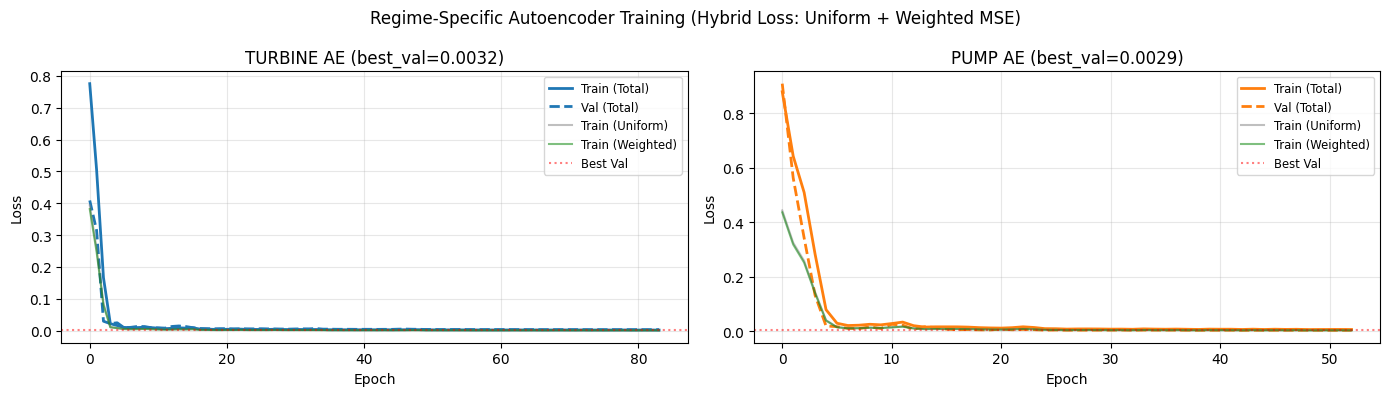


SUMMARY:
----------------------------------------
  TURBINE    | train=948   test=198   | best_val=0.0032
  PUMP       | train=616   test=160   | best_val=0.0029

✓ Models available: model_turbine, model_pump
✓ Scalers available: scaler_turbine, scaler_pump
✓ Results dict: results_regime['turbine'], results_regime['pump']


In [ ]:
# ==============================================================================
# AUTOENCODER ANOMALY DETECTION PIPELINE
# VERSION: REGIME-SPECIFIC (TURBINE vs PUMP)
# ==============================================================================
# Trains TWO separate autoencoders:
#   - TURBINE AE: For transitions when active_power > 0
#   - PUMP AE: For transitions when active_power ≤ 0
# ==============================================================================

# ==============================================================================
# CONFIGURATION
# ==============================================================================
WINDOW_SECONDS = 360
HALF_WINDOW = 180
TRANSITIONS_DIR = './data_transitions'

# Hyperparameters (from Optuna optimization)
BATCH_SIZE_AE2 = 32
EPOCHS_AE2 = 100
LEARNING_RATE_AE2 = 0.001
BOTTLENECK_DIM_AE2 = 128
WEIGHT_DECAY_AE2 = 1.57442e-05
HIDDEN1_AE2 = 512
HIDDEN2_AE2 = 256

# Denoising & Smoothness
NOISE_STD_AE2 = 0.0  # Set to 0 to disable denoising
SMOOTH_LAMBDA_AE2 = 4.65496e-05

# Hybrid Loss Configuration
W_AMP = 4.0          # Gaussian weight amplitude at transition center
LAM_UNIFORM = 1.0    # Weight for uniform MSE

# Signals
SIGNALS = ['active_power', 'ball_valve_closed', 'ball_valve_open',
           'guide_vane_position', 'water_pressure_downstream', 'water_pressure_upstream']

print(f"Configuration:")
print(f"  - Signals: {len(SIGNALS)} ({SIGNALS})")
print(f"  - Input dimension: {len(SIGNALS)} × 360 = {len(SIGNALS) * 360}")
print(f"  - Architecture: {len(SIGNALS)*360} → {HIDDEN1_AE2} → {HIDDEN2_AE2} → {BOTTLENECK_DIM_AE2}")

# ==============================================================================
# 1. DENSE AUTOENCODER DEFINITION
# ==============================================================================
class DenseAutoencoderCombined(nn.Module):
    """Dense (Fully-Connected) Autoencoder for all combined signals."""
    def __init__(self, input_dim=2160, latent_dim=64, hidden1=1024, hidden2=128):
        super(DenseAutoencoderCombined, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.Linear(hidden2, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.Linear(hidden2, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.Linear(hidden1, input_dim),
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent


# ==============================================================================
# 2. WINDOW EXTRACTION CLASS
# ==============================================================================
class WindowExtractorCombined:
    """Extract windows with ALL signals combined (flattened)."""
    def __init__(self, data_dir, half_window=180, closing_only=True):
        self.data_dir = data_dir
        self.half_window = half_window
        self.feature_cols = SIGNALS
        self.closing_only = closing_only
    
    def _get_closing_timestamp(self, group):
        """Get the exact timestamp when the valve closes."""
        votes_opening = 0
        votes_closing = 0
        ball_valve_closed_01_ts = None
        ball_valve_open_10_ts = None
        
        for row in group:
            sig = row['signal']
            v_from = row['from_value']
            v_to = row['to_value']
            ts = row['timestamp']
            
            if sig == 'ball_valve_open':
                if v_from == 0 and v_to == 1:
                    votes_opening += 1
                elif v_from == 1 and v_to == 0:
                    votes_closing += 1
                    ball_valve_open_10_ts = ts
            elif sig == 'ball_valve_closed':
                if v_from == 0 and v_to == 1:
                    votes_closing += 1
                    ball_valve_closed_01_ts = ts
                elif v_from == 1 and v_to == 0:
                    votes_opening += 1
        
        if votes_closing > votes_opening:
            is_closing = True
        elif votes_opening > votes_closing:
            is_closing = False
        else:
            is_closing = None
        
        if ball_valve_closed_01_ts is not None:
            center_ts = ball_valve_closed_01_ts
        elif ball_valve_open_10_ts is not None:
            center_ts = ball_valve_open_10_ts
        else:
            center_ts = None
        
        return (is_closing, center_ts)
        
    def extract_windows(self, processed_file, transitions_file):
        """Extract flattened windows centered on transitions."""
        if not os.path.exists(processed_file) or not os.path.exists(transitions_file):
            return []
            
        df = pd.read_pickle(processed_file)
        df = df.reindex(columns=self.feature_cols)
        df = df.ffill().bfill().fillna(0)
        
        df_trans = pd.read_pickle(transitions_file)
        
        if df_trans.empty:
            return []
            
        df_trans = df_trans.sort_values('timestamp')
        grouped_events = []
        
        current_group = [df_trans.iloc[0]]
        for i in range(1, len(df_trans)):
            curr = df_trans.iloc[i]
            prev = current_group[-1]
            diff = (curr['timestamp'] - prev['timestamp']).total_seconds()
            
            if diff < 180:
                current_group.append(curr)
            else:
                grouped_events.append(current_group)
                current_group = [curr]
        grouped_events.append(current_group)
        
        windows = []
        
        for group in grouped_events:
            is_closing, center_ts = self._get_closing_timestamp(group)
            
            if self.closing_only:
                if is_closing is False or is_closing is None:
                    continue
            
            if center_ts is None:
                if not self.closing_only:
                    min_ts = group[0]['timestamp']
                    max_ts = group[-1]['timestamp']
                    center_ts = min_ts + (max_ts - min_ts) / 2
                else:
                    continue
            
            center_ts = center_ts.round('1s')
            
            try:
                idx = df.index.searchsorted(center_ts)
                if idx == 0:
                    center_idx = 0
                elif idx == len(df):
                    center_idx = len(df) - 1
                else:
                    ts_prev = df.index[idx-1]
                    ts_curr = df.index[idx]
                    if abs((ts_curr - center_ts).total_seconds()) < abs((ts_prev - center_ts).total_seconds()):
                        center_idx = idx
                    else:
                        center_idx = idx - 1
                
                start_idx = center_idx - self.half_window
                end_idx = center_idx + self.half_window
                
                if start_idx < 0 or end_idx > len(df):
                    continue
                
                window_df = df.iloc[start_idx:end_idx][self.feature_cols]
                
                if window_df.shape[0] == 2 * self.half_window:
                    windows.append(window_df.values.flatten())
            except Exception:
                continue
                
        return windows


# ==============================================================================
# 3. REGIME IDENTIFICATION & DATA LOADING
# ==============================================================================
def identify_regime(window_flat, n_signals=6, n_timesteps=360):
    """
    Identify operating regime from active_power BEFORE the transition.
    Returns 'turbine' if mean(active_power) > 0, else 'pump'.
    """
    window_2d = window_flat.reshape(n_timesteps, n_signals)
    power_before = window_2d[:180, 0]  # active_power is column 0
    return 'turbine' if np.mean(power_before) > 0 else 'pump'


def load_windows_by_regime(split='training', closing_only=True):
    """Load windows and split by operating regime (turbine vs pump)."""
    extractor = WindowExtractorCombined(TRANSITIONS_DIR, half_window=HALF_WINDOW, closing_only=closing_only)
    windows_turbine, windows_pump = [], []
    
    files = sorted([f for f in os.listdir(TRANSITIONS_DIR) 
                    if f.endswith('_processed.pkl') and split in f])
    
    print(f"   Loading {split} data ({len(files)} files)...")
    if closing_only:
        print(f"   [FILTER] Only CLOSING transitions")
    
    for f in tqdm(files, desc=f"{split}", leave=False):
        base = f.replace('_processed.pkl', '')
        processed_path = os.path.join(TRANSITIONS_DIR, f)
        transitions_path = os.path.join(TRANSITIONS_DIR, f"{base}_transitions.pkl")
        
        windows = extractor.extract_windows(processed_path, transitions_path)
        
        for w in windows:
            if identify_regime(w) == 'turbine':
                windows_turbine.append(w)
            else:
                windows_pump.append(w)
    
    return {
        'turbine': np.array(windows_turbine) if windows_turbine else np.array([]),
        'pump': np.array(windows_pump) if windows_pump else np.array([])
    }


# ==============================================================================
# 4. HYBRID LOSS FUNCTIONS
# ==============================================================================
def make_time_weights(n_timesteps, w_amp=4.0, sigma=None, device='cpu'):
    """Create Gaussian time weights peaked at transition center (t0 = n_timesteps//2)."""
    sigma = sigma or n_timesteps / 20
    t = torch.arange(n_timesteps, device=device, dtype=torch.float32)
    t0 = n_timesteps // 2
    w = 1 + w_amp * torch.exp(-((t - t0)**2) / (2 * sigma**2))
    return w.view(1, n_timesteps)


def compute_hybrid_loss(recon, target, time_weights, n_signals=6, n_timesteps=360, lam_uniform=1.0):
    """
    Compute HYBRID loss: Uniform MSE + Transition-Weighted MSE.
    L_total = lam_uniform * L_uniform + L_weighted
    """
    batch_size = recon.shape[0]
    
    recon_3d = recon.view(batch_size, n_timesteps, n_signals)
    target_3d = target.view(batch_size, n_timesteps, n_signals)
    
    sq_err = (recon_3d - target_3d) ** 2
    
    # Uniform MSE
    L_uniform = sq_err.mean()
    
    # Weighted MSE
    w = time_weights.unsqueeze(-1)
    weighted_sq_err = w * sq_err
    L_weighted = weighted_sq_err.sum(dim=(1, 2)).mean() / (time_weights.sum() * n_signals)
    
    L_total = lam_uniform * L_uniform + L_weighted
    
    return L_total, {
        'L_uniform': L_uniform.item(),
        'L_weighted': L_weighted.item(),
        'L_total': L_total.item()
    }


# ==============================================================================
# 5. TRAINING FUNCTION (REGIME-SPECIFIC)
# ==============================================================================
def train_regime_autoencoder(X_train, regime_name, epochs=EPOCHS_AE2, batch_size=BATCH_SIZE_AE2, 
                              lr=LEARNING_RATE_AE2, weight_decay=WEIGHT_DECAY_AE2,
                              bottleneck_dim=BOTTLENECK_DIM_AE2, hidden1=HIDDEN1_AE2, hidden2=HIDDEN2_AE2):
    """Train autoencoder for a specific regime (turbine or pump)."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"\n{'='*60}")
    print(f"TRAINING {regime_name.upper()} AUTOENCODER")
    print(f"{'='*60}")
    print(f"  Samples: {len(X_train)}")
    print(f"  Loss: Uniform MSE (λ={LAM_UNIFORM}) + Weighted MSE (amp={W_AMP})")
    
    n_signals = X_train.shape[1] // 360
    n_timesteps = 360
    
    # Normalize
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Train/Val Split
    dataset = TensorDataset(torch.FloatTensor(X_scaled))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    # Model
    input_dim = X_train.shape[1]
    model = DenseAutoencoderCombined(
        input_dim=input_dim,
        latent_dim=bottleneck_dim,
        hidden1=hidden1,
        hidden2=hidden2,
    ).to(device)
    
    # Xavier initialization
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)
    model.apply(init_weights)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7, verbose=False)
    
    # Time weights
    time_weights = make_time_weights(n_timesteps, w_amp=W_AMP, device=device)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    patience_early_stop = 10
    max_grad_norm = 1.0
    
    history = {'train': [], 'val': [], 'train_uniform': [], 'train_weighted': []}
    
    for ep in tqdm(range(epochs), desc=f"Training {regime_name}", leave=False):
        # Train
        model.train()
        epoch_losses = {'L_total': 0, 'L_uniform': 0, 'L_weighted': 0}
        
        for (x,) in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            
            x_in = x
            if NOISE_STD_AE2 and NOISE_STD_AE2 > 0:
                x_in = x + torch.randn_like(x) * NOISE_STD_AE2
            
            recon, _ = model(x_in)
            loss, loss_dict = compute_hybrid_loss(recon, x, time_weights, n_signals, n_timesteps, LAM_UNIFORM)
            
            if SMOOTH_LAMBDA_AE2 and SMOOTH_LAMBDA_AE2 > 0:
                tv = torch.mean(torch.abs(recon[:, 1:] - recon[:, :-1]))
                loss = loss + SMOOTH_LAMBDA_AE2 * tv
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()
            
            for k in epoch_losses:
                epoch_losses[k] += loss_dict[k]
        
        for k in epoch_losses:
            epoch_losses[k] /= len(train_loader)
        
        history['train'].append(epoch_losses['L_total'])
        history['train_uniform'].append(epoch_losses['L_uniform'])
        history['train_weighted'].append(epoch_losses['L_weighted'])
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (x,) in val_loader:
                x = x.to(device)
                recon, _ = model(x)
                loss, _ = compute_hybrid_loss(recon, x, time_weights, n_signals, n_timesteps, LAM_UNIFORM)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        history['val'].append(val_loss)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (ep + 1) % 20 == 0:
            print(f"  Epoch {ep+1}: train={epoch_losses['L_total']:.4f}, val={val_loss:.4f}")
        
        if patience_counter >= patience_early_stop:
            print(f"  Early stopping at epoch {ep+1}")
            break
    
    model.load_state_dict(best_model_state)
    print(f"  ✓ Best validation loss: {best_val_loss:.6f}")
    
    return model, scaler, history, best_val_loss


# ==============================================================================
# 6. LOAD ALL 4 DATASETS
# ==============================================================================
print("\n" + "="*60)
print("LOADING DATA SPLIT BY REGIME (TURBINE vs PUMP)")
print("="*60)
print(f"Regime rule: active_power > 0 → TURBINE, active_power ≤ 0 → PUMP")
print(f"Window: {HALF_WINDOW*2} seconds centered on valve closing")

# Training data
print("\n[1/2] Loading TRAINING windows...")
train_data = load_windows_by_regime('training', closing_only=True)
X_train_turbine = train_data['turbine']
X_train_pump = train_data['pump']

# Testing data
print("\n[2/2] Loading TESTING windows...")
test_data = load_windows_by_regime('testing', closing_only=True)
X_test_turbine = test_data['turbine']
X_test_pump = test_data['pump']

# Summary
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\n{'Dataset':<25} {'Samples':<10} {'Shape':<20}")
print("-"*55)
print(f"{'X_train_turbine':<25} {len(X_train_turbine):<10} {X_train_turbine.shape if len(X_train_turbine) > 0 else 'empty'}")
print(f"{'X_train_pump':<25} {len(X_train_pump):<10} {X_train_pump.shape if len(X_train_pump) > 0 else 'empty'}")
print(f"{'X_test_turbine':<25} {len(X_test_turbine):<10} {X_test_turbine.shape if len(X_test_turbine) > 0 else 'empty'}")
print(f"{'X_test_pump':<25} {len(X_test_pump):<10} {X_test_pump.shape if len(X_test_pump) > 0 else 'empty'}")
print("-"*55)
print(f"{'Total TURBINE':<25} {len(X_train_turbine) + len(X_test_turbine):<10}")
print(f"{'Total PUMP':<25} {len(X_train_pump) + len(X_test_pump):<10}")


# ==============================================================================
# 7. TRAIN BOTH REGIME AUTOENCODERS
# ==============================================================================
print("\n" + "="*60)
print("TRAINING REGIME-SPECIFIC AUTOENCODERS")
print("="*60)
print(f"Loss: Hybrid (Uniform MSE + Transition-Weighted MSE)")
print(f"  - Uniform weight (λ): {LAM_UNIFORM}")
print(f"  - Gaussian amplitude: {W_AMP}")

results_regime = {}

# Train TURBINE autoencoder
if len(X_train_turbine) >= 10:
    model_turbine, scaler_turbine, history_turbine, best_loss_turbine = train_regime_autoencoder(
        X_train_turbine, 'turbine'
    )
    results_regime['turbine'] = {
        'model': model_turbine,
        'scaler': scaler_turbine,
        'history': history_turbine,
        'best_loss': best_loss_turbine,
        'X_train': X_train_turbine,
        'X_test': X_test_turbine
    }
else:
    print(f"\n⚠️ TURBINE: Not enough data ({len(X_train_turbine)} samples). Skipping.")

# Train PUMP autoencoder
if len(X_train_pump) >= 10:
    model_pump, scaler_pump, history_pump, best_loss_pump = train_regime_autoencoder(
        X_train_pump, 'pump'
    )
    results_regime['pump'] = {
        'model': model_pump,
        'scaler': scaler_pump,
        'history': history_pump,
        'best_loss': best_loss_pump,
        'X_train': X_train_pump,
        'X_test': X_test_pump
    }
else:
    print(f"\n⚠️ PUMP: Not enough data ({len(X_train_pump)} samples). Skipping.")


# ==============================================================================
# 8. PLOT TRAINING HISTORIES
# ==============================================================================
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for idx, (regime, color) in enumerate([('turbine', 'tab:blue'), ('pump', 'tab:orange')]):
    ax = axes[idx]
    if regime in results_regime:
        hist = results_regime[regime]['history']
        ax.plot(hist['train'], label='Train (Total)', color=color, linewidth=2)
        ax.plot(hist['val'], label='Val (Total)', color=color, linestyle='--', linewidth=2)
        ax.plot(hist['train_uniform'], label='Train (Uniform)', color='gray', alpha=0.5)
        ax.plot(hist['train_weighted'], label='Train (Weighted)', color='green', alpha=0.5)
        ax.set_title(f'{regime.upper()} AE (best_val={results_regime[regime]["best_loss"]:.4f})')
        ax.axhline(results_regime[regime]['best_loss'], color='red', linestyle=':', alpha=0.5, label='Best Val')
    else:
        ax.text(0.5, 0.5, f'No {regime} model trained', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{regime.upper()} AE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(fontsize='small')
    ax.grid(True, alpha=0.3)

plt.suptitle('Regime-Specific Autoencoder Training (Hybrid Loss: Uniform + Weighted MSE)', fontsize=12)
plt.tight_layout()
plt.show()

# Final Summary
print("\nSUMMARY:")
print("-"*40)
for regime in ['turbine', 'pump']:
    if regime in results_regime:
        r = results_regime[regime]
        print(f"  {regime.upper():<10} | train={len(r['X_train']):<5} test={len(r['X_test']):<5} | best_val={r['best_loss']:.4f}")
    else:
        print(f"  {regime.upper():<10} | NOT TRAINED")
print("="*60)
print("\n✓ Models available: model_turbine, model_pump")
print("✓ Scalers available: scaler_turbine, scaler_pump")
print("✓ Results dict: results_regime['turbine'], results_regime['pump']")

## Apply AutoEncoder on pumping and turbining test sets

AUTOENCODER EVALUATION - MOVING WINDOW MSE (OR BASIS)
Rule: Sample is ANOMALY if ANY signal's MW-MSE exceeds its threshold

TESTING TURBINE AUTOENCODER (Moving Window MSE)
  Train samples: 948
  Test samples: 198
  Window size: 30
  Threshold percentile: 97.5

  Computing thresholds from training data...

  Thresholds (97.5th percentile per signal):
    active_power                  : 20.911516
    ball_valve_closed             : 0.000794
    ball_valve_open               : 0.004917
    guide_vane_position           : 13.326065
    water_pressure_downstream     : 5.694918
    water_pressure_upstream       : 1.121262

  Reconstructing test data...

  RESULTS

  Moving Window MSE (test set):
    Aggregate Mean: 1.776473
    Aggregate Std:  9.434436

  Per-Signal Mean MW-MSE:
    active_power                  : 6.921245 | Exceeds: 10/198
    ball_valve_closed             : 0.000094 | Exceeds: 6/198
    ball_valve_open               : 0.001557 | Exceeds: 3/198
    guide_vane_position      

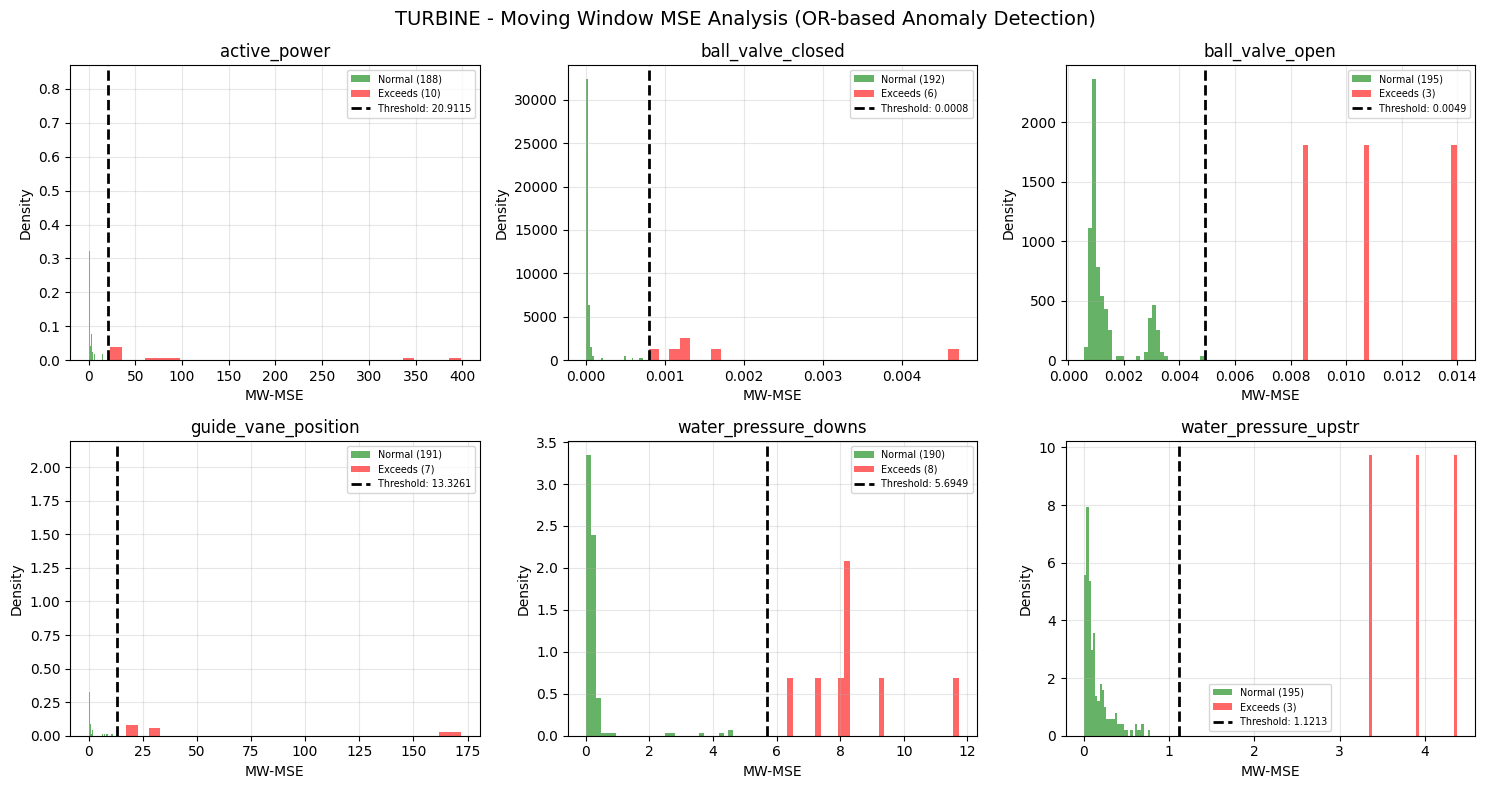

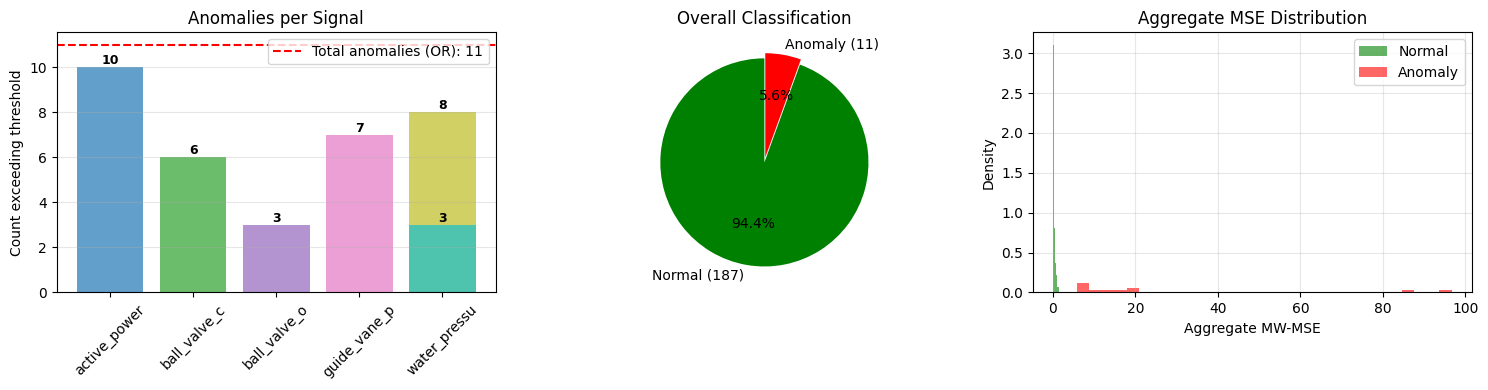

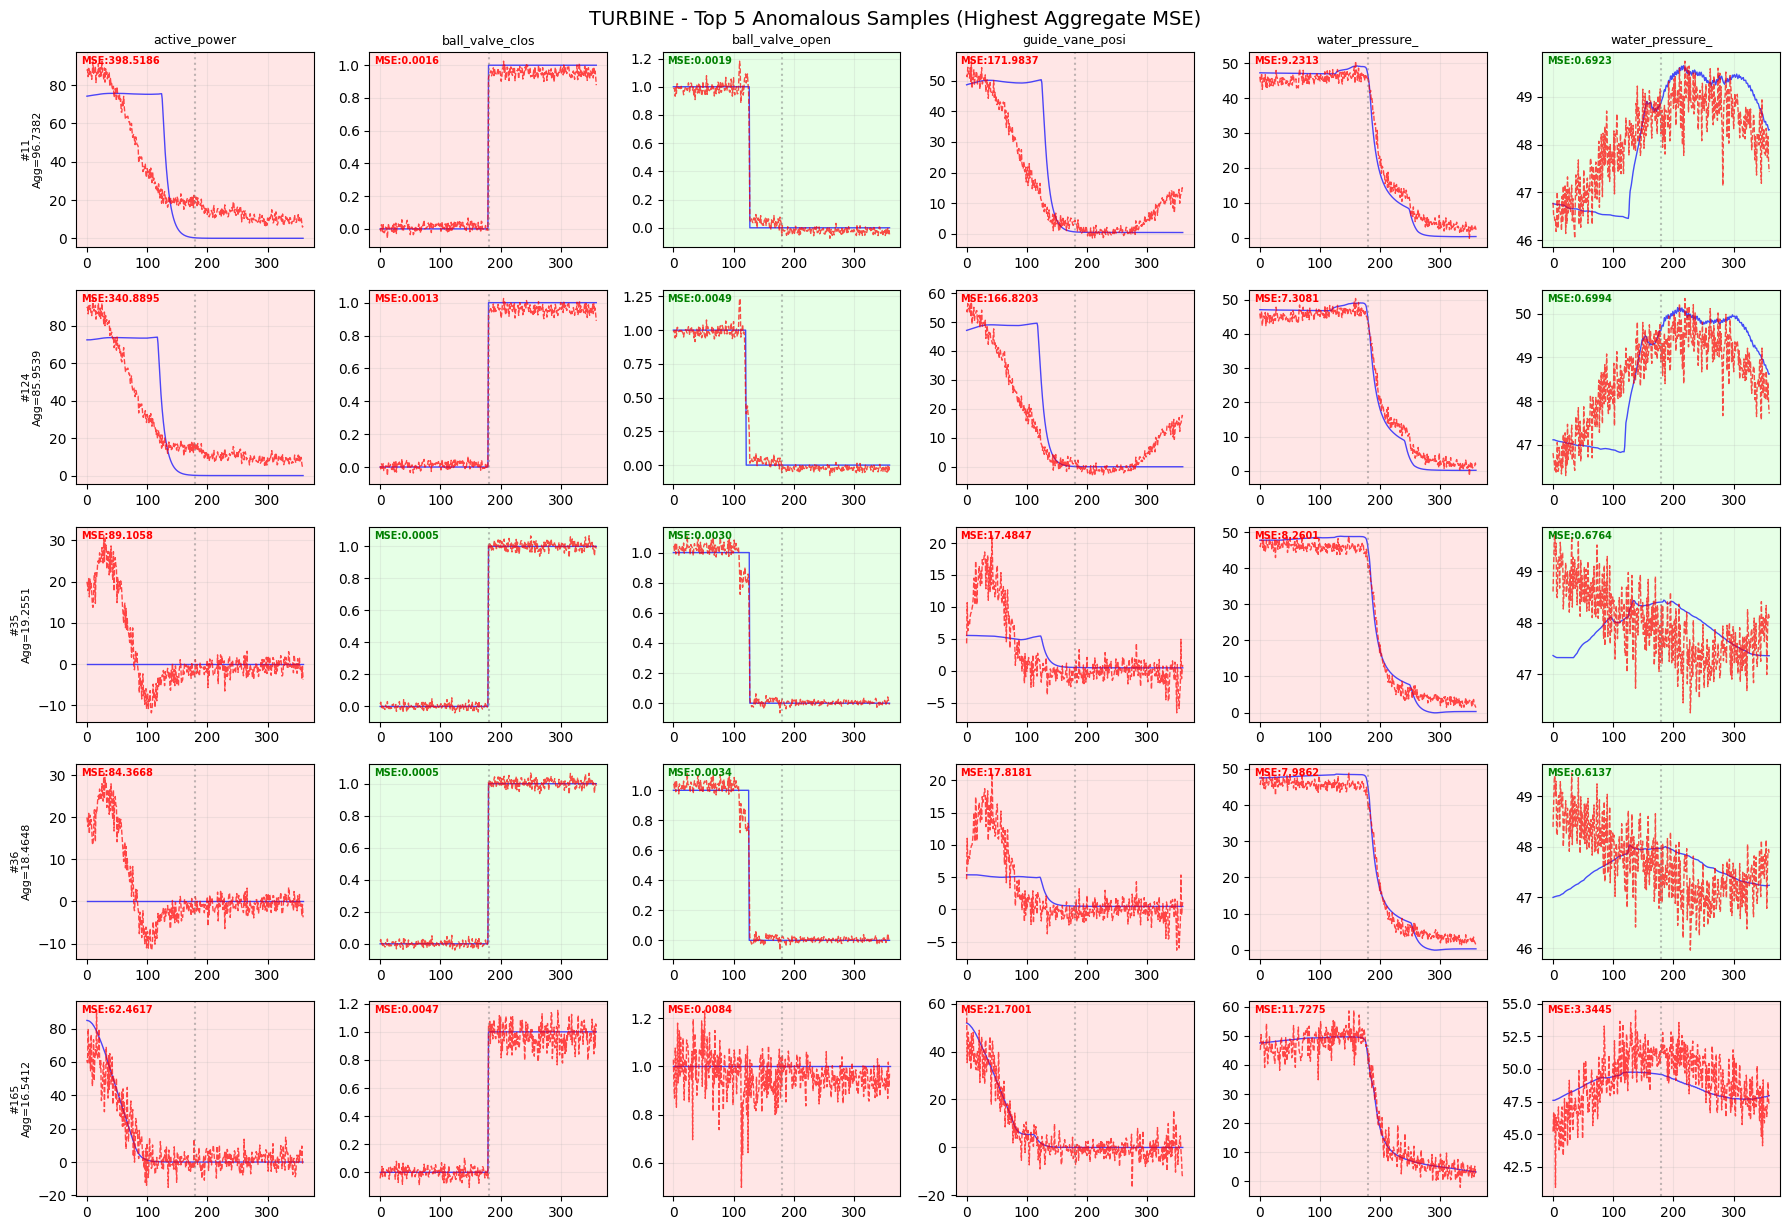


TESTING PUMP AUTOENCODER (Moving Window MSE)
  Train samples: 616
  Test samples: 160
  Window size: 30
  Threshold percentile: 97.5

  Computing thresholds from training data...

  Thresholds (97.5th percentile per signal):
    active_power                  : 62.040318
    ball_valve_closed             : 0.010726
    ball_valve_open               : 0.040401
    guide_vane_position           : 131.793838
    water_pressure_downstream     : 32.666906
    water_pressure_upstream       : 3.327802

  Reconstructing test data...

  RESULTS

  Moving Window MSE (test set):
    Aggregate Mean: 12.959979
    Aggregate Std:  59.950226

  Per-Signal Mean MW-MSE:
    active_power                  : 18.827838 | Exceeds: 9/160
    ball_valve_closed             : 0.002890 | Exceeds: 7/160
    ball_valve_open               : 0.006390 | Exceeds: 4/160
    guide_vane_position           : 49.180246 | Exceeds: 11/160
    water_pressure_downstream     : 9.174672 | Exceeds: 8/160
    water_pressure_upstre

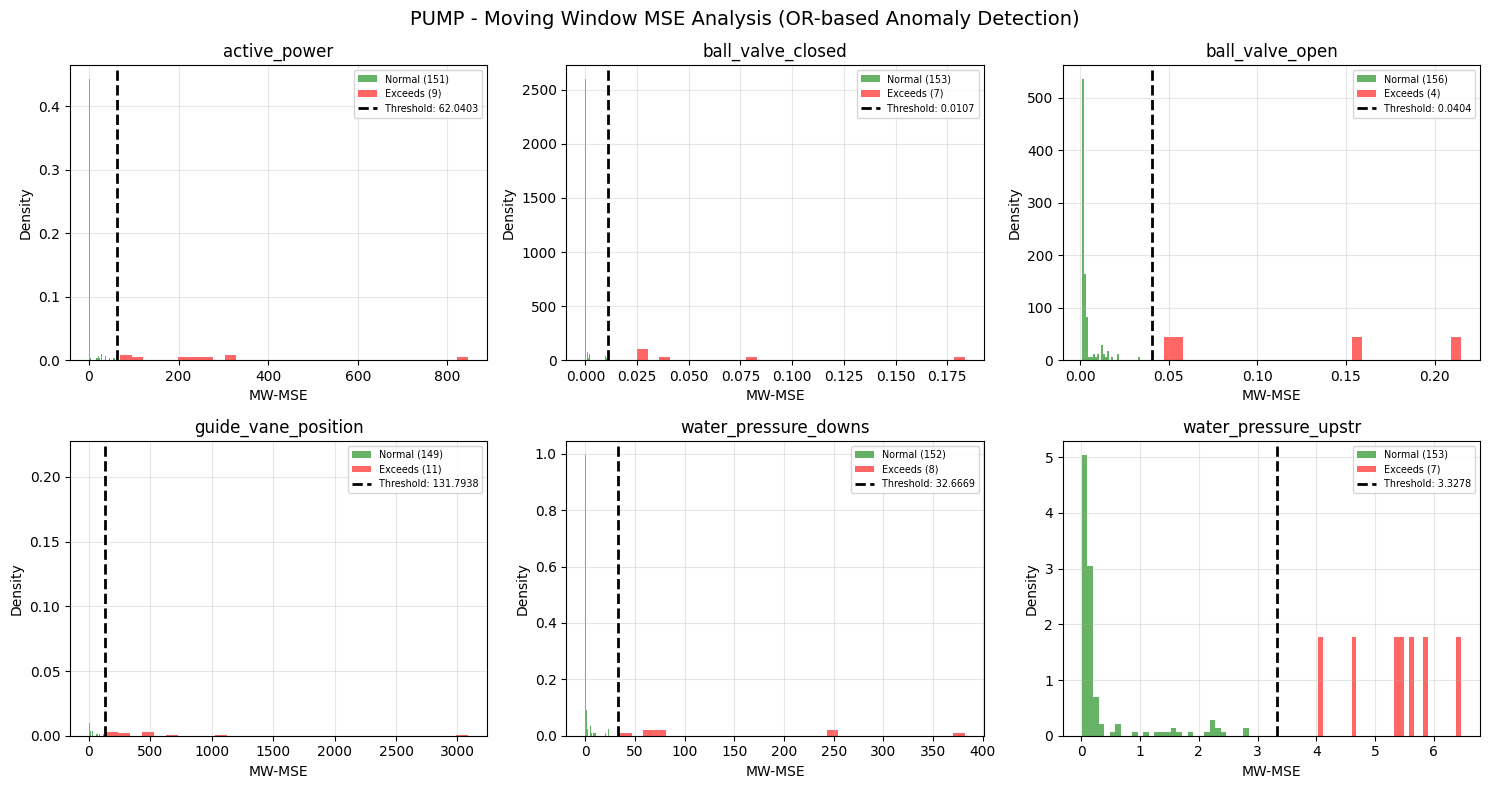

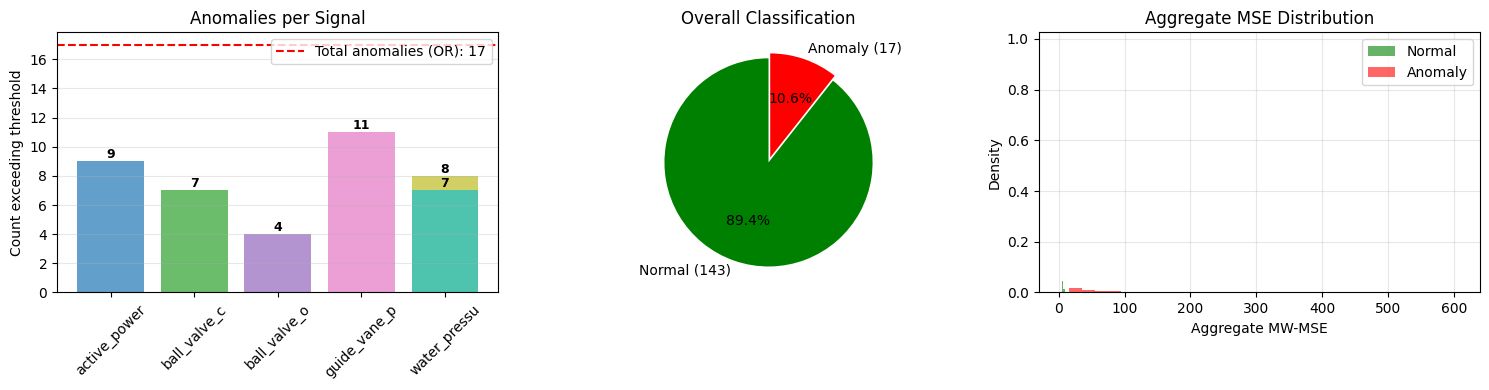

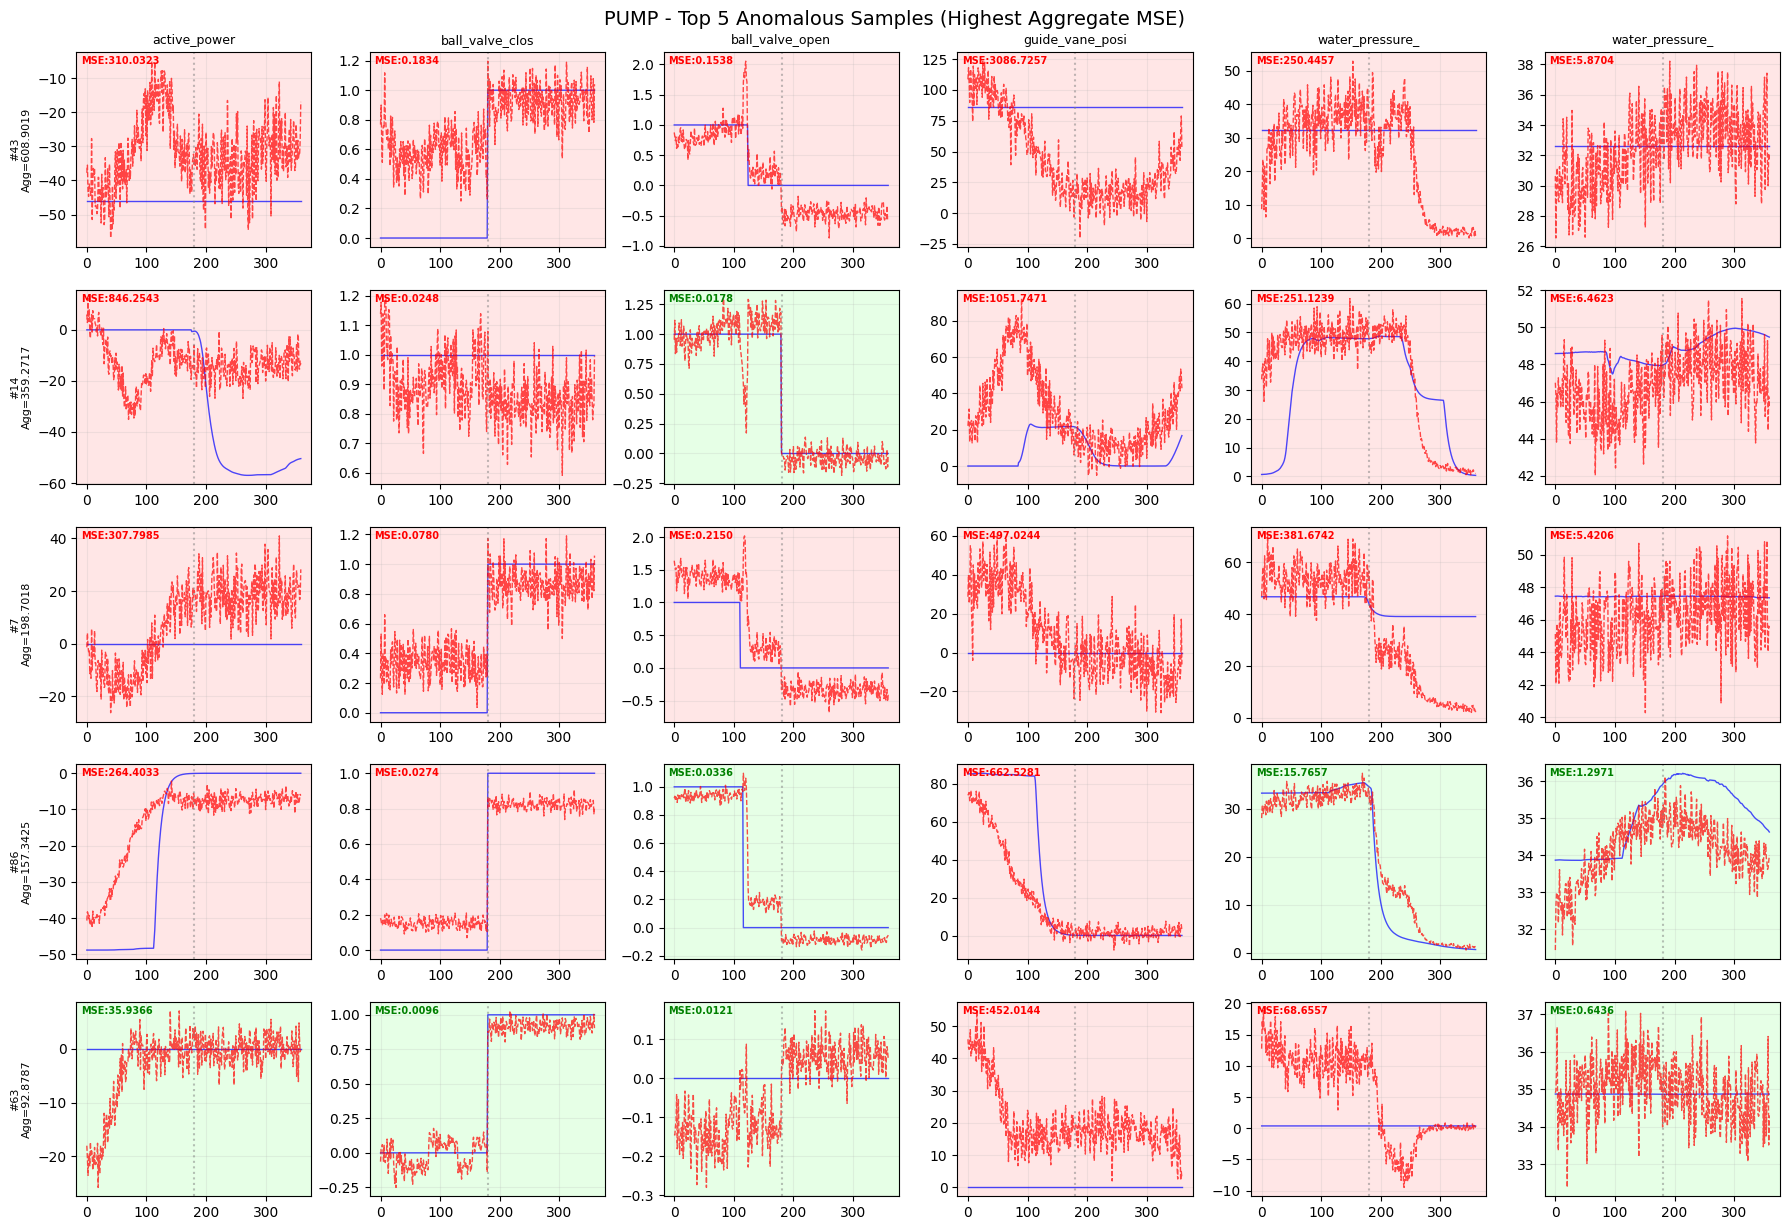


EVALUATION SUMMARY (Moving Window MSE - OR Basis)

Regime       Test     Anomalies    Rate       Threshold Percentile
------------------------------------------------------------
TURBINE      198      11           5.6       % 97.5th
PUMP         160      17           10.6      % 97.5th

✓ Results: test_results_mw['turbine'], test_results_mw['pump']
✓ Access anomaly flags: test_results_mw['turbine']['is_anomaly']
✓ Access per-signal flags: test_results_mw['turbine']['anomaly_per_signal']


In [ ]:
# ==============================================================================
# TEST AUTOENCODERS ON TEST SETS (TURBINE & PUMP)
# ==============================================================================
# Uses Moving Window MSE per signal - Anomaly if ANY signal exceeds threshold
# ==============================================================================

def compute_moving_window_mse_per_signal(X_orig, X_recon, n_signals=6, n_timesteps=360, window_size=30):
    """
    Compute Moving Window MSE per signal.
    
    Args:
        X_orig: (N, n_signals*n_timesteps) original signals (flattened)
        X_recon: (N, n_signals*n_timesteps) reconstructed signals (flattened)
        n_signals: Number of signals (default: 6)
        n_timesteps: Number of timesteps per signal (default: 360)
        window_size: Size of the moving window in timesteps (default: 30)
    
    Returns:
        mse_per_signal: (N, n_signals) array of moving window MSE per signal per sample
    """
    N = len(X_orig)
    
    # Reshape to (N, n_timesteps, n_signals)
    orig_3d = X_orig.reshape(N, n_timesteps, n_signals)
    recon_3d = X_recon.reshape(N, n_timesteps, n_signals)
    
    mse_per_signal = np.zeros((N, n_signals))
    
    for sig_idx in range(n_signals):
        for i in range(N):
            orig_sig = orig_3d[i, :, sig_idx]
            recon_sig = recon_3d[i, :, sig_idx]
            
            # Compute MSE for each window
            window_losses = []
            for w in range(n_timesteps - window_size + 1):
                orig_window = orig_sig[w:w+window_size]
                recon_window = recon_sig[w:w+window_size]
                window_mse = np.mean((orig_window - recon_window) ** 2)
                window_losses.append(window_mse)
            
            # Average across all windows for this signal
            mse_per_signal[i, sig_idx] = np.mean(window_losses)
    
    return mse_per_signal


def test_regime_autoencoder_mw(model, scaler, X_train, X_test, regime_name, 
                                n_signals=6, n_timesteps=360, window_size=30, percentile=97.5):
    """
    Test autoencoder using Moving Window MSE per signal with OR-based anomaly detection.
    
    Anomaly rule: Sample is anomaly if ANY signal's MW-MSE exceeds its threshold.
    
    Args:
        model: Trained autoencoder
        scaler: Fitted MinMaxScaler
        X_train: Training data (for computing thresholds)
        X_test: Test data
        regime_name: 'turbine' or 'pump'
        percentile: Threshold percentile (default: 97.5)
    
    Returns:
        results: dict with all metrics and flags
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"\n{'='*60}")
    print(f"TESTING {regime_name.upper()} AUTOENCODER (Moving Window MSE)")
    print(f"{'='*60}")
    print(f"  Train samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")
    print(f"  Window size: {window_size}")
    print(f"  Threshold percentile: {percentile}")
    
    if len(X_test) == 0:
        print(f"  ⚠️ No test samples for {regime_name}")
        return None
    
    model.eval()
    
    # =========================================================================
    # STEP 1: Compute thresholds from TRAINING data
    # =========================================================================
    print(f"\n  Computing thresholds from training data...")
    
    X_train_scaled = scaler.transform(X_train)
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_train_scaled).to(device)
        X_train_recon_scaled, _ = model(X_tensor)
        X_train_recon_scaled = X_train_recon_scaled.cpu().numpy()
    X_train_recon = scaler.inverse_transform(X_train_recon_scaled)
    
    # Moving Window MSE per signal on training data
    mw_mse_train = compute_moving_window_mse_per_signal(X_train, X_train_recon, n_signals, n_timesteps, window_size)
    
    # Compute threshold per signal
    thresholds = np.percentile(mw_mse_train, percentile, axis=0)  # (n_signals,)
    
    print(f"\n  Thresholds ({percentile}th percentile per signal):")
    for i, sig in enumerate(SIGNALS):
        print(f"    {sig:<30}: {thresholds[i]:.6f}")
    
    # =========================================================================
    # STEP 2: Reconstruct TEST data
    # =========================================================================
    print(f"\n  Reconstructing test data...")
    
    X_test_scaled = scaler.transform(X_test)
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_test_scaled).to(device)
        X_test_recon_scaled, latent = model(X_tensor)
        X_test_recon_scaled = X_test_recon_scaled.cpu().numpy()
        latent = latent.cpu().numpy()
    X_test_recon = scaler.inverse_transform(X_test_recon_scaled)
    
    # Moving Window MSE per signal on test data
    mw_mse_test = compute_moving_window_mse_per_signal(X_test, X_test_recon, n_signals, n_timesteps, window_size)
    
    # =========================================================================
    # STEP 3: Flag anomalies (OR basis - ANY signal exceeds threshold)
    # =========================================================================
    anomaly_per_signal = mw_mse_test > thresholds  # (N, n_signals) boolean
    is_anomaly = anomaly_per_signal.any(axis=1)    # (N,) - OR across signals
    
    # Aggregate MSE (mean across signals)
    mse_aggregate = mw_mse_test.mean(axis=1)
    
    # =========================================================================
    # STEP 4: Print results
    # =========================================================================
    print(f"\n  {'='*50}")
    print(f"  RESULTS")
    print(f"  {'='*50}")
    
    print(f"\n  Moving Window MSE (test set):")
    print(f"    Aggregate Mean: {mse_aggregate.mean():.6f}")
    print(f"    Aggregate Std:  {mse_aggregate.std():.6f}")
    
    print(f"\n  Per-Signal Mean MW-MSE:")
    for i, sig in enumerate(SIGNALS):
        mean_mse = mw_mse_test[:, i].mean()
        n_exceed = anomaly_per_signal[:, i].sum()
        print(f"    {sig:<30}: {mean_mse:.6f} | Exceeds: {n_exceed}/{len(X_test)}")
    
    print(f"\n  ANOMALY DETECTION (OR basis):")
    print(f"    Total anomalies: {is_anomaly.sum()} / {len(is_anomaly)} ({100*is_anomaly.mean():.1f}%)")
    print(f"    Normal samples:  {(~is_anomaly).sum()} / {len(is_anomaly)} ({100*(~is_anomaly).mean():.1f}%)")
    
    # Breakdown by signal contribution
    print(f"\n  Anomalies contributed by each signal:")
    for i, sig in enumerate(SIGNALS):
        n_contrib = anomaly_per_signal[:, i].sum()
        pct = 100 * n_contrib / len(X_test)
        print(f"    {sig:<30}: {n_contrib:4d} ({pct:5.1f}%)")
    
    return {
        'X_test': X_test,
        'X_recon': X_test_recon,
        'latent': latent,
        'mw_mse_train': mw_mse_train,
        'mw_mse_test': mw_mse_test,
        'thresholds': thresholds,
        'anomaly_per_signal': anomaly_per_signal,
        'is_anomaly': is_anomaly,
        'mse_aggregate': mse_aggregate,
    }


def plot_test_results_mw(results, regime_name, n_examples=5):
    """Plot test results with Moving Window MSE analysis."""
    if results is None:
        print(f"No results to plot for {regime_name}")
        return
    
    X_test = results['X_test']
    X_recon = results['X_recon']
    mw_mse_test = results['mw_mse_test']
    thresholds = results['thresholds']
    anomaly_per_signal = results['anomaly_per_signal']
    is_anomaly = results['is_anomaly']
    mse_aggregate = results['mse_aggregate']
    
    n_signals = len(SIGNALS)
    n_timesteps = 360
    
    # =========================================================================
    # FIGURE 1: MW-MSE Distribution and Thresholds
    # =========================================================================
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'{regime_name.upper()} - Moving Window MSE Analysis (OR-based Anomaly Detection)', fontsize=14)
    
    for i, sig in enumerate(SIGNALS):
        ax = axes[i // 3, i % 3]
        
        # Split normal vs anomaly based on this signal
        sig_normal = mw_mse_test[~anomaly_per_signal[:, i], i]
        sig_anomaly = mw_mse_test[anomaly_per_signal[:, i], i]
        
        # Plot histograms
        if len(sig_normal) > 0:
            ax.hist(sig_normal, bins=30, alpha=0.6, color='green', label=f'Normal ({len(sig_normal)})', density=True)
        if len(sig_anomaly) > 0:
            ax.hist(sig_anomaly, bins=30, alpha=0.6, color='red', label=f'Exceeds ({len(sig_anomaly)})', density=True)
        
        # Threshold line
        ax.axvline(thresholds[i], color='black', linestyle='--', linewidth=2, label=f'Threshold: {thresholds[i]:.4f}')
        
        ax.set_xlabel('MW-MSE')
        ax.set_ylabel('Density')
        ax.set_title(f'{sig[:20]}')
        ax.legend(fontsize='x-small')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # FIGURE 2: Anomaly Breakdown
    # =========================================================================
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Anomaly count per signal
    ax = axes[0]
    counts = anomaly_per_signal.sum(axis=0)
    colors = plt.cm.tab10(np.linspace(0, 1, n_signals))
    bars = ax.bar([s[:12] for s in SIGNALS], counts, color=colors, alpha=0.7)
    ax.axhline(is_anomaly.sum(), color='red', linestyle='--', label=f'Total anomalies (OR): {is_anomaly.sum()}')
    ax.set_ylabel('Count exceeding threshold')
    ax.set_title('Anomalies per Signal')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{count}', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. Normal vs Anomaly pie
    ax = axes[1]
    n_anom = is_anomaly.sum()
    n_normal = (~is_anomaly).sum()
    ax.pie([n_normal, n_anom], labels=[f'Normal ({n_normal})', f'Anomaly ({n_anom})'],
           colors=['green', 'red'], autopct='%1.1f%%', startangle=90, explode=[0, 0.05])
    ax.set_title('Overall Classification')
    
    # 3. Aggregate MSE distribution
    ax = axes[2]
    ax.hist(mse_aggregate[~is_anomaly], bins=30, alpha=0.6, color='green', label='Normal', density=True)
    ax.hist(mse_aggregate[is_anomaly], bins=30, alpha=0.6, color='red', label='Anomaly', density=True)
    ax.set_xlabel('Aggregate MW-MSE')
    ax.set_ylabel('Density')
    ax.set_title('Aggregate MSE Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # FIGURE 3: Example Anomalous Reconstructions
    # =========================================================================
    anomaly_indices = np.where(is_anomaly)[0]
    if len(anomaly_indices) == 0:
        print(f"  No anomalies detected for {regime_name}")
        return
    
    n_plot = min(n_examples, len(anomaly_indices))
    # Sort by aggregate MSE to show worst first
    sorted_anom_idx = anomaly_indices[np.argsort(mse_aggregate[anomaly_indices])[::-1]]
    
    fig, axes = plt.subplots(n_plot, n_signals, figsize=(3*n_signals, 2.5*n_plot))
    fig.suptitle(f'{regime_name.upper()} - Top {n_plot} Anomalous Samples (Highest Aggregate MSE)', fontsize=14)
    
    if n_plot == 1:
        axes = axes.reshape(1, -1)
    
    for row, idx in enumerate(sorted_anom_idx[:n_plot]):
        orig = X_test[idx].reshape(n_timesteps, n_signals)
        recon = X_recon[idx].reshape(n_timesteps, n_signals)
        
        for col, sig in enumerate(SIGNALS):
            ax = axes[row, col]
            ax.plot(orig[:, col], 'b-', alpha=0.7, linewidth=1, label='Original')
            ax.plot(recon[:, col], 'r--', alpha=0.7, linewidth=1, label='Reconstructed')
            ax.axvline(n_timesteps//2, color='gray', linestyle=':', alpha=0.5)
            
            # Highlight if this signal exceeds threshold
            sig_mse = mw_mse_test[idx, col]
            exceeds = anomaly_per_signal[idx, col]
            color = 'red' if exceeds else 'green'
            ax.set_facecolor((1, 0.9, 0.9) if exceeds else (0.9, 1, 0.9))
            
            if row == 0:
                ax.set_title(f'{sig[:15]}', fontsize=9)
            if col == 0:
                ax.set_ylabel(f'#{idx}\nAgg={mse_aggregate[idx]:.4f}', fontsize=8)
            
            # Show per-signal MSE
            ax.text(0.02, 0.98, f'MSE:{sig_mse:.4f}', transform=ax.transAxes, 
                   fontsize=7, va='top', color=color, fontweight='bold')
            
            ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()


# ==============================================================================
# RUN TESTS
# ==============================================================================
print("="*60)
print("AUTOENCODER EVALUATION - MOVING WINDOW MSE (OR BASIS)")
print("="*60)
print("Rule: Sample is ANOMALY if ANY signal's MW-MSE exceeds its threshold")

test_results_mw = {}

# Test TURBINE
if 'turbine' in results_regime and len(X_test_turbine) > 0:
    test_results_mw['turbine'] = test_regime_autoencoder_mw(
        model=results_regime['turbine']['model'],
        scaler=results_regime['turbine']['scaler'],
        X_train=X_train_turbine,
        X_test=X_test_turbine,
        regime_name='turbine',
        percentile=97.5
    )
    plot_test_results_mw(test_results_mw['turbine'], 'turbine', n_examples=5)
else:
    print("\n⚠️ TURBINE: No model or test data available")

# Test PUMP
if 'pump' in results_regime and len(X_test_pump) > 0:
    test_results_mw['pump'] = test_regime_autoencoder_mw(
        model=results_regime['pump']['model'],
        scaler=results_regime['pump']['scaler'],
        X_train=X_train_pump,
        X_test=X_test_pump,
        regime_name='pump',
        percentile=97.5
    )
    plot_test_results_mw(test_results_mw['pump'], 'pump', n_examples=5)
else:
    print("\n⚠️ PUMP: No model or test data available")


# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "="*60)
print("EVALUATION SUMMARY (Moving Window MSE - OR Basis)")
print("="*60)
print(f"\n{'Regime':<12} {'Test':<8} {'Anomalies':<12} {'Rate':<10} {'Threshold Percentile'}")
print("-"*60)

for regime in ['turbine', 'pump']:
    if regime in test_results_mw and test_results_mw[regime] is not None:
        res = test_results_mw[regime]
        n_test = len(res['is_anomaly'])
        n_anom = res['is_anomaly'].sum()
        rate = 100 * n_anom / n_test
        print(f"{regime.upper():<12} {n_test:<8} {n_anom:<12} {rate:<10.1f}% 97.5th")
    else:
        print(f"{regime.upper():<12} {'N/A':<8} {'N/A':<12} {'N/A':<10}")

print("="*60)
print("\n✓ Results: test_results_mw['turbine'], test_results_mw['pump']")
print("✓ Access anomaly flags: test_results_mw['turbine']['is_anomaly']")
print("✓ Access per-signal flags: test_results_mw['turbine']['anomaly_per_signal']")

## Hyperparameter tuning using Optuna 

Using Optuna to tune our hyperparameters

[I 2025-12-17 23:06:20,963] A new study created in memory with name: turbine_autoencoder_tuning


Checking data availability...
  ✓ TURBINE: 948 training samples
  ✓ PUMP: 616 training samples

HYPERPARAMETER TUNING WITH OPTUNA - REGIME-SPECIFIC

Configuration:
  - Trials per regime: 30
  - Max epochs per trial: 40
  - Early stopping patience: 8

Loss Function: HYBRID (Uniform MSE + Transition-Weighted MSE)
  - Uniform weight (λ): 1.0
  - Gaussian amplitude: 4.0

Search Space:
  - learning_rate: [1e-5, 1e-2] (log-uniform)
  - weight_decay: [1e-6, 1e-2] (log-uniform)
  - bottleneck_dim: [16, 32, 64, 128]
  - noise_std: [0.0, 0.3] (uniform)
  - smooth_lambda: [1e-6, 1e-2] (log-uniform)
  - hidden1: [256, 512, 1024]
  - hidden2: [64, 128, 256]
  - batch_size: [32, 64, 128]

OPTIMIZING TURBINE AUTOENCODER
Training samples: 948
Input dimension: 2160

Running 30 optimization trials...


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:26,983] Trial 0 finished with value: 0.005456291216736038 and parameters: {'learning_rate': 0.0004334540740542016, 'weight_decay': 8.311743540628973e-06, 'bottleneck_dim': 16, 'noise_std': 0.09141751027011226, 'smooth_lambda': 1.901375915150406e-05, 'hidden1': 1024, 'hidden2': 256, 'batch_size': 64}. Best is trial 0 with value: 0.005456291216736038.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:37,155] Trial 1 finished with value: 0.00883093278389424 and parameters: {'learning_rate': 0.009001431736568916, 'weight_decay': 9.504223605582928e-05, 'bottleneck_dim': 16, 'noise_std': 0.2566168372184244, 'smooth_lambda': 1.0999241859008186e-05, 'hidden1': 1024, 'hidden2': 128, 'batch_size': 32}. Best is trial 0 with value: 0.005456291216736038.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:40,389] Trial 2 finished with value: 0.6382533311843872 and parameters: {'learning_rate': 4.909798653936483e-05, 'weight_decay': 0.00012735336788917686, 'bottleneck_dim': 128, 'noise_std': 0.19896418204439578, 'smooth_lambda': 1.141487749986354e-06, 'hidden1': 1024, 'hidden2': 64, 'batch_size': 128}. Best is trial 0 with value: 0.005456291216736038.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:43,551] Trial 3 finished with value: 0.011441432870924473 and parameters: {'learning_rate': 0.0008445379858334764, 'weight_decay': 0.0024725555677171224, 'bottleneck_dim': 16, 'noise_std': 0.2118403719543193, 'smooth_lambda': 0.00030452410416741577, 'hidden1': 1024, 'hidden2': 128, 'batch_size': 128}. Best is trial 0 with value: 0.005456291216736038.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:51,779] Trial 4 finished with value: 0.004468101037976642 and parameters: {'learning_rate': 0.000480280541165019, 'weight_decay': 6.254514999243159e-06, 'bottleneck_dim': 64, 'noise_std': 0.06157749227367898, 'smooth_lambda': 0.00015455365253803886, 'hidden1': 512, 'hidden2': 128, 'batch_size': 32}. Best is trial 4 with value: 0.004468101037976642.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:56,742] Trial 5 finished with value: 0.004907142603769898 and parameters: {'learning_rate': 0.0006427091133045906, 'weight_decay': 5.3071821753146785e-05, 'bottleneck_dim': 16, 'noise_std': 0.13381475827715347, 'smooth_lambda': 0.0023879518420517527, 'hidden1': 512, 'hidden2': 128, 'batch_size': 64}. Best is trial 4 with value: 0.004468101037976642.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:06:59,498] Trial 6 finished with value: 0.006818079389631748 and parameters: {'learning_rate': 0.003252391351836492, 'weight_decay': 1.115817315364128e-06, 'bottleneck_dim': 128, 'noise_std': 0.13540108880393464, 'smooth_lambda': 4.704348539474739e-06, 'hidden1': 512, 'hidden2': 128, 'batch_size': 128}. Best is trial 4 with value: 0.004468101037976642.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:01,905] Trial 7 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:03,739] Trial 8 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:04,373] Trial 9 finished with value: 0.7625752985477448 and parameters: {'learning_rate': 4.2108500076474964e-05, 'weight_decay': 0.0006872264629144193, 'bottleneck_dim': 64, 'noise_std': 0.10972569232617822, 'smooth_lambda': 0.00018073354812574312, 'hidden1': 512, 'hidden2': 64, 'batch_size': 128}. Best is trial 4 with value: 0.004468101037976642.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:06,452] Trial 10 finished with value: 0.8589004278182983 and parameters: {'learning_rate': 1.1259114681921828e-05, 'weight_decay': 1.1280523497497562e-05, 'bottleneck_dim': 64, 'noise_std': 0.01502557913637008, 'smooth_lambda': 0.0029334658755500714, 'hidden1': 512, 'hidden2': 128, 'batch_size': 32}. Best is trial 4 with value: 0.004468101037976642.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:11,030] Trial 11 finished with value: 0.004489650096123417 and parameters: {'learning_rate': 0.0011607631285948303, 'weight_decay': 1.689844870880967e-05, 'bottleneck_dim': 32, 'noise_std': 0.06855700201381283, 'smooth_lambda': 0.008548664622655895, 'hidden1': 512, 'hidden2': 128, 'batch_size': 64}. Best is trial 4 with value: 0.004468101037976642.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:12,309] Trial 12 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:21,139] Trial 13 finished with value: 0.004441606094284604 and parameters: {'learning_rate': 0.001844701062085178, 'weight_decay': 2.76297594700999e-05, 'bottleneck_dim': 32, 'noise_std': 0.057010364731258714, 'smooth_lambda': 0.006387888898523677, 'hidden1': 512, 'hidden2': 128, 'batch_size': 32}. Best is trial 13 with value: 0.004441606094284604.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:24,161] Trial 14 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:26,646] Trial 15 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:29,011] Trial 16 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:31,583] Trial 17 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:36,676] Trial 18 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:38,923] Trial 19 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:41,798] Trial 20 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:46,197] Trial 21 finished with value: 0.005357309089352687 and parameters: {'learning_rate': 0.0010540666834998264, 'weight_decay': 1.5229791634879971e-05, 'bottleneck_dim': 32, 'noise_std': 0.0865222600947843, 'smooth_lambda': 0.008230802121522815, 'hidden1': 512, 'hidden2': 128, 'batch_size': 64}. Best is trial 13 with value: 0.004441606094284604.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:50,662] Trial 22 finished with value: 0.00473522658770283 and parameters: {'learning_rate': 0.0011304827402476441, 'weight_decay': 3.632344087603887e-06, 'bottleneck_dim': 32, 'noise_std': 0.05541239564382745, 'smooth_lambda': 0.0037381782874529204, 'hidden1': 512, 'hidden2': 128, 'batch_size': 64}. Best is trial 13 with value: 0.004441606094284604.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:07:51,964] Trial 23 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:00,703] Trial 24 finished with value: 0.004287386953365058 and parameters: {'learning_rate': 0.0005412496274257889, 'weight_decay': 4.9205110848490564e-05, 'bottleneck_dim': 32, 'noise_std': 0.11605095976067355, 'smooth_lambda': 0.0006037313766358993, 'hidden1': 512, 'hidden2': 128, 'batch_size': 32}. Best is trial 24 with value: 0.004287386953365058.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:05,599] Trial 25 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:12,097] Trial 26 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:17,117] Trial 27 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:20,120] Trial 28 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-12-17 23:08:23,009] A new study created in memory with name: pump_autoencoder_tuning


[I 2025-12-17 23:08:22,986] Trial 29 pruned. 

  Best Trial #24:
    Validation Hybrid Loss: 0.004287

  Best Hyperparameters:
    learning_rate: 0.00054125
    weight_decay: 4.92051e-05
    bottleneck_dim: 32
    noise_std: 0.116051
    smooth_lambda: 0.000603731
    hidden1: 512
    hidden2: 128
    batch_size: 32

  Trial Statistics:
    Completed: 14
    Pruned: 16

OPTIMIZING PUMP AUTOENCODER
Training samples: 616
Input dimension: 2160

Running 30 optimization trials...


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:23,920] Trial 0 finished with value: 0.752353847026825 and parameters: {'learning_rate': 1.5242022298463973e-05, 'weight_decay': 0.00442995623170824, 'bottleneck_dim': 64, 'noise_std': 0.016516715739117394, 'smooth_lambda': 9.94491007851546e-06, 'hidden1': 1024, 'hidden2': 64, 'batch_size': 64}. Best is trial 0 with value: 0.752353847026825.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:27,130] Trial 1 finished with value: 0.007157407933846116 and parameters: {'learning_rate': 0.0007220319998846555, 'weight_decay': 0.00011286980146034426, 'bottleneck_dim': 16, 'noise_std': 0.05288026096558838, 'smooth_lambda': 7.258572765855732e-05, 'hidden1': 512, 'hidden2': 256, 'batch_size': 64}. Best is trial 1 with value: 0.007157407933846116.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:27,784] Trial 2 finished with value: 0.8143118023872375 and parameters: {'learning_rate': 1.6277126576794754e-05, 'weight_decay': 0.0009164432427037282, 'bottleneck_dim': 128, 'noise_std': 0.10400507868387009, 'smooth_lambda': 2.6556773654251718e-06, 'hidden1': 512, 'hidden2': 256, 'batch_size': 128}. Best is trial 1 with value: 0.007157407933846116.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:34,945] Trial 3 finished with value: 0.006775887100957334 and parameters: {'learning_rate': 0.00022327643907364868, 'weight_decay': 9.833189112168405e-06, 'bottleneck_dim': 16, 'noise_std': 0.06898573257450286, 'smooth_lambda': 1.4813568339055868e-06, 'hidden1': 1024, 'hidden2': 256, 'batch_size': 32}. Best is trial 3 with value: 0.006775887100957334.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:37,997] Trial 4 finished with value: 0.03646280616521835 and parameters: {'learning_rate': 0.00029083433890344693, 'weight_decay': 3.810633705815136e-05, 'bottleneck_dim': 32, 'noise_std': 0.09560019739323565, 'smooth_lambda': 0.00607939413215994, 'hidden1': 512, 'hidden2': 64, 'batch_size': 64}. Best is trial 3 with value: 0.006775887100957334.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:40,865] Trial 5 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:41,466] Trial 6 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:46,424] Trial 7 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:47,204] Trial 8 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:47,663] Trial 9 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:49,687] Trial 10 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:50,589] Trial 11 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:51,461] Trial 12 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:53,920] Trial 13 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:08:54,598] Trial 14 finished with value: 0.7404322624206543 and parameters: {'learning_rate': 5.17729832766127e-05, 'weight_decay': 1.2820048611045077e-06, 'bottleneck_dim': 16, 'noise_std': 0.07523218964972689, 'smooth_lambda': 0.005542552752501803, 'hidden1': 256, 'hidden2': 256, 'batch_size': 64}. Best is trial 3 with value: 0.006775887100957334.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:01,353] Trial 15 finished with value: 0.005753438570536673 and parameters: {'learning_rate': 0.0005774411144591785, 'weight_decay': 7.473737891365191e-06, 'bottleneck_dim': 16, 'noise_std': 0.12512241412624045, 'smooth_lambda': 4.9431979514461594e-05, 'hidden1': 1024, 'hidden2': 128, 'batch_size': 32}. Best is trial 15 with value: 0.005753438570536673.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:08,225] Trial 16 finished with value: 0.005686526244971901 and parameters: {'learning_rate': 0.00030067815287603683, 'weight_decay': 6.283373256519928e-06, 'bottleneck_dim': 16, 'noise_std': 0.16413382055431308, 'smooth_lambda': 1.1568586126236681e-06, 'hidden1': 1024, 'hidden2': 128, 'batch_size': 32}. Best is trial 16 with value: 0.005686526244971901.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:11,595] Trial 17 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:13,770] Trial 18 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:16,135] Trial 19 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:23,047] Trial 20 finished with value: 0.006075565353967249 and parameters: {'learning_rate': 0.0004478673787200834, 'weight_decay': 3.2732410192268076e-05, 'bottleneck_dim': 16, 'noise_std': 0.20223196158641393, 'smooth_lambda': 3.273686635292378e-05, 'hidden1': 1024, 'hidden2': 128, 'batch_size': 32}. Best is trial 16 with value: 0.005686526244971901.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:28,503] Trial 21 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:31,695] Trial 22 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:33,762] Trial 23 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:37,328] Trial 24 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:42,587] Trial 25 finished with value: 0.00597759144147858 and parameters: {'learning_rate': 0.0014302469671797237, 'weight_decay': 5.120733196249437e-06, 'bottleneck_dim': 16, 'noise_std': 0.154828965183762, 'smooth_lambda': 2.8242636606538977e-06, 'hidden1': 256, 'hidden2': 128, 'batch_size': 32}. Best is trial 16 with value: 0.005686526244971901.


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:45,506] Trial 26 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:48,831] Trial 27 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:51,277] Trial 28 pruned. 


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[I 2025-12-17 23:09:51,851] Trial 29 pruned. 

  Best Trial #16:
    Validation Hybrid Loss: 0.005687

  Best Hyperparameters:
    learning_rate: 0.000300678
    weight_decay: 6.28337e-06
    bottleneck_dim: 16
    noise_std: 0.164134
    smooth_lambda: 1.15686e-06
    hidden1: 1024
    hidden2: 128
    batch_size: 32

  Trial Statistics:
    Completed: 10
    Pruned: 20

VISUALIZATION


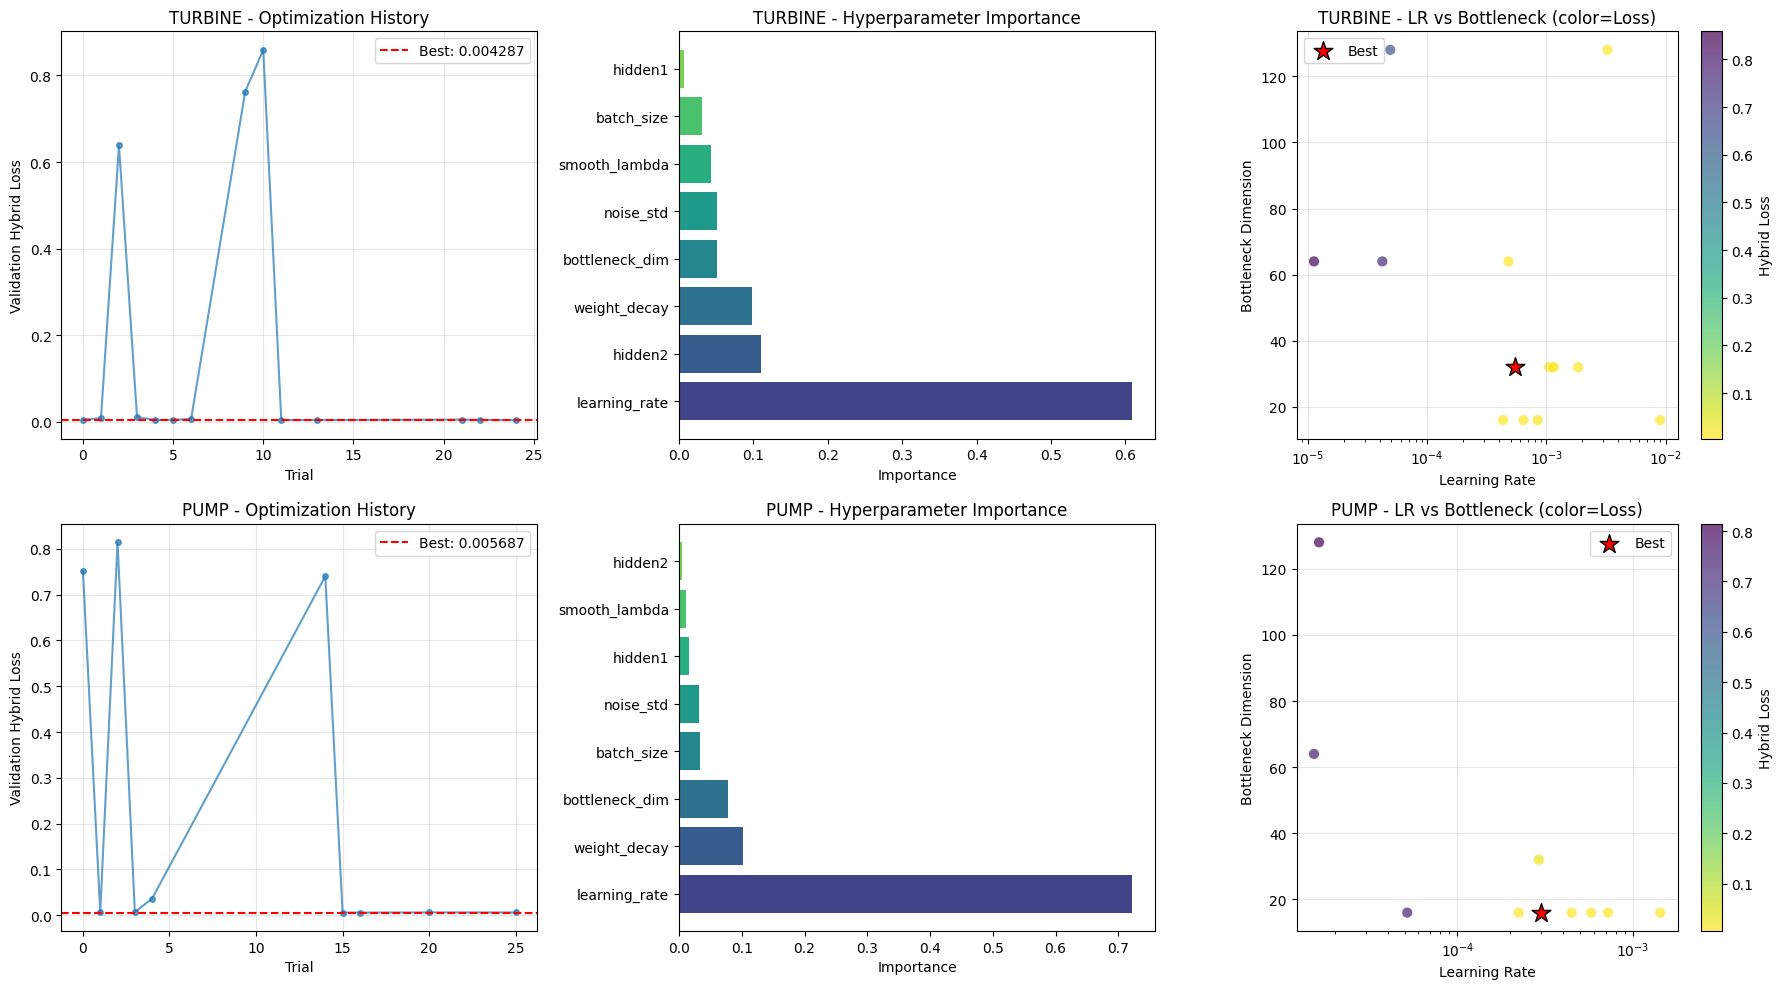


OPTIMIZED HYPERPARAMETERS - COPY TO YOUR TRAINING CELL

# TURBINE Autoencoder - Optimized Hyperparameters (Trial #24)
# Best Validation Hybrid Loss: 0.004287
LEARNING_RATE_TURBINE = 0.00054125
WEIGHT_DECAY_TURBINE = 4.92051e-05
BOTTLENECK_DIM_TURBINE = 32
NOISE_STD_TURBINE = 0.1161
SMOOTH_LAMBDA_TURBINE = 0.000603731
HIDDEN1_TURBINE = 512
HIDDEN2_TURBINE = 128
BATCH_SIZE_TURBINE = 32

# PUMP Autoencoder - Optimized Hyperparameters (Trial #16)
# Best Validation Hybrid Loss: 0.005687
LEARNING_RATE_PUMP = 0.000300678
WEIGHT_DECAY_PUMP = 6.28337e-06
BOTTLENECK_DIM_PUMP = 16
NOISE_STD_PUMP = 0.1641
SMOOTH_LAMBDA_PUMP = 1.15686e-06
HIDDEN1_PUMP = 1024
HIDDEN2_PUMP = 128
BATCH_SIZE_PUMP = 32

SUMMARY COMPARISON

Regime       Best Loss    LR           Bottleneck   Hidden1    Hidden2   
----------------------------------------------------------------------
TURBINE      0.004287     0.00054125   32           512        128       
PUMP         0.005687     0.000300678  16           1024       12

In [14]:
# ==============================================================================
# HYPERPARAMETER TUNING WITH OPTUNA - REGIME-SPECIFIC (TURBINE & PUMP)
# ==============================================================================
# Uses HYBRID LOSS (Uniform MSE + Transition-Weighted MSE) - consistent with training
# Model architecture matches DenseAutoencoderCombined
# ==============================================================================

N_TRIALS = 30  # Number of trials per regime
N_EPOCHS_PER_TRIAL = 40
EARLY_STOPPING_PATIENCE = 8

# Hybrid Loss Configuration (same as training)
W_AMP_OPTUNA = 4.0
LAM_UNIFORM_OPTUNA = 1.0

# ==============================================================================
# VERIFY DATA IS LOADED
# ==============================================================================
print("Checking data availability...")
data_available = {}

if 'X_train_turbine' in globals() and X_train_turbine is not None and len(X_train_turbine) >= 10:
    data_available['turbine'] = X_train_turbine
    print(f"  ✓ TURBINE: {len(X_train_turbine)} training samples")
else:
    print(f"  ✗ TURBINE: No training data available")

if 'X_train_pump' in globals() and X_train_pump is not None and len(X_train_pump) >= 10:
    data_available['pump'] = X_train_pump
    print(f"  ✓ PUMP: {len(X_train_pump)} training samples")
else:
    print(f"  ✗ PUMP: No training data available")

if not data_available:
    raise RuntimeError("No training data available. Run the data loading cell first.")

# ==============================================================================
# AUTOENCODER ARCHITECTURE - MATCHES DenseAutoencoderCombined (NO activations)
# ==============================================================================
class TunableAutoencoder(nn.Module):
    """Dense Autoencoder matching DenseAutoencoderCombined architecture."""
    def __init__(self, input_dim, latent_dim, h1, h2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.Linear(h2, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, h2),
            nn.BatchNorm1d(h2),
            nn.Linear(h2, h1),
            nn.BatchNorm1d(h1),
            nn.Linear(h1, input_dim),
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent), latent

# ==============================================================================
# HYBRID LOSS FUNCTIONS (SAME AS TRAINING)
# ==============================================================================
def make_time_weights_optuna(n_timesteps, w_amp=4.0, sigma=None, device='cpu'):
    """Create Gaussian time weights peaked at transition center."""
    sigma = sigma or n_timesteps / 20
    t = torch.arange(n_timesteps, device=device, dtype=torch.float32)
    t0 = n_timesteps // 2
    w = 1 + w_amp * torch.exp(-((t - t0)**2) / (2 * sigma**2))
    return w.view(1, n_timesteps)


def compute_hybrid_loss_optuna(recon, target, time_weights, n_signals=6, n_timesteps=360, lam_uniform=1.0):
    """
    Compute HYBRID loss: Uniform MSE + Transition-Weighted MSE.
    L_total = lam_uniform * L_uniform + L_weighted
    """
    batch_size = recon.shape[0]
    
    recon_3d = recon.view(batch_size, n_timesteps, n_signals)
    target_3d = target.view(batch_size, n_timesteps, n_signals)
    
    sq_err = (recon_3d - target_3d) ** 2
    
    # Uniform MSE
    L_uniform = sq_err.mean()
    
    # Weighted MSE (emphasize transition region)
    w = time_weights.unsqueeze(-1)
    weighted_sq_err = w * sq_err
    L_weighted = weighted_sq_err.sum(dim=(1, 2)).mean() / (time_weights.sum() * n_signals)
    
    L_total = lam_uniform * L_uniform + L_weighted
    return L_total

# ==============================================================================
# OBJECTIVE FUNCTION FACTORY
# ==============================================================================
def create_objective(X_train, regime_name):
    """Create an objective function for a specific regime."""
    
    n_signals = X_train.shape[1] // 360
    n_timesteps = 360
    
    def objective(trial):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # ---------------------------------------------------------------------
        # HYPERPARAMETER SEARCH SPACE
        # ---------------------------------------------------------------------
        lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
        bottleneck_dim = trial.suggest_categorical('bottleneck_dim', [16, 32, 64, 128])
        noise_std = trial.suggest_float('noise_std', 0.0, 0.3)
        smooth_lambda = trial.suggest_float('smooth_lambda', 1e-6, 1e-2, log=True)
        hidden1 = trial.suggest_categorical('hidden1', [256, 512, 1024])
        hidden2 = trial.suggest_categorical('hidden2', [64, 128, 256])
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # ---------------------------------------------------------------------
        # PREPARE DATA
        # ---------------------------------------------------------------------
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X_train)
        
        dataset = TensorDataset(torch.FloatTensor(X_scaled))
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_ds, val_ds = random_split(dataset, [train_size, val_size], 
                                         generator=torch.Generator().manual_seed(42))
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        
        # ---------------------------------------------------------------------
        # BUILD MODEL
        # ---------------------------------------------------------------------
        input_dim = X_train.shape[1]
        model = TunableAutoencoder(input_dim, bottleneck_dim, hidden1, hidden2).to(device)
        
        # Xavier initialization (same as training)
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.0)
        model.apply(init_weights)
        
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7, verbose=False)
        
        # Time weights for Hybrid Loss
        time_weights = make_time_weights_optuna(n_timesteps, w_amp=W_AMP_OPTUNA, device=device)
        
        # ---------------------------------------------------------------------
        # TRAINING LOOP
        # ---------------------------------------------------------------------
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(N_EPOCHS_PER_TRIAL):
            # Training
            model.train()
            train_loss = 0
            for (x,) in train_loader:
                x = x.to(device)
                optimizer.zero_grad()
                
                # Denoising: add noise to input
                x_in = x
                if noise_std > 0:
                    x_in = x + torch.randn_like(x) * noise_std
                
                recon, _ = model(x_in)
                
                # HYBRID LOSS (same as training)
                loss = compute_hybrid_loss_optuna(recon, x, time_weights, n_signals, n_timesteps, LAM_UNIFORM_OPTUNA)
                
                # Smoothness regularization
                if smooth_lambda > 0:
                    tv = torch.mean(torch.abs(recon[:, 1:] - recon[:, :-1]))
                    loss = loss + smooth_lambda * tv
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for (x,) in val_loader:
                    x = x.to(device)
                    recon, _ = model(x)
                    # HYBRID LOSS for validation too
                    val_loss += compute_hybrid_loss_optuna(recon, x, time_weights, n_signals, n_timesteps, LAM_UNIFORM_OPTUNA).item()
            val_loss /= len(val_loader)
            
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Report for pruning
            trial.report(best_val_loss, epoch)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                break
        
        trial.set_user_attr('val_hybrid_loss', float(best_val_loss))
        return best_val_loss
    
    return objective

# ==============================================================================
# RUN OPTIMIZATION FOR EACH REGIME
# ==============================================================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING WITH OPTUNA - REGIME-SPECIFIC")
print("="*70)
print(f"\nConfiguration:")
print(f"  - Trials per regime: {N_TRIALS}")
print(f"  - Max epochs per trial: {N_EPOCHS_PER_TRIAL}")
print(f"  - Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"\nLoss Function: HYBRID (Uniform MSE + Transition-Weighted MSE)")
print(f"  - Uniform weight (λ): {LAM_UNIFORM_OPTUNA}")
print(f"  - Gaussian amplitude: {W_AMP_OPTUNA}")
print(f"\nSearch Space:")
print("  - learning_rate: [1e-5, 1e-2] (log-uniform)")
print("  - weight_decay: [1e-6, 1e-2] (log-uniform)")
print("  - bottleneck_dim: [16, 32, 64, 128]")
print("  - noise_std: [0.0, 0.3] (uniform)")
print("  - smooth_lambda: [1e-6, 1e-2] (log-uniform)")
print("  - hidden1: [256, 512, 1024]")
print("  - hidden2: [64, 128, 256]")
print("  - batch_size: [32, 64, 128]")

optuna_results = {}

for regime, X_train in data_available.items():
    print(f"\n{'='*70}")
    print(f"OPTIMIZING {regime.upper()} AUTOENCODER")
    print(f"{'='*70}")
    print(f"Training samples: {len(X_train)}")
    print(f"Input dimension: {X_train.shape[1]}")
    
    # Create study
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        study_name=f'{regime}_autoencoder_tuning'
    )
    
    # Create objective for this regime
    objective = create_objective(X_train, regime)
    
    # Run optimization
    print(f"\nRunning {N_TRIALS} optimization trials...")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    
    # Store results
    best_trial = study.best_trial
    pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
    
    optuna_results[regime] = {
        'study': study,
        'best_trial': best_trial,
        'best_params': best_trial.params,
        'best_value': best_trial.value,
        'n_complete': len(complete_trials),
        'n_pruned': len(pruned_trials),
    }
    
    # Print results
    print(f"\n  Best Trial #{best_trial.number}:")
    print(f"    Validation Hybrid Loss: {best_trial.value:.6f}")
    print(f"\n  Best Hyperparameters:")
    for key, value in best_trial.params.items():
        if isinstance(value, float):
            print(f"    {key}: {value:.6g}")
        else:
            print(f"    {key}: {value}")
    print(f"\n  Trial Statistics:")
    print(f"    Completed: {len(complete_trials)}")
    print(f"    Pruned: {len(pruned_trials)}")

# ==============================================================================
# VISUALIZATION
# ==============================================================================
print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

n_regimes = len(optuna_results)
fig, axes = plt.subplots(n_regimes, 3, figsize=(18, 5*n_regimes))
if n_regimes == 1:
    axes = axes.reshape(1, -1)

for row, (regime, res) in enumerate(optuna_results.items()):
    study = res['study']
    best_trial = res['best_trial']
    
    # Get completed trials
    trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
    trial_numbers = [t.number for t in trials]
    trial_values = [t.value for t in trials]
    
    # 1. Optimization history
    ax = axes[row, 0]
    ax.plot(trial_numbers, trial_values, 'o-', alpha=0.7, markersize=4)
    ax.axhline(y=best_trial.value, color='r', linestyle='--', label=f'Best: {best_trial.value:.6f}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Validation Hybrid Loss')
    ax.set_title(f'{regime.upper()} - Optimization History')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Parameter importance
    ax = axes[row, 1]
    try:
        importance = optuna.importance.get_param_importances(study)
        params = list(importance.keys())
        values = list(importance.values())
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(params)))
        ax.barh(params, values, color=colors)
        ax.set_xlabel('Importance')
        ax.set_title(f'{regime.upper()} - Hyperparameter Importance')
    except:
        ax.text(0.5, 0.5, 'Not enough trials\nfor importance analysis', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{regime.upper()} - Hyperparameter Importance')
    
    # 3. Learning rate vs Bottleneck scatter
    ax = axes[row, 2]
    if len(trials) > 0:
        lrs = [t.params['learning_rate'] for t in trials]
        bottlenecks = [t.params['bottleneck_dim'] for t in trials]
        values = [t.value for t in trials]
        
        scatter = ax.scatter(lrs, bottlenecks, c=values, cmap='viridis_r', 
                            s=60, alpha=0.7, edgecolors='white', linewidth=0.5)
        ax.scatter([best_trial.params['learning_rate']], [best_trial.params['bottleneck_dim']], 
                   c='red', s=200, marker='*', label='Best', edgecolors='black', linewidth=1)
        ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Bottleneck Dimension')
        ax.set_title(f'{regime.upper()} - LR vs Bottleneck (color=Loss)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Hybrid Loss')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'optuna_optimization_results.png'), dpi=150, bbox_inches='tight')
plt.show()

# ==============================================================================
# GENERATE CONFIGURATION CODE
# ==============================================================================
print("\n" + "="*70)
print("OPTIMIZED HYPERPARAMETERS - COPY TO YOUR TRAINING CELL")
print("="*70)

for regime, res in optuna_results.items():
    bp = res['best_params']
    print(f"\n# {regime.upper()} Autoencoder - Optimized Hyperparameters (Trial #{res['best_trial'].number})")
    print(f"# Best Validation Hybrid Loss: {res['best_value']:.6f}")
    print(f"LEARNING_RATE_{regime.upper()} = {bp['learning_rate']:.6g}")
    print(f"WEIGHT_DECAY_{regime.upper()} = {bp['weight_decay']:.6g}")
    print(f"BOTTLENECK_DIM_{regime.upper()} = {bp['bottleneck_dim']}")
    print(f"NOISE_STD_{regime.upper()} = {bp['noise_std']:.4f}")
    print(f"SMOOTH_LAMBDA_{regime.upper()} = {bp['smooth_lambda']:.6g}")
    print(f"HIDDEN1_{regime.upper()} = {bp['hidden1']}")
    print(f"HIDDEN2_{regime.upper()} = {bp['hidden2']}")
    print(f"BATCH_SIZE_{regime.upper()} = {bp['batch_size']}")

# ==============================================================================
# SUMMARY TABLE
# ==============================================================================
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
print(f"\n{'Regime':<12} {'Best Loss':<12} {'LR':<12} {'Bottleneck':<12} {'Hidden1':<10} {'Hidden2':<10}")
print("-"*70)

for regime, res in optuna_results.items():
    bp = res['best_params']
    print(f"{regime.upper():<12} {res['best_value']:<12.6f} {bp['learning_rate']:<12.6g} "
          f"{bp['bottleneck_dim']:<12} {bp['hidden1']:<10} {bp['hidden2']:<10}")

print("\n" + "="*70)
print("✅ OPTUNA OPTIMIZATION COMPLETE")
print("="*70)
print("\nResults stored in 'optuna_results' dict:")
print("  optuna_results['turbine']['best_params']")
print("  optuna_results['pump']['best_params']")
print("\n⚠️ Loss: Hybrid (Uniform MSE + Transition-Weighted MSE)")
print("   Now consistent with training cell!")

## Synthetic anomaly generation for autoencoder testing
### Injection into the data

In [ ]:
# ==============================================================================
# SYNTHETIC ANOMALY GENERATION - REGIME-SPECIFIC (PUMP vs TURBINE)
# ==============================================================================
# - Separates windows by regime before injection
# - REDUCED anomaly magnitudes for subtler detection
# - Saves separate files for pump and turbine
# - MinMax normalization before injection, denormalization after
# ==============================================================================

# ==============================================================================
# CONFIG
# ==============================================================================
TRANSITIONS_DIR = './data_transitions'
OUTPUT_DIR = 'anomalies_added'
os.makedirs(OUTPUT_DIR, exist_ok=True)

HALF_WINDOW = 180
ANOMALY_RATIO = 0.20
MIN_RANGE = 1e-8  # Minimum range to avoid division by zero

ALL_SIGNALS = ['active_power', 'ball_valve_closed', 'ball_valve_open',
               'guide_vane_position', 'water_pressure_downstream', 'water_pressure_upstream']
INJECTABLE_SIGNALS = ['active_power', 'guide_vane_position', 
                      'water_pressure_downstream', 'water_pressure_upstream']
SIGNAL_INDICES = {sig: i for i, sig in enumerate(ALL_SIGNALS)}

ANOMALY_TYPES = ['spikes', 'level_shift', 'linear_drift', 'variance_change',
                 'sinusoidal', 'delayed_closure', 'water_hammer_spike', 'signal_dropout']

# ==============================================================================
# ANOMALY MAGNITUDES (calibrated for MinMax normalized signals [0, 1])
# ==============================================================================
ANOMALY_CONFIGS = {
    'spikes': {
        'func': inject_closing_spikes,
        'params': {'n_spikes': 5, 'magnitude_range': (0.15, 0.35), 'transition_center': 200, 'spread': 15},
    },
    'level_shift': {
        'func': inject_closing_level_shift,
        'params': {'segment_length': 60, 'shift_factor': 0.20, 'transition_center': 210, 'spread': 20},
    },
    'linear_drift': {
        'func': inject_closing_linear_drift,
        'params': {'segment_length': 80, 'drift_std_factors': (0.10, 0.25), 'transition_center': 210, 'spread': 20},
    },
    'variance_change': {
        'func': inject_closing_variance_change,
        'params': {'segment_length': 80, 'variance_factor_range': (2.0, 4.0), 'transition_center': 210, 'spread': 20},
    },
    'sinusoidal': {
        'func': inject_closing_sinusoidal,
        'params': {'segment_length': 80, 'amplitude_range': (0.08, 0.18), 'frequency_range': (0.5, 2.0), 
                   'transition_center': 200, 'spread': 20},
    },
    'delayed_closure': {
        'func': inject_closing_delayed_closure,
        'params': {'delay_steps': 15, 'transition_center': 200, 'spread': 20},
    },
    'water_hammer_spike': {
        'func': inject_closing_water_hammer_spike,
        'params': {'intensity_range': (1.1, 1.4), 'spike_window': 15, 'transition_center': 200, 'spread': 20},
    },
    'signal_dropout': {
        'func': inject_closing_signal_dropout,
        'params': {'num_drops': 2, 'dropout_duration': 2, 'dropout_value': 0.0, 
                   'transition_center': 200, 'spread': 20},
    },
}

# ==============================================================================
# HELPERS
# ==============================================================================
def identify_regime(window_flat):
    """Identify regime from flattened window. Returns 'pump' or 'turbine'."""
    reshaped = window_flat.reshape(360, 6)
    active_power = reshaped[:180, 0]  # First half
    return 'pump' if active_power.mean() < 0 else 'turbine'

def get_signal_slice(window, signal_name):
    idx = SIGNAL_INDICES[signal_name]
    return window.reshape(-1, 6)[:, idx].copy()

def set_signal_slice(window, signal_name, data):
    idx = SIGNAL_INDICES[signal_name]
    window.reshape(-1, 6)[:, idx] = data

def minmax_normalize(signal):
    """Normalize signal to [0, 1] using MinMax. Returns (normalized, min, max)."""
    sig_min = signal.min()
    sig_max = signal.max()
    sig_range = sig_max - sig_min
    
    if sig_range < MIN_RANGE:
        # Nearly constant signal - use small artificial range centered on value
        sig_min = signal.mean() - 0.5
        sig_max = signal.mean() + 0.5
        sig_range = 1.0
    
    normalized = (signal - sig_min) / sig_range
    return normalized, sig_min, sig_max

def minmax_denormalize(normalized, sig_min, sig_max):
    """Denormalize signal from [0, 1] back to original scale."""
    sig_range = sig_max - sig_min
    return normalized * sig_range + sig_min

def load_windows_with_regime(split='training'):
    """Load windows and split by regime."""
    windows = {'turbine': [], 'pump': []}
    metadata = {'turbine': [], 'pump': []}
    
    files = sorted([f for f in os.listdir(TRANSITIONS_DIR) 
                    if f.endswith('_processed.pkl') and split in f])
    
    for f in tqdm(files, desc=f"Loading {split}"):
        base = f.replace('_processed.pkl', '')
        asset = base.replace('_real_measurements', '')
        
        processed_path = os.path.join(TRANSITIONS_DIR, f)
        transitions_path = os.path.join(TRANSITIONS_DIR, f"{base}_transitions.pkl")
        
        if not os.path.exists(transitions_path):
            continue
            
        df = pd.read_pickle(processed_path).reindex(columns=ALL_SIGNALS).ffill().bfill().fillna(0)
        df_trans = pd.read_pickle(transitions_path)
        if df_trans.empty:
            continue
        
        # Group transitions
        df_trans = df_trans.sort_values('timestamp')
        groups, current = [], [df_trans.iloc[0]]
        for i in range(1, len(df_trans)):
            if (df_trans.iloc[i]['timestamp'] - current[-1]['timestamp']).total_seconds() < 180:
                current.append(df_trans.iloc[i])
            else:
                groups.append(current)
                current = [df_trans.iloc[i]]
        groups.append(current)
        
        # Filter closing only
        for group in groups:
            votes_c = sum(1 for r in group if (r['signal']=='ball_valve_closed' and r['from_value']==0 and r['to_value']==1) 
                         or (r['signal']=='ball_valve_open' and r['from_value']==1 and r['to_value']==0))
            votes_o = sum(1 for r in group if (r['signal']=='ball_valve_open' and r['from_value']==0 and r['to_value']==1) 
                         or (r['signal']=='ball_valve_closed' and r['from_value']==1 and r['to_value']==0))
            if votes_c <= votes_o:
                continue
            
            center_ts = (group[0]['timestamp'] + (group[-1]['timestamp'] - group[0]['timestamp'])/2).round('1s')
            try:
                idx = df.index.searchsorted(center_ts)
                center_idx = idx if idx < len(df) else len(df)-1
                start, end = center_idx - HALF_WINDOW, center_idx + HALF_WINDOW
                if start < 0 or end > len(df):
                    continue
                
                window = df.iloc[start:end][ALL_SIGNALS].values.flatten()
                if len(window) == 2160:
                    regime = identify_regime(window)
                    windows[regime].append(window)
                    metadata[regime].append({'asset': asset, 'idx': len(windows[regime])-1})
            except:
                continue
    
    return {r: np.array(w) for r, w in windows.items()}, metadata

# ==============================================================================
# GENERATE ANOMALIES PER REGIME
# ==============================================================================
print("="*70)
print("REGIME-SPECIFIC ANOMALY GENERATION (MinMax Normalized)")
print("="*70)
print("Rule: At most ONE anomaly per signal per window")
print("Normalization: MinMax [0,1] before injection, denormalize after")

# Load data
print("\n1. Loading windows by regime...")
windows, metadata = load_windows_with_regime('training')

for regime in ['turbine', 'pump']:
    print(f"\n{'='*70}")
    print(f"REGIME: {regime.upper()}")
    print(f"{'='*70}")
    
    X = windows[regime]
    meta = metadata[regime]
    
    if len(X) == 0:
        print(f"  No {regime} windows found!")
        continue
    
    print(f"  Windows: {len(X)}")
    
    # Select windows for anomalies
    rng = np.random.default_rng(42 if regime == 'turbine' else 43)
    n_anomalies = int(len(X) * ANOMALY_RATIO)
    
    all_combos = [(at, sig) for at in ANOMALY_TYPES for sig in INJECTABLE_SIGNALS]
    
    # Ensure each combo appears at least once
    anomaly_assignments = []
    used = set()
    indices = list(range(len(X)))
    rng.shuffle(indices)
    idx_ptr = 0
    
    for anom_type, signal in all_combos:
        if idx_ptr >= len(indices):
            break
        win_idx = indices[idx_ptr]
        idx_ptr += 1
        anomaly_assignments.append((win_idx, anom_type, signal))
        used.add(win_idx)
    
    # Fill up to ratio
    while len(anomaly_assignments) < n_anomalies and idx_ptr < len(indices):
        combo = all_combos[len(anomaly_assignments) % len(all_combos)]
        win_idx = indices[idx_ptr]
        idx_ptr += 1
        anomaly_assignments.append((win_idx, combo[0], combo[1]))
    
    print(f"  Anomalies to inject: {len(anomaly_assignments)} ({100*len(anomaly_assignments)/len(X):.1f}%)")
    
    # Inject with normalization
    X_anom = X.copy()
    anom_meta = []
    
    for win_idx, anom_type, signal in tqdm(anomaly_assignments, desc=f"Injecting ({regime})"):
        # 1. Extract original signal slice
        sig_slice = get_signal_slice(X_anom[win_idx], signal)
        
        # 2. MinMax normalize to [0, 1]
        sig_norm, sig_min, sig_max = minmax_normalize(sig_slice)
        
        # 3. Inject anomaly on normalized signal
        config = ANOMALY_CONFIGS[anom_type]
        result = config['func'](sig_norm, random_state=win_idx, **config['params'])
        
        if anom_type == 'spikes':
            modified_norm, _ = result
        elif anom_type in ['level_shift', 'linear_drift', 'variance_change', 'sinusoidal', 
                          'delayed_closure', 'water_hammer_spike']:
            modified_norm, _, _ = result
        elif anom_type == 'signal_dropout':
            modified_norm, _, _ = result
        else:
            modified_norm = result[0]
        
        # 4. Denormalize back to original scale
        modified = minmax_denormalize(modified_norm, sig_min, sig_max)
        
        # 5. Store back in window
        set_signal_slice(X_anom[win_idx], signal, modified)
        anom_meta.append({
            'window_idx': win_idx, 
            'anomaly_type': anom_type, 
            'signal': signal,
            'asset': meta[win_idx]['asset'], 
            'regime': regime,
            'sig_min': sig_min,
            'sig_max': sig_max,
        })
    
    # Labels
    is_anom = np.zeros(len(X), dtype=bool)
    is_anom[[a['window_idx'] for a in anom_meta]] = True
    
    # Save
    save_data = {
        'X_original': X,
        'X_anomalous': X_anom,
        'is_anomalous': is_anom,
        'anomaly_metadata': anom_meta,
        'regime': regime,
        'signal_names': ALL_SIGNALS,
    }
    
    save_path = os.path.join(OUTPUT_DIR, f'anomalous_{regime}_windows.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"  Saved: {save_path}")
    
    # Summary
    print(f"\n  Summary for {regime.upper()}:")
    print(f"    Normal: {sum(~is_anom)}, Anomalous: {sum(is_anom)}")
    
    type_counts = Counter([a['anomaly_type'] for a in anom_meta])
    print(f"    By type: {dict(type_counts)}")
    
    sig_counts = Counter([a['signal'] for a in anom_meta])
    print(f"    By signal: {dict(sig_counts)}")

print("\n" + "="*70)
print("✅ COMPLETE - Files saved to 'anomalies_added/'")
print("="*70)
print("\nTo load:")
print("  with open('anomalies_added/anomalous_turbine_windows.pkl', 'rb') as f:")
print("      turb_data = pickle.load(f)")
print("  with open('anomalies_added/anomalous_pump_windows.pkl', 'rb') as f:")
print("      pump_data = pickle.load(f)")

REGIME-SPECIFIC ANOMALY GENERATION (MinMax Normalized)
Rule: At most ONE anomaly per signal per window
Normalization: MinMax [0,1] before injection, denormalize after

1. Loading windows by regime...


Loading training:   0%|          | 0/5 [00:00<?, ?it/s]


REGIME: TURBINE
  Windows: 958
  Anomalies to inject: 191 (19.9%)


Injecting (turbine):   0%|          | 0/191 [00:00<?, ?it/s]

  Saved: anomalies_added\anomalous_turbine_windows.pkl

  Summary for TURBINE:
    Normal: 767, Anomalous: 191
    By type: {'spikes': 24, 'level_shift': 24, 'linear_drift': 24, 'variance_change': 24, 'sinusoidal': 24, 'delayed_closure': 24, 'water_hammer_spike': 24, 'signal_dropout': 23}
    By signal: {'active_power': 48, 'guide_vane_position': 48, 'water_pressure_downstream': 48, 'water_pressure_upstream': 47}

REGIME: PUMP
  Windows: 606
  Anomalies to inject: 121 (20.0%)


Injecting (pump):   0%|          | 0/121 [00:00<?, ?it/s]

  Saved: anomalies_added\anomalous_pump_windows.pkl

  Summary for PUMP:
    Normal: 485, Anomalous: 121
    By type: {'spikes': 16, 'level_shift': 16, 'linear_drift': 16, 'variance_change': 16, 'sinusoidal': 16, 'delayed_closure': 16, 'water_hammer_spike': 13, 'signal_dropout': 12}
    By signal: {'active_power': 31, 'guide_vane_position': 30, 'water_pressure_downstream': 30, 'water_pressure_upstream': 30}

✅ COMPLETE - Files saved to 'anomalies_added/'

To load:
  with open('anomalies_added/anomalous_turbine_windows.pkl', 'rb') as f:
      turb_data = pickle.load(f)
  with open('anomalies_added/anomalous_pump_windows.pkl', 'rb') as f:
      pump_data = pickle.load(f)


## Visualization of the smallest and biggest anomalies injected

Loading anomalous data...
  TURBINE: 191 anomalies
  PUMP: 121 anomalies

Finding extreme anomalies per type & signal...

Generating plots per signal...


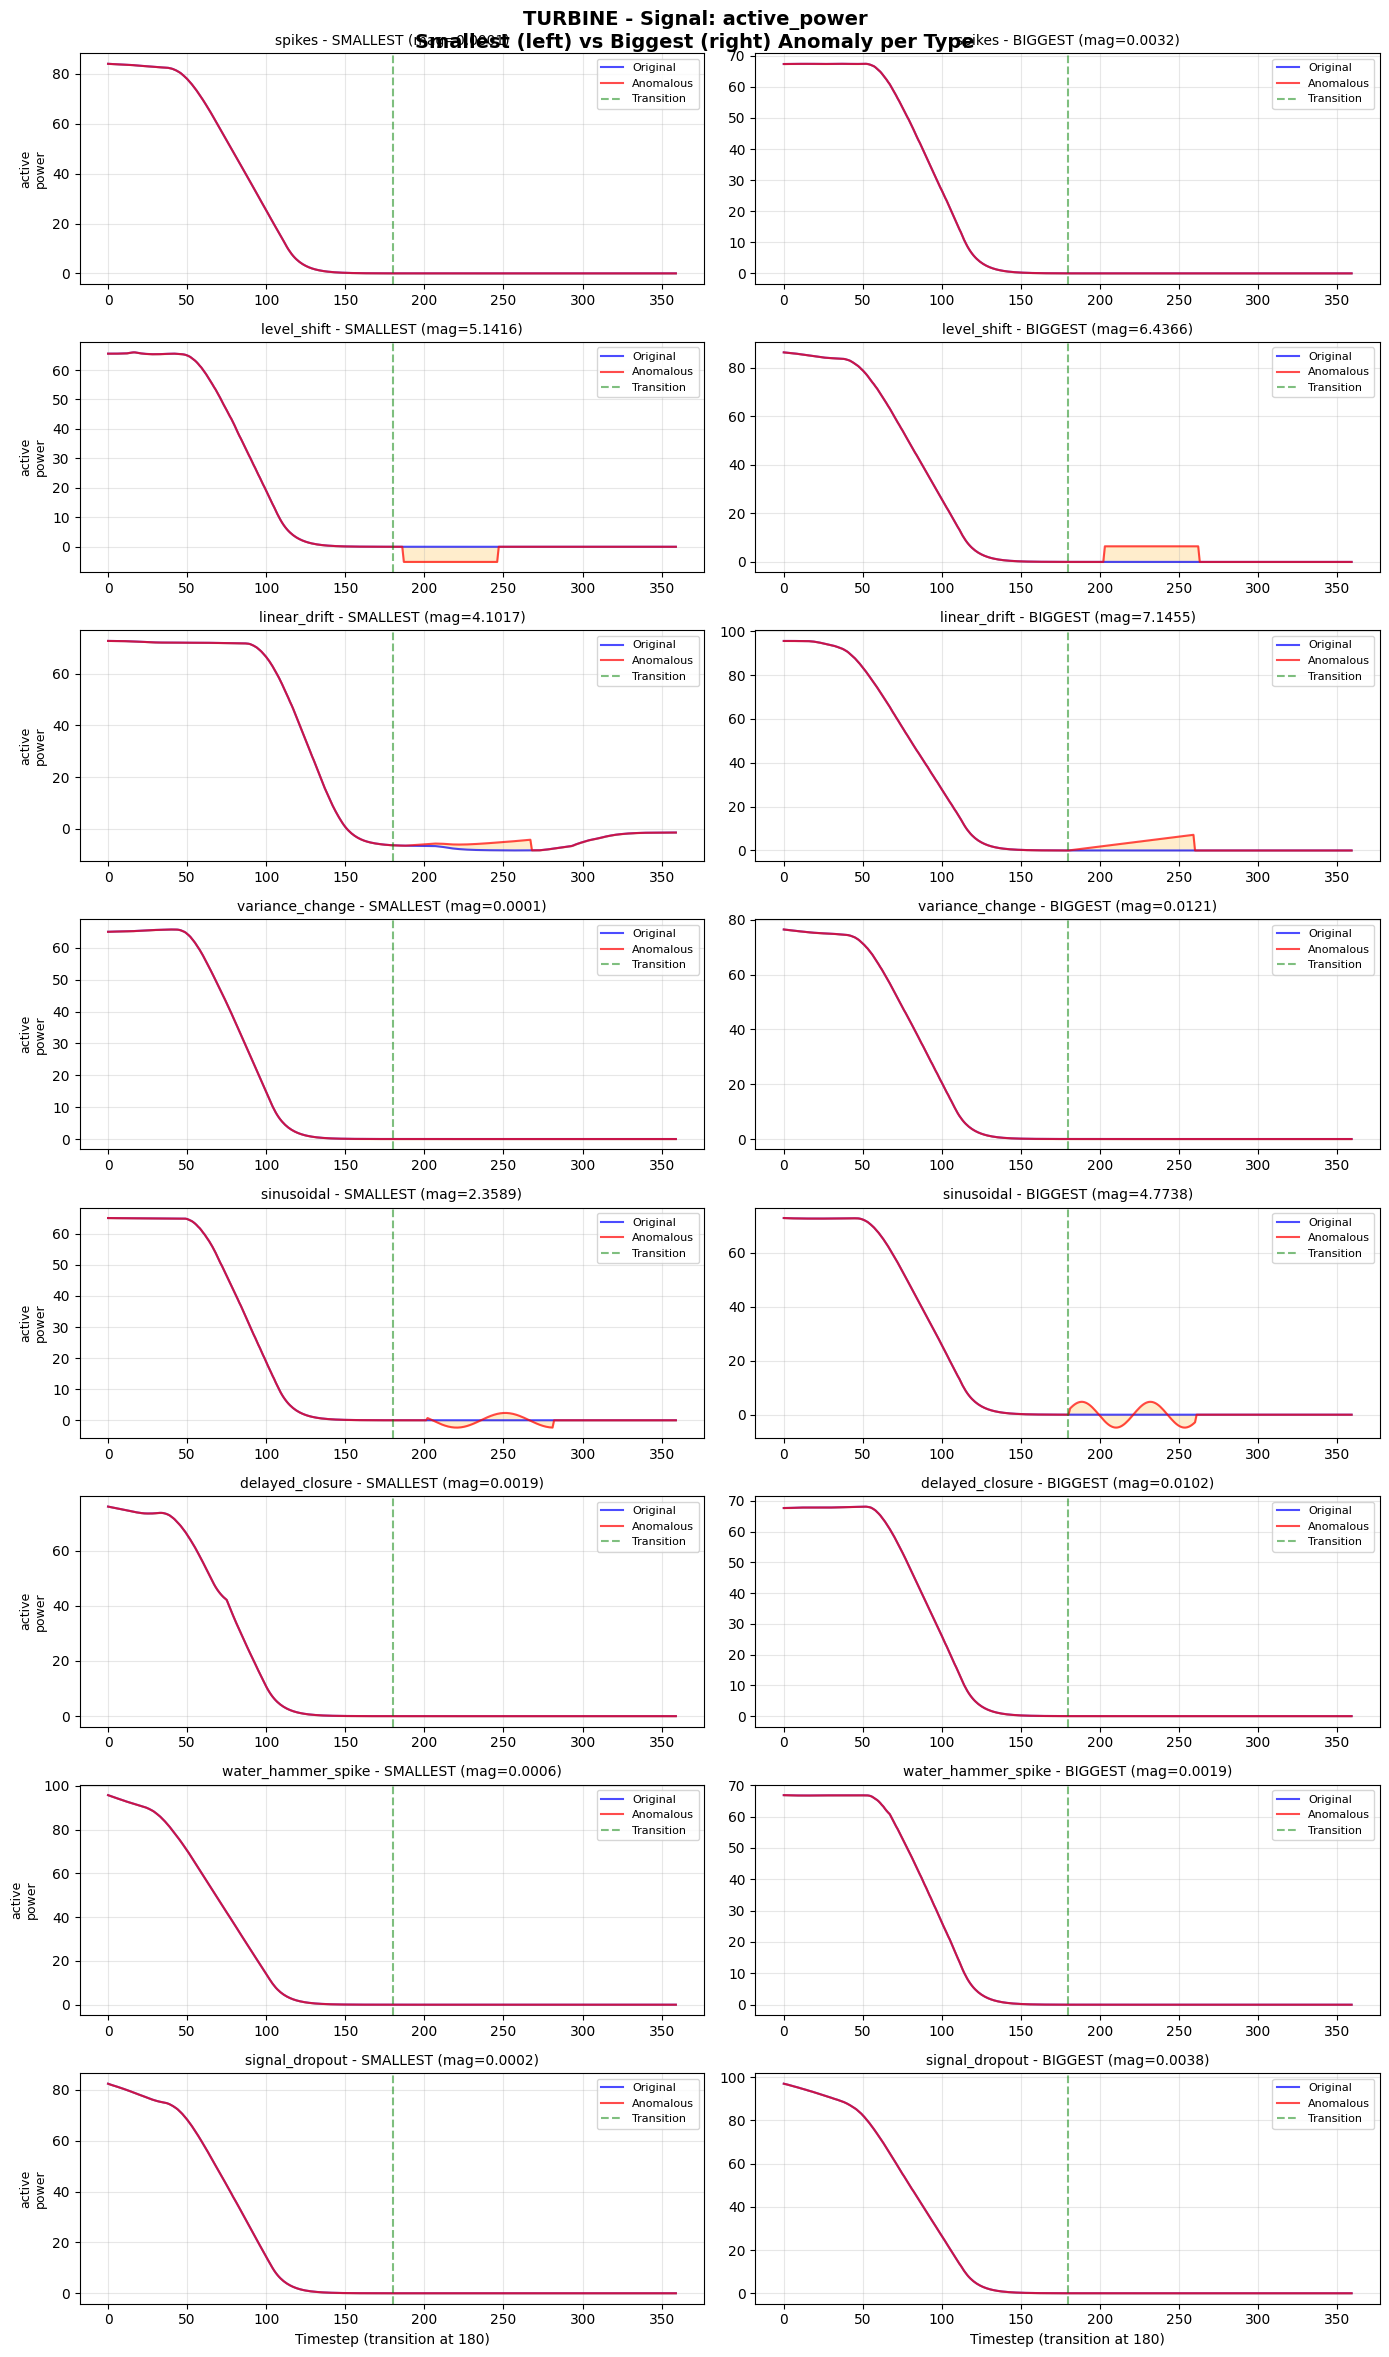

  ✓ Saved: anomaly_extremes_turbine_active_power.png


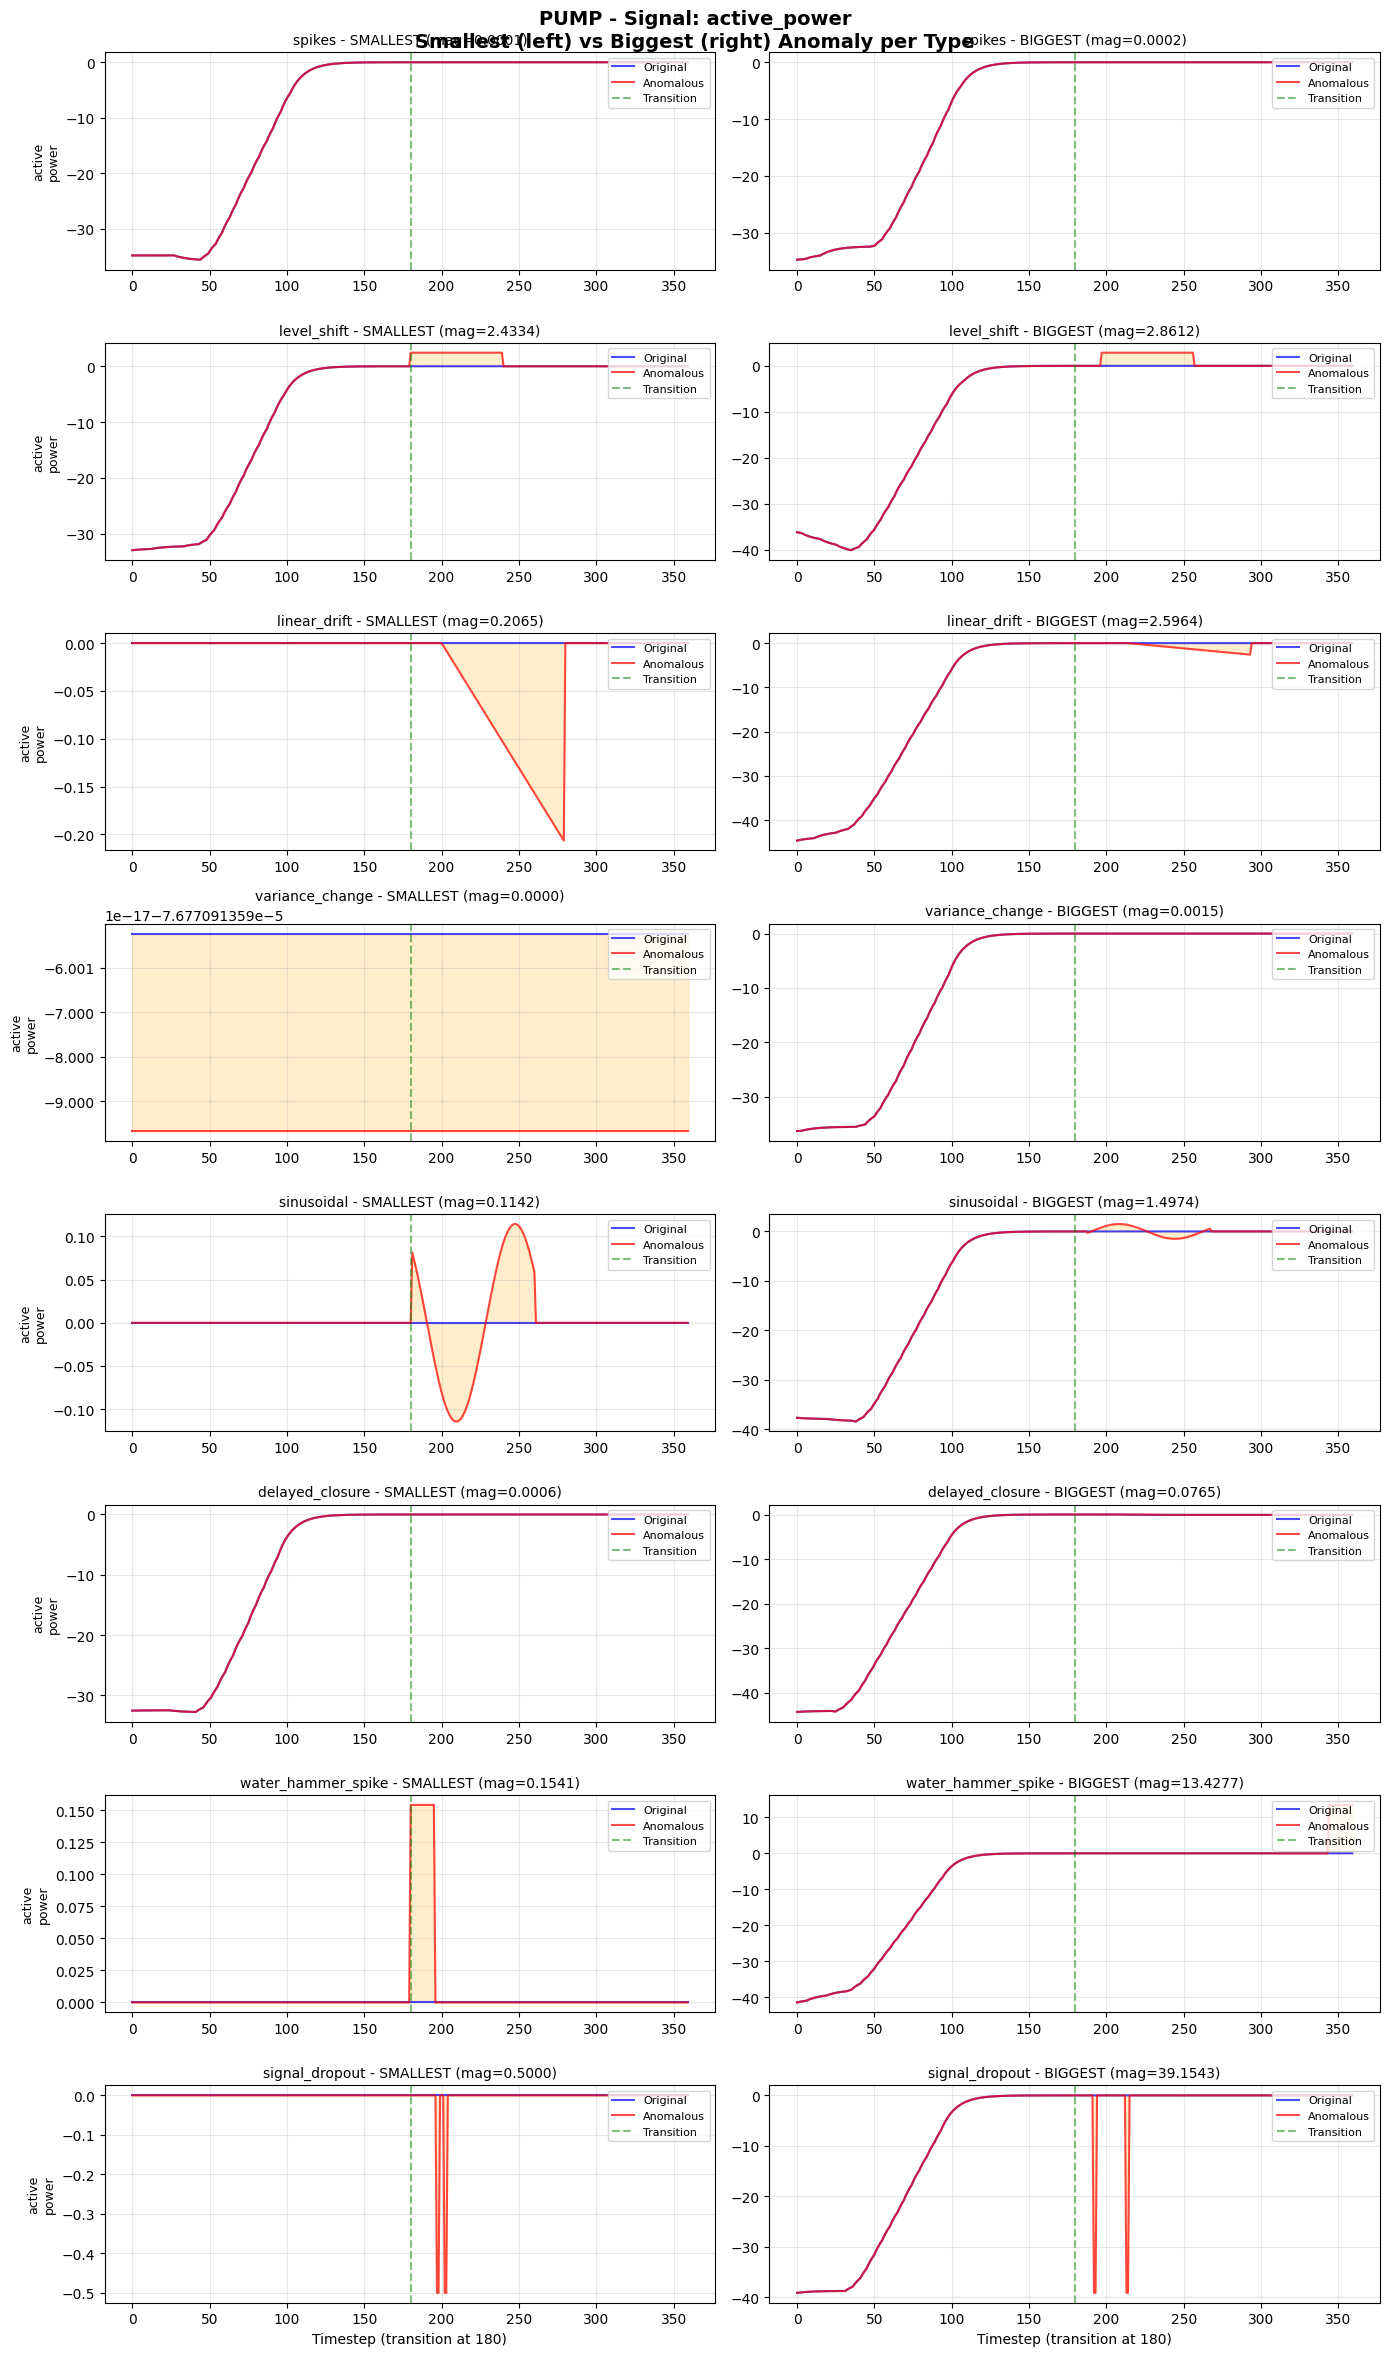

  ✓ Saved: anomaly_extremes_pump_active_power.png


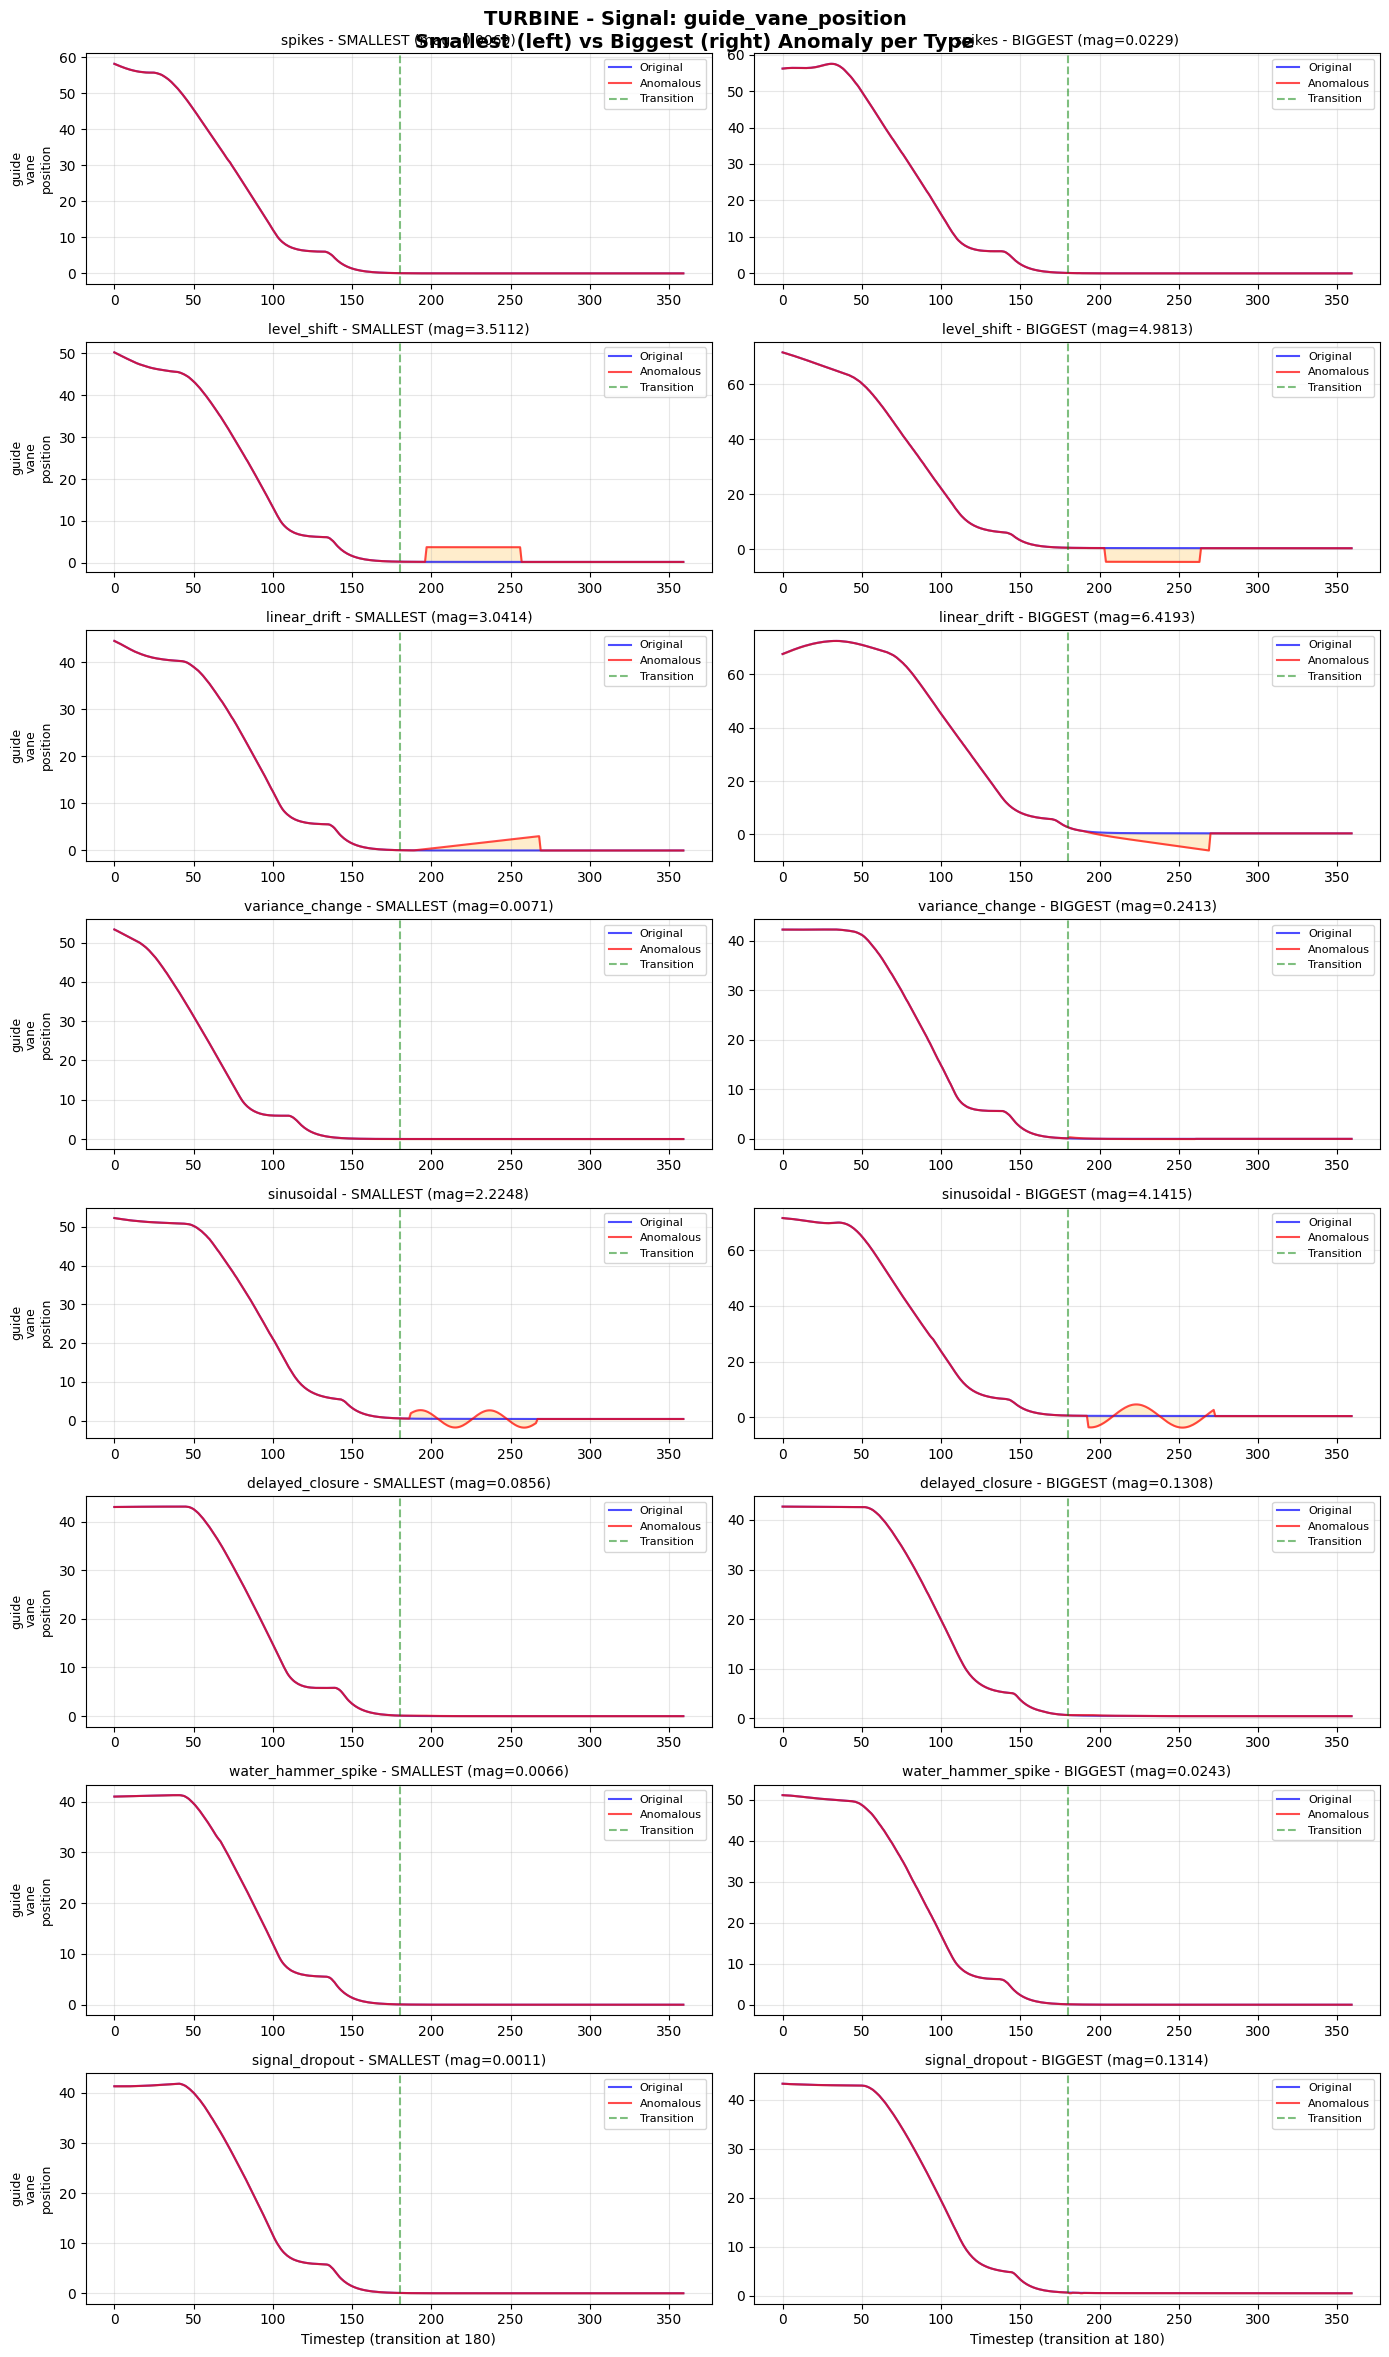

  ✓ Saved: anomaly_extremes_turbine_guide_vane_position.png


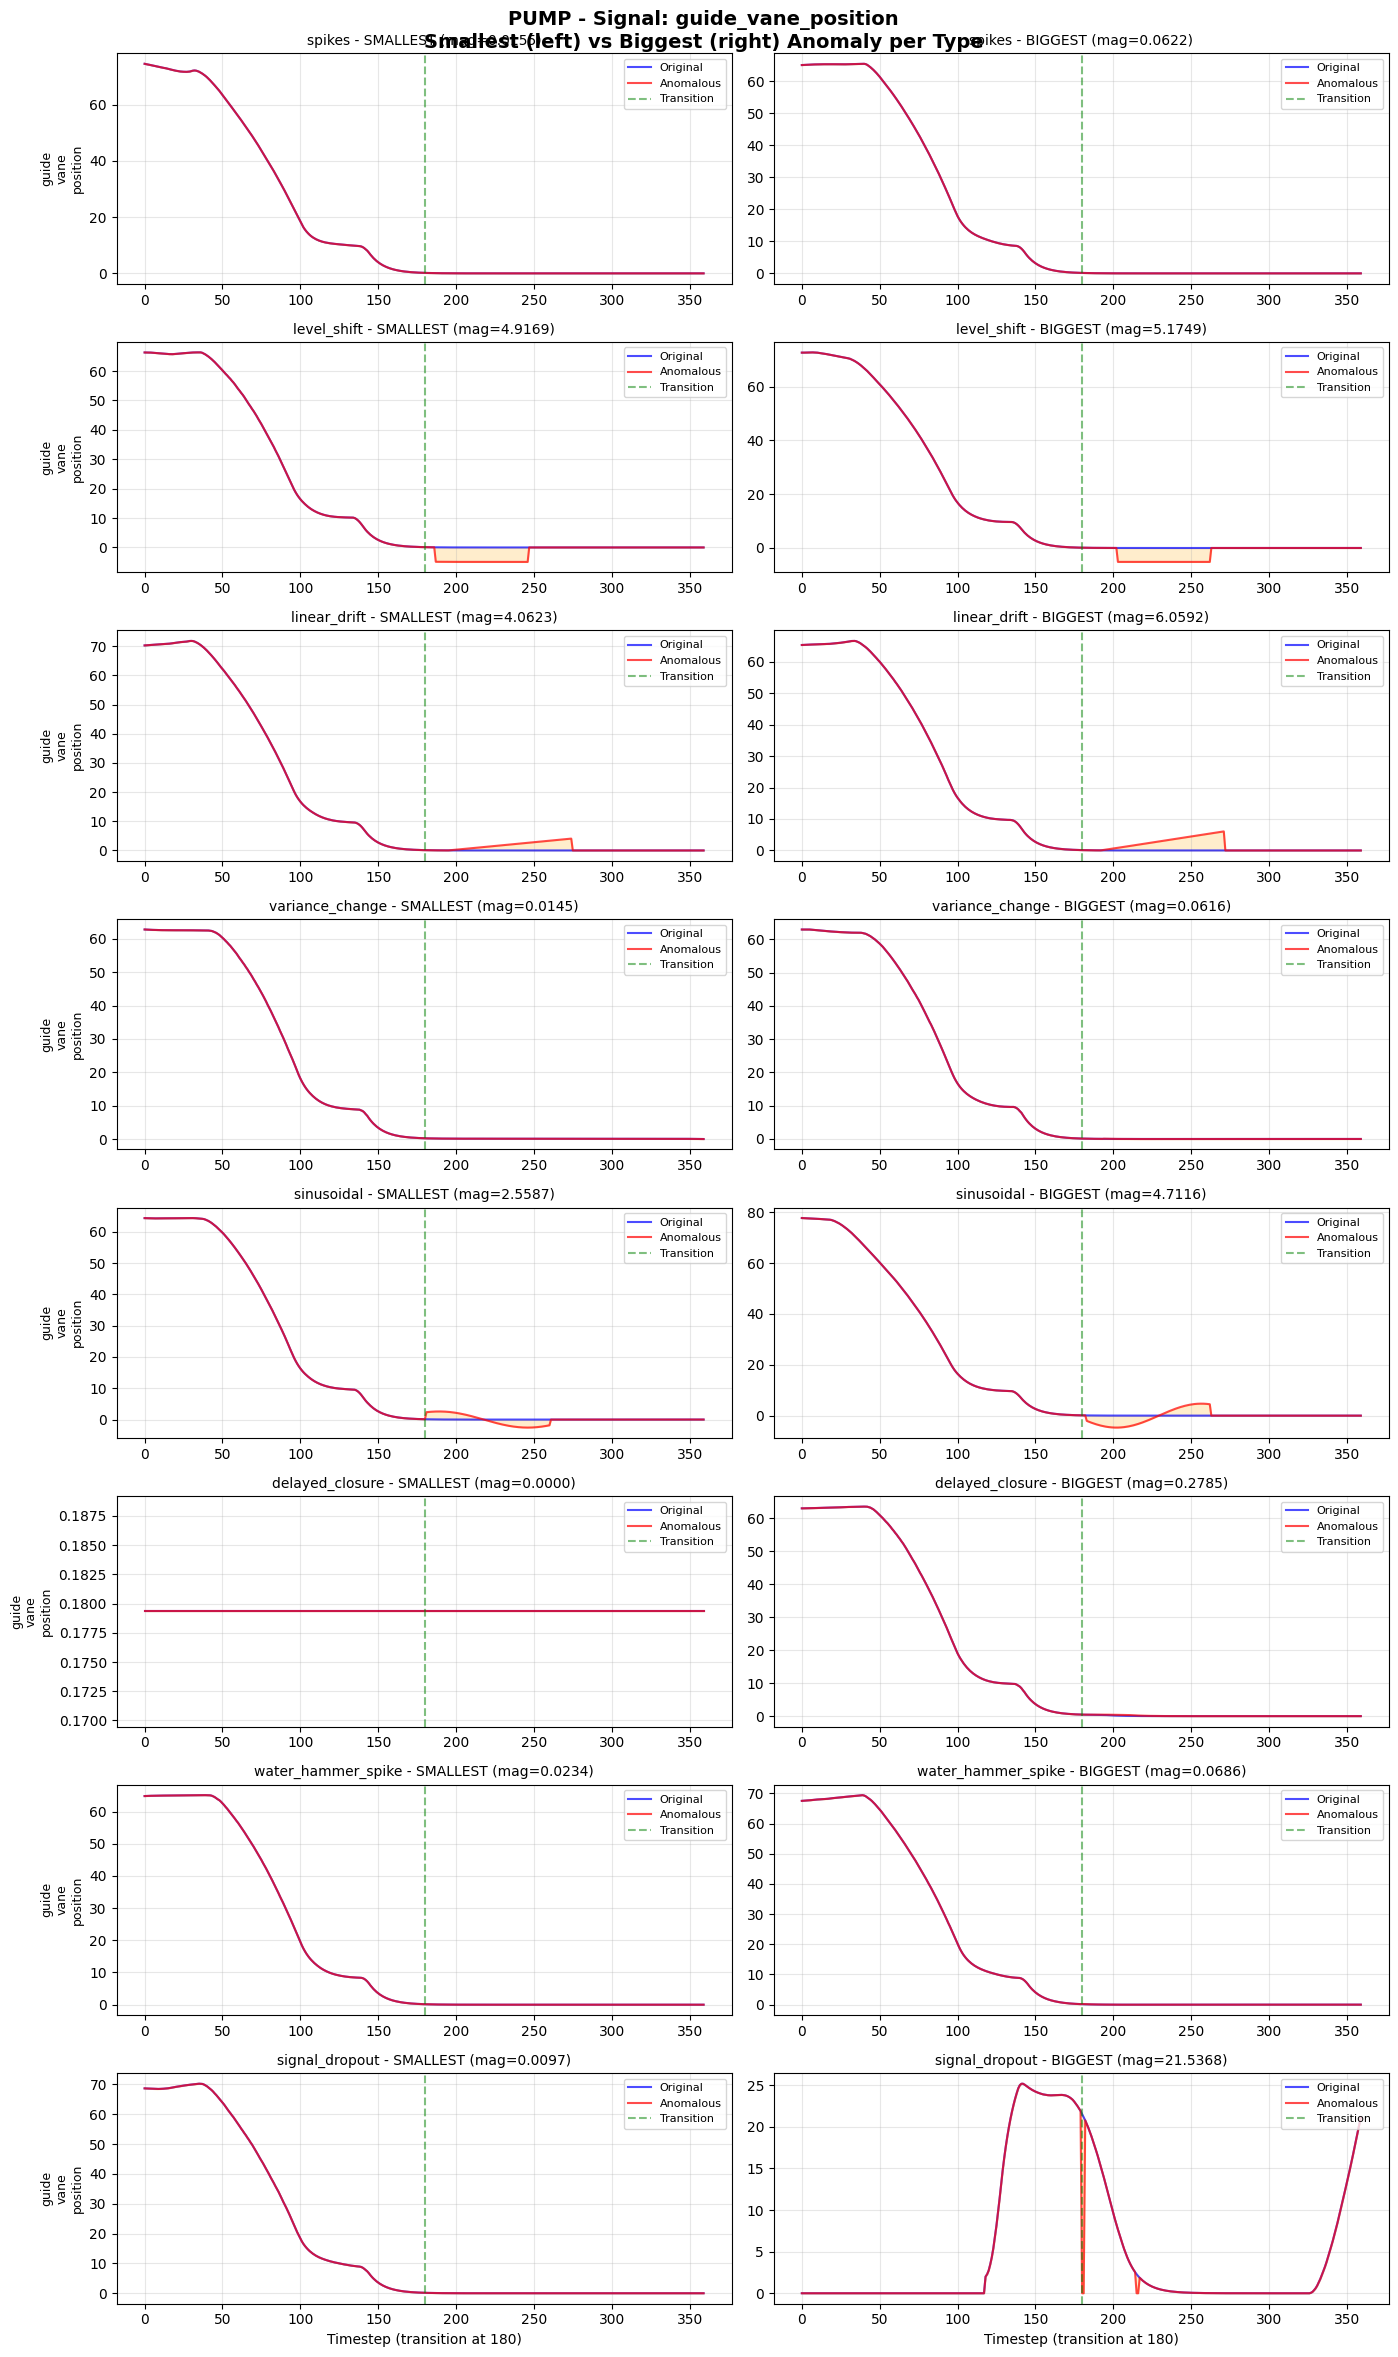

  ✓ Saved: anomaly_extremes_pump_guide_vane_position.png


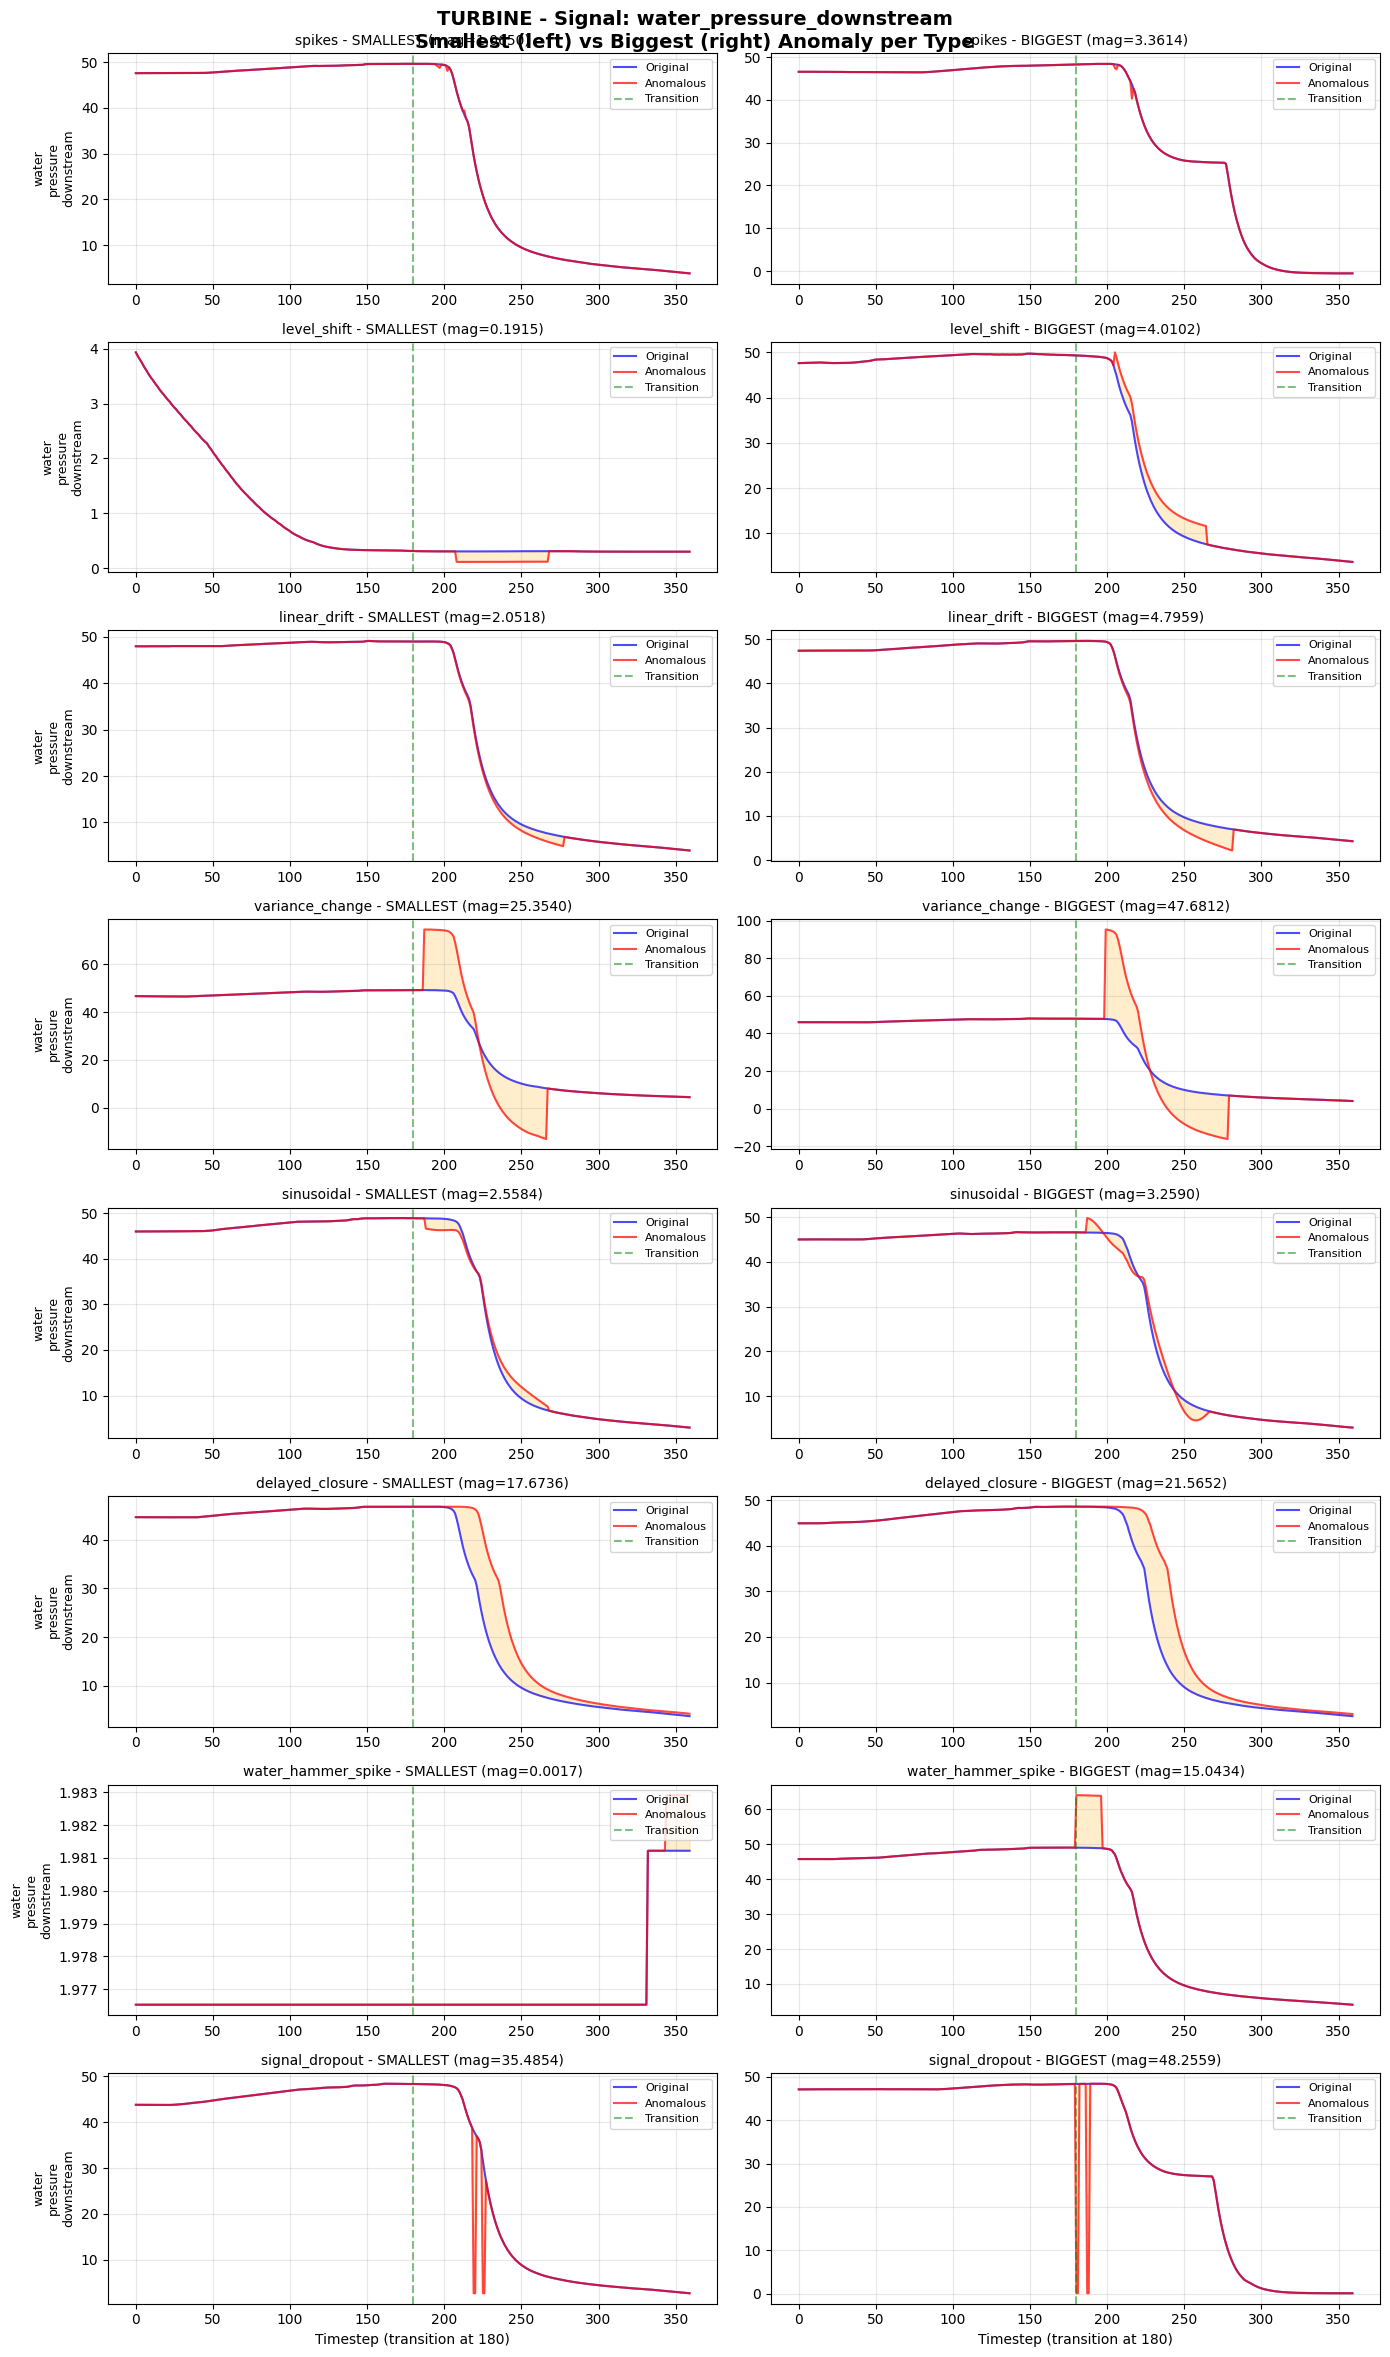

  ✓ Saved: anomaly_extremes_turbine_water_pressure_downstream.png


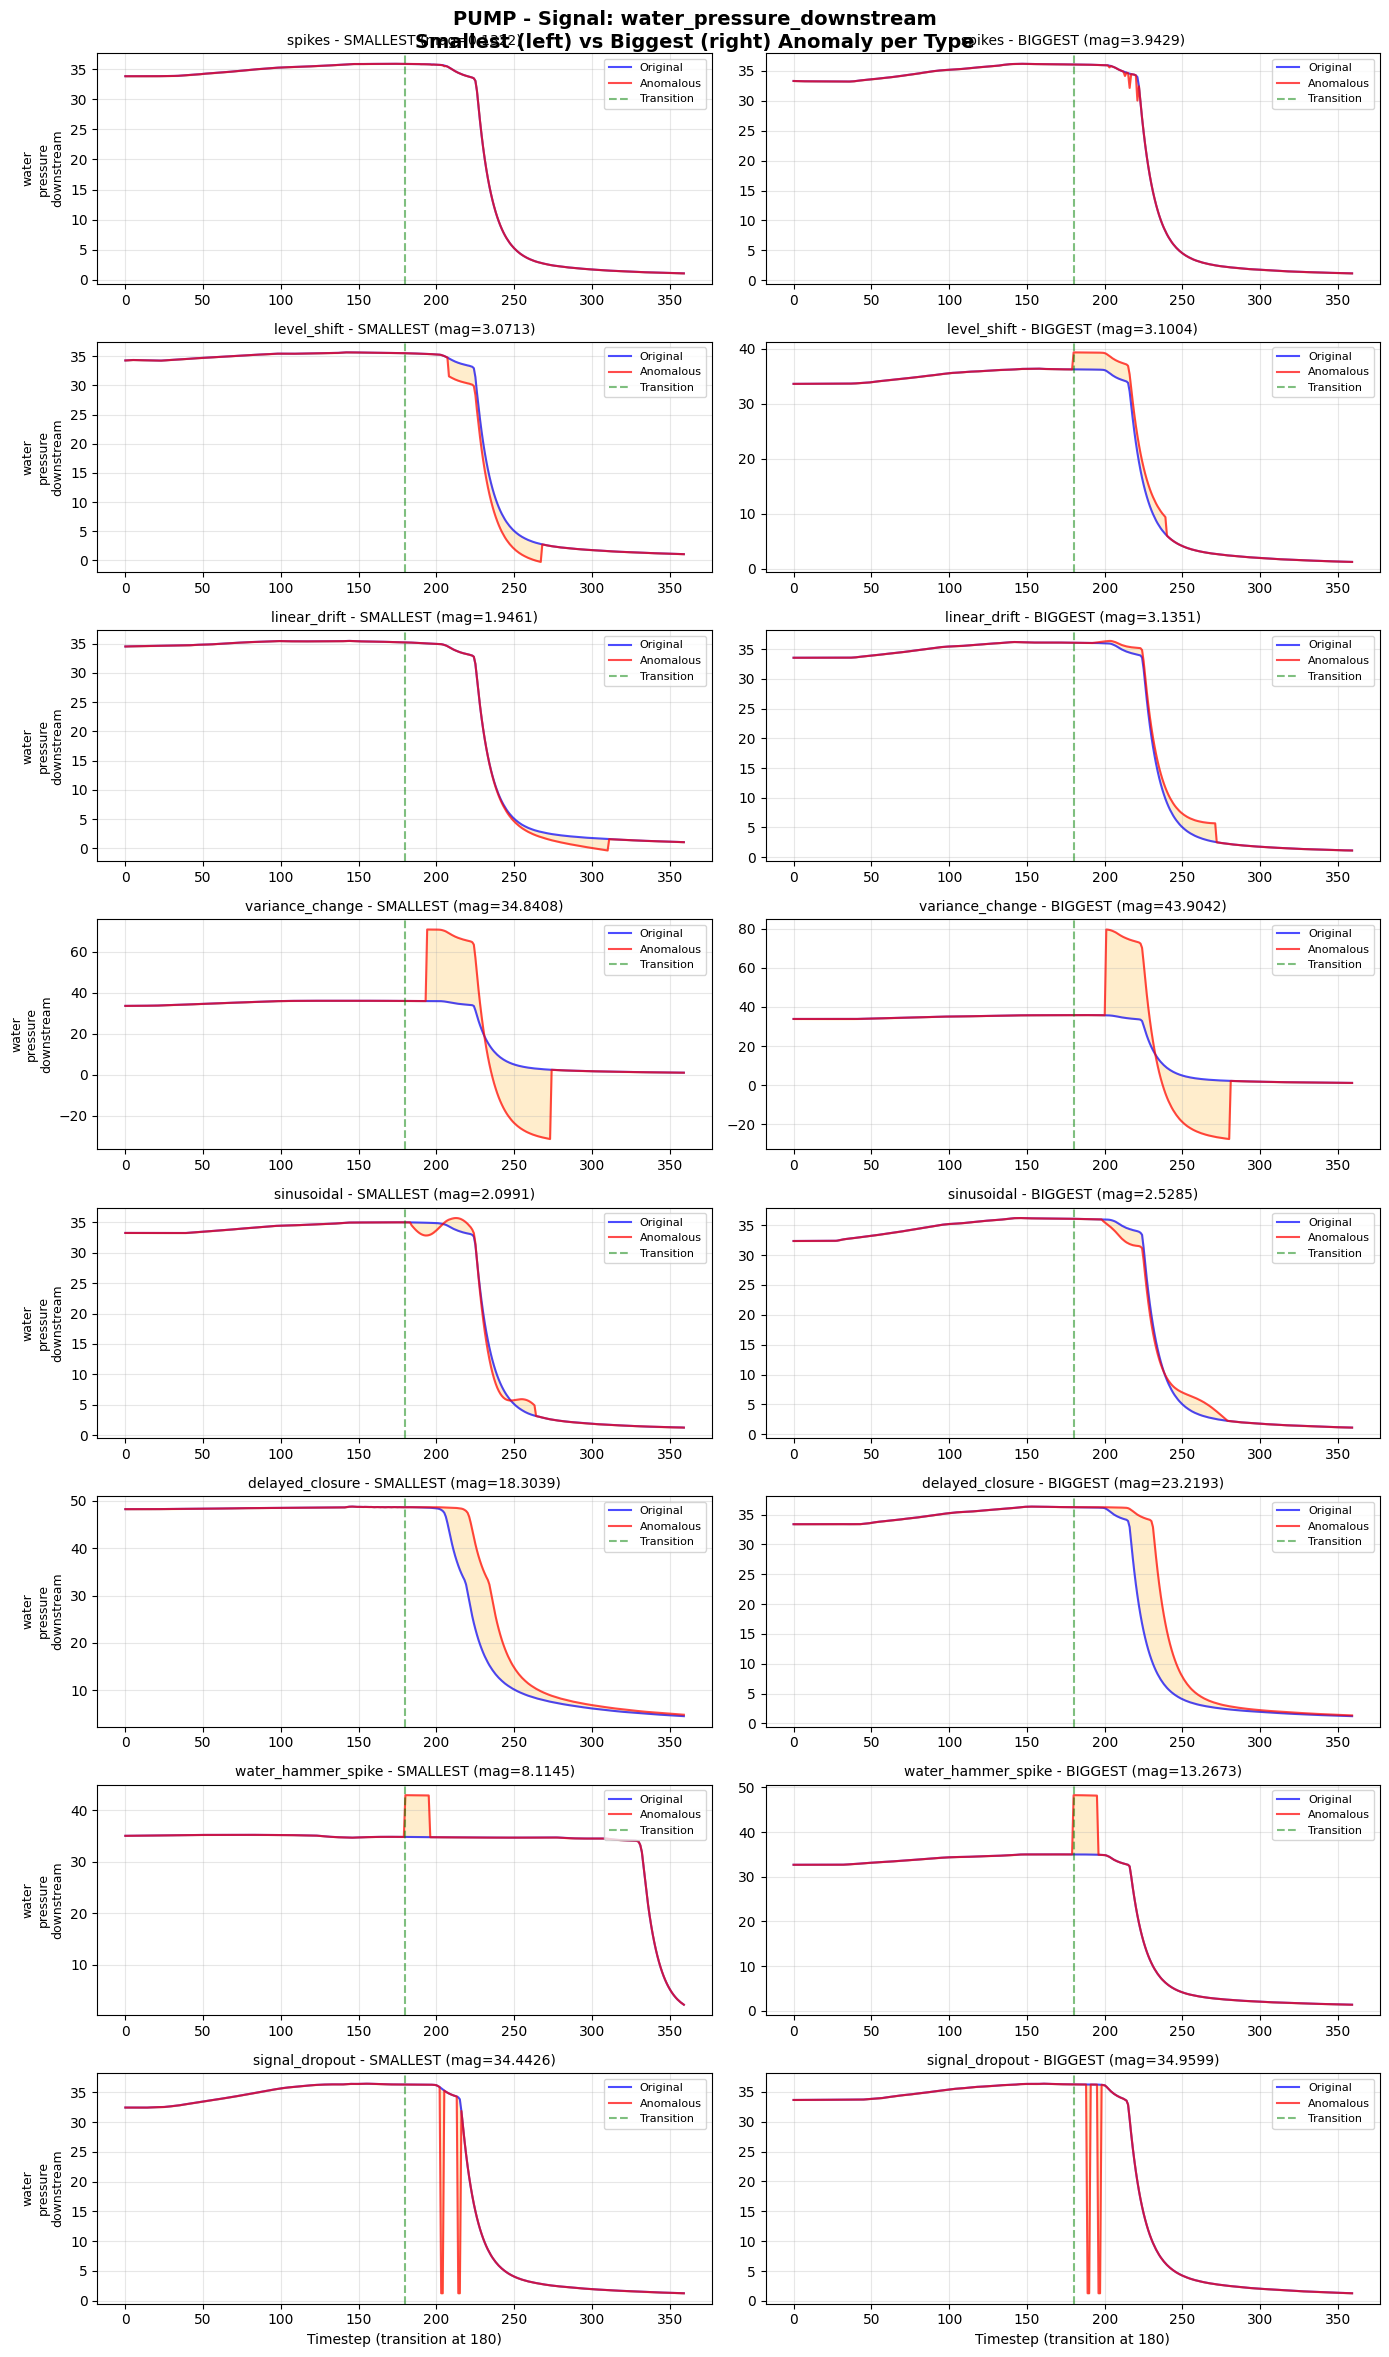

  ✓ Saved: anomaly_extremes_pump_water_pressure_downstream.png


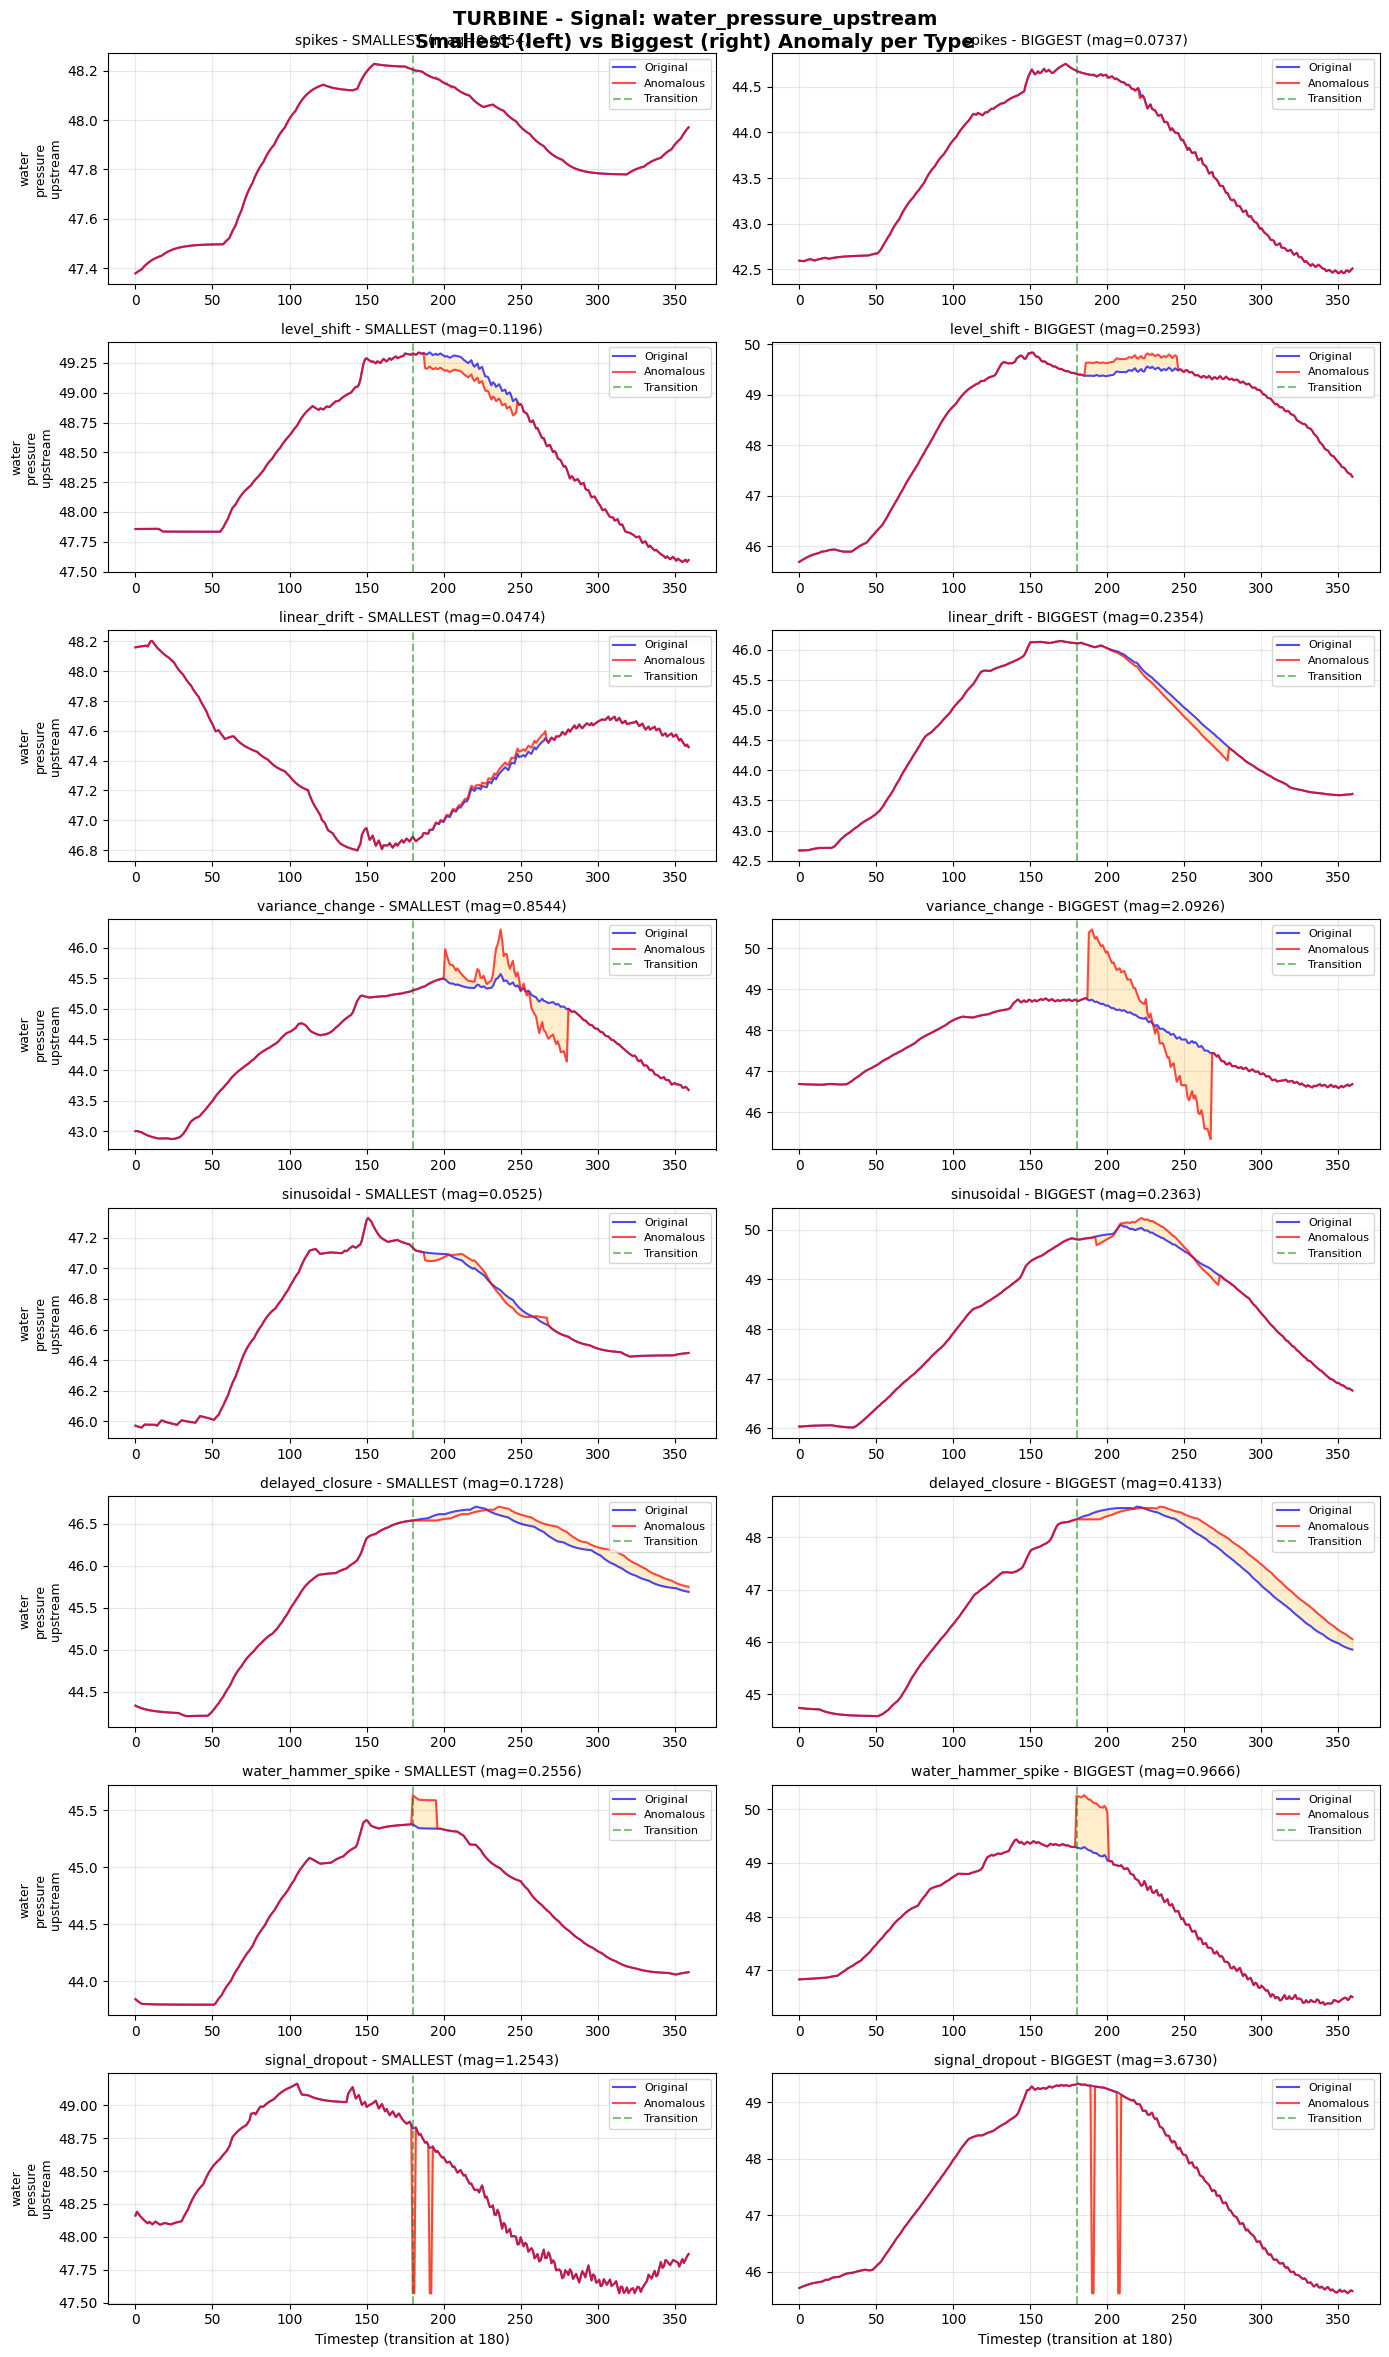

  ✓ Saved: anomaly_extremes_turbine_water_pressure_upstream.png


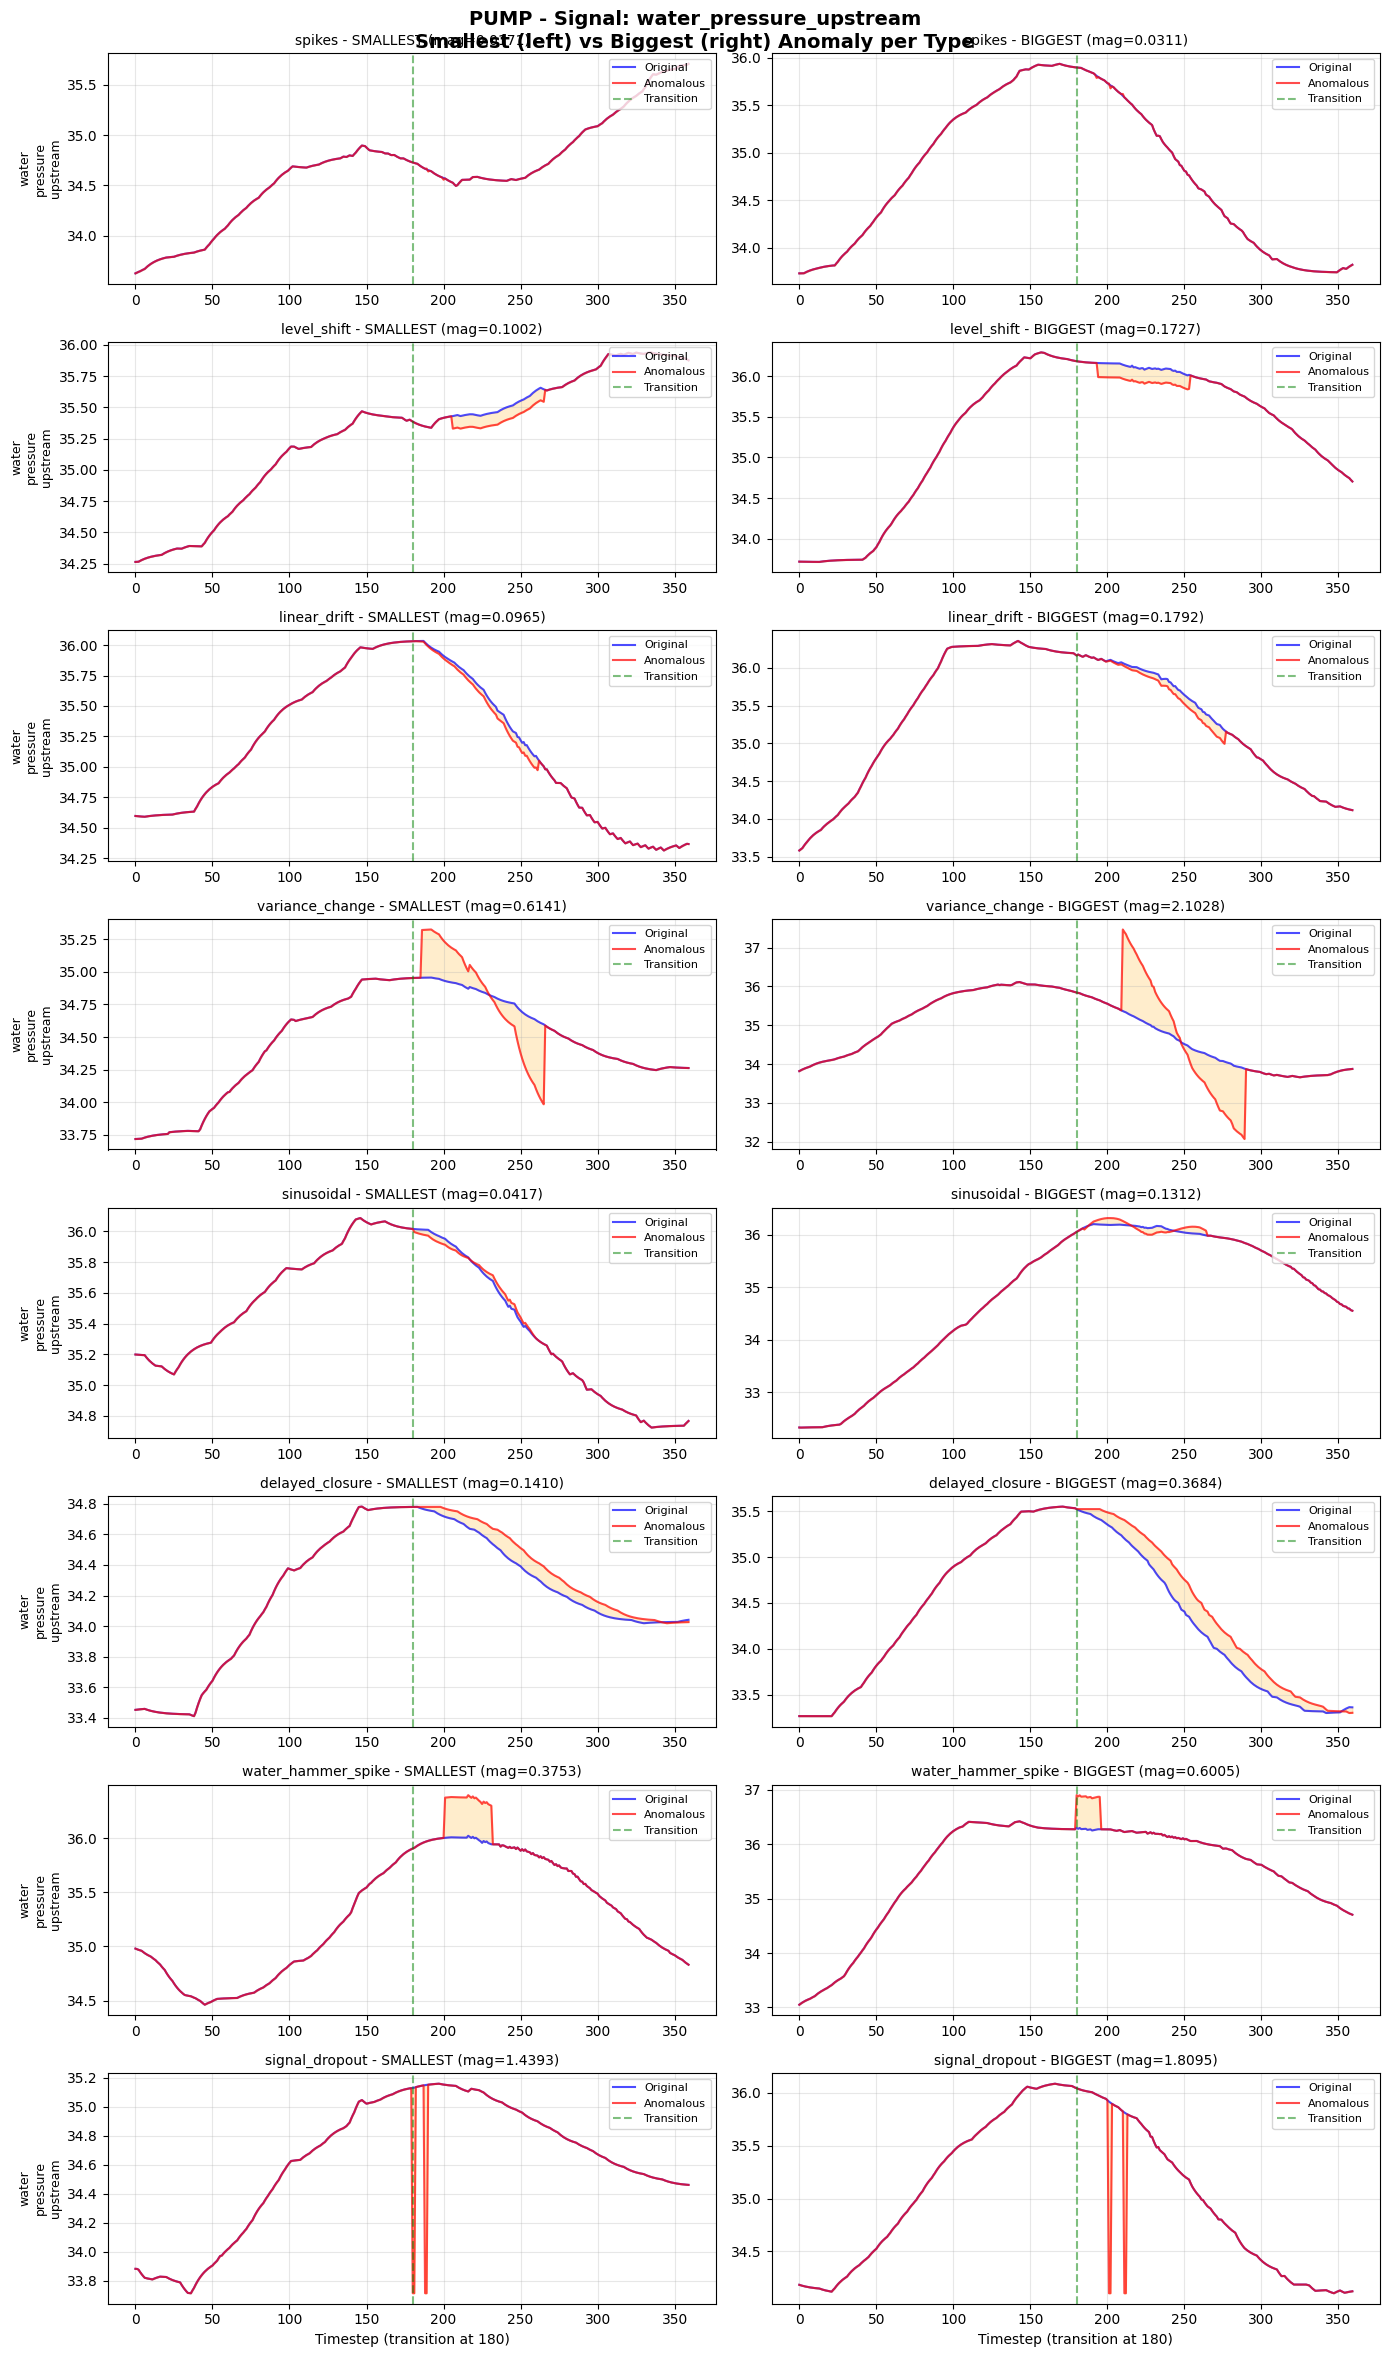

  ✓ Saved: anomaly_extremes_pump_water_pressure_upstream.png

ANOMALY MAGNITUDE SUMMARY

TURBINE:
Anomaly Type         Signal                         Smallest     Biggest     
--------------------------------------------------------------------------
spikes               active_power                   0.0001       0.0032      
spikes               guide_vane_position            0.0069       0.0229      
spikes               water_pressure_downstream      1.0650       3.3614      
spikes               water_pressure_upstream        0.0054       0.0737      
level_shift          active_power                   5.1416       6.4366      
level_shift          guide_vane_position            3.5112       4.9813      
level_shift          water_pressure_downstream      0.1915       4.0102      
level_shift          water_pressure_upstream        0.1196       0.2593      
linear_drift         active_power                   4.1017       7.1455      
linear_drift         guide_vane_position       

In [ ]:
# ==============================================================================
# VISUALIZATION: BIGGEST vs SMALLEST ANOMALIES PER TYPE & SIGNAL
# ==============================================================================
# Shows extreme cases of each anomaly type for each injectable signal
# - Left: Smallest perturbation (hardest to detect)
# - Right: Biggest perturbation (easiest to detect)
# ==============================================================================

# ==============================================================================
# CONFIG
# ==============================================================================
OUTPUT_DIR = 'anomalies_added'
ALL_SIGNALS = ['active_power', 'ball_valve_closed', 'ball_valve_open',
               'guide_vane_position', 'water_pressure_downstream', 'water_pressure_upstream']
INJECTABLE_SIGNALS = ['active_power', 'guide_vane_position', 
                      'water_pressure_downstream', 'water_pressure_upstream']
SIGNAL_INDICES = {sig: i for i, sig in enumerate(ALL_SIGNALS)}

ANOMALY_TYPES = ['spikes', 'level_shift', 'linear_drift', 'variance_change',
                 'sinusoidal', 'delayed_closure', 'water_hammer_spike', 'signal_dropout']

# ==============================================================================
# LOAD DATA
# ==============================================================================
print("Loading anomalous data...")
regime_data = {}
for regime in ['turbine', 'pump']:
    path = os.path.join(OUTPUT_DIR, f'anomalous_{regime}_windows.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            regime_data[regime] = pickle.load(f)
        print(f"  {regime.upper()}: {len(regime_data[regime]['anomaly_metadata'])} anomalies")

# ==============================================================================
# HELPER: Extract signal from flattened window
# ==============================================================================
def get_signal(window_flat, signal_name):
    """Extract a single signal from flattened (2160,) window."""
    idx = SIGNAL_INDICES[signal_name]
    return window_flat.reshape(360, 6)[:, idx]

def compute_anomaly_magnitude(original, anomalous):
    """Compute magnitude of anomaly as max absolute difference."""
    return np.max(np.abs(anomalous - original))

# ==============================================================================
# FIND BIGGEST & SMALLEST ANOMALIES PER TYPE & SIGNAL
# ==============================================================================
print("\nFinding extreme anomalies per type & signal...")

# Structure: {regime: {anomaly_type: {signal: {'biggest': {...}, 'smallest': {...}}}}}
extremes = {regime: {at: {sig: {'biggest': None, 'smallest': None} 
                          for sig in INJECTABLE_SIGNALS} 
                     for at in ANOMALY_TYPES} 
            for regime in regime_data.keys()}

for regime, data in regime_data.items():
    X_orig = data['X_original']
    X_anom = data['X_anomalous']
    meta_list = data['anomaly_metadata']
    
    for meta in meta_list:
        win_idx = meta['window_idx']
        anom_type = meta['anomaly_type']
        signal = meta['signal']
        
        if signal not in INJECTABLE_SIGNALS:
            continue
        
        orig_sig = get_signal(X_orig[win_idx], signal)
        anom_sig = get_signal(X_anom[win_idx], signal)
        magnitude = compute_anomaly_magnitude(orig_sig, anom_sig)
        
        entry = {
            'win_idx': win_idx,
            'magnitude': magnitude,
            'original': orig_sig,
            'anomalous': anom_sig,
            'meta': meta
        }
        
        # Update biggest
        if extremes[regime][anom_type][signal]['biggest'] is None or \
           magnitude > extremes[regime][anom_type][signal]['biggest']['magnitude']:
            extremes[regime][anom_type][signal]['biggest'] = entry
        
        # Update smallest
        if extremes[regime][anom_type][signal]['smallest'] is None or \
           magnitude < extremes[regime][anom_type][signal]['smallest']['magnitude']:
            extremes[regime][anom_type][signal]['smallest'] = entry

# ==============================================================================
# PLOT: PER SIGNAL (all anomaly types)
# ==============================================================================
print("\nGenerating plots per signal...")

for signal in INJECTABLE_SIGNALS:
    sig_idx = SIGNAL_INDICES[signal]
    
    for regime in regime_data.keys():
        # Count how many anomaly types have data for this signal
        valid_types = [at for at in ANOMALY_TYPES 
                       if extremes[regime][at][signal]['biggest'] is not None]
        
        if not valid_types:
            print(f"  No anomalies for {signal} in {regime}")
            continue
        
        n_types = len(valid_types)
        fig, axes = plt.subplots(n_types, 2, figsize=(14, 3 * n_types))
        if n_types == 1:
            axes = axes.reshape(1, 2)
        
        fig.suptitle(f'{regime.upper()} - Signal: {signal}\nSmallest (left) vs Biggest (right) Anomaly per Type', 
                     fontsize=14, fontweight='bold')
        
        for row, anom_type in enumerate(valid_types):
            data_small = extremes[regime][anom_type][signal]['smallest']
            data_big = extremes[regime][anom_type][signal]['biggest']
            
            t = np.arange(360)
            
            # SMALLEST (left)
            ax = axes[row, 0]
            if data_small:
                ax.plot(t, data_small['original'], 'b-', alpha=0.7, linewidth=1.5, label='Original')
                ax.plot(t, data_small['anomalous'], 'r-', alpha=0.7, linewidth=1.5, label='Anomalous')
                ax.axvline(180, color='green', linestyle='--', alpha=0.5, label='Transition')
                ax.fill_between(t, data_small['original'], data_small['anomalous'], 
                               alpha=0.2, color='orange')
                ax.set_title(f'{anom_type} - SMALLEST (mag={data_small["magnitude"]:.4f})', fontsize=10)
                ax.legend(loc='upper right', fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{anom_type} - SMALLEST', fontsize=10)
            ax.set_ylabel(signal.replace('_', '\n'), fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # BIGGEST (right)
            ax = axes[row, 1]
            if data_big:
                ax.plot(t, data_big['original'], 'b-', alpha=0.7, linewidth=1.5, label='Original')
                ax.plot(t, data_big['anomalous'], 'r-', alpha=0.7, linewidth=1.5, label='Anomalous')
                ax.axvline(180, color='green', linestyle='--', alpha=0.5, label='Transition')
                ax.fill_between(t, data_big['original'], data_big['anomalous'], 
                               alpha=0.2, color='orange')
                ax.set_title(f'{anom_type} - BIGGEST (mag={data_big["magnitude"]:.4f})', fontsize=10)
                ax.legend(loc='upper right', fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{anom_type} - BIGGEST', fontsize=10)
            ax.grid(True, alpha=0.3)
        
        # Set x-label on bottom row
        axes[-1, 0].set_xlabel('Timestep (transition at 180)', fontsize=10)
        axes[-1, 1].set_xlabel('Timestep (transition at 180)', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'anomaly_extremes_{regime}_{signal}.png'), dpi=150, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Saved: anomaly_extremes_{regime}_{signal}.png")

# ==============================================================================
# SUMMARY TABLE
# ==============================================================================
print("\n" + "="*80)
print("ANOMALY MAGNITUDE SUMMARY")
print("="*80)

for regime in regime_data.keys():
    print(f"\n{regime.upper()}:")
    print(f"{'Anomaly Type':<20} {'Signal':<30} {'Smallest':<12} {'Biggest':<12}")
    print("-"*74)
    
    for anom_type in ANOMALY_TYPES:
        for signal in INJECTABLE_SIGNALS:
            small = extremes[regime][anom_type][signal]['smallest']
            big = extremes[regime][anom_type][signal]['biggest']
            
            small_mag = f"{small['magnitude']:.4f}" if small else "N/A"
            big_mag = f"{big['magnitude']:.4f}" if big else "N/A"
            
            print(f"{anom_type:<20} {signal:<30} {small_mag:<12} {big_mag:<12}")

print("\n" + "="*80)
print("✅ VISUALIZATION COMPLETE")
print("="*80)

## Conditional testing anomalies per synthetic
### Identifying main clusters

LOADING DATA
  TURBINE: 958 windows, 191 anomalous
  PUMP: 606 windows, 121 anomalous

REGIME: TURBINE

  Computing thresholds from training data...
  Thresholds (97.5th percentile per signal):
    active_power                  : 20.911516
    ball_valve_closed             : 0.000794
    ball_valve_open               : 0.004917
    guide_vane_position           : 13.326065
    water_pressure_downstream     : 5.694918
    water_pressure_upstream       : 1.121262

  Dataset sizes:
    Real test windows: 198
    Synthetic anomalies: 191
    Metadata entries: 191

  Processing real test windows...
    Flagged as anomalous: 11 / 198 (5.6%)

  Processing synthetic anomalies...
    Flagged as anomalous: 190 / 191 (99.5%)

  Combining flagged samples for clustering:
    Real test flagged: 11
    Synthetic flagged: 190
    Total flagged: 201

  HDBSCAN clustering (min_cluster_size=3, min_samples=2)...
    Clusters found: 3
    Noise points: 16 (8.0%)

  k-NN type inference (k=5)...


c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  Type inference summary:
    variance_change: 3 samples (avg confidence: 0.40)
    delayed_closure: 2 samples (avg confidence: 0.30)
    water_hammer_spike: 2 samples (avg confidence: 0.20)
    level_shift: 2 samples (avg confidence: 0.40)
    spikes: 2 samples (avg confidence: 0.60)

REGIME: PUMP

  Computing thresholds from training data...
  Thresholds (97.5th percentile per signal):
    active_power                  : 62.040318
    ball_valve_closed             : 0.010726
    ball_valve_open               : 0.040401
    guide_vane_position           : 131.793838
    water_pressure_downstream     : 32.666906
    water_pressure_upstream       : 3.327802

  Dataset sizes:
    Real test windows: 160
    Synthetic anomalies: 121
    Metadata entries: 121

  Processing real test windows...
    Flagged as anomalous: 17 / 160 (10.6%)

  Processing synthetic anomalies...
    Flagged as anomalous: 120 / 121 (99.2%)

  Combining flagged samples for clustering:
    Real test flagged: 17
    

c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


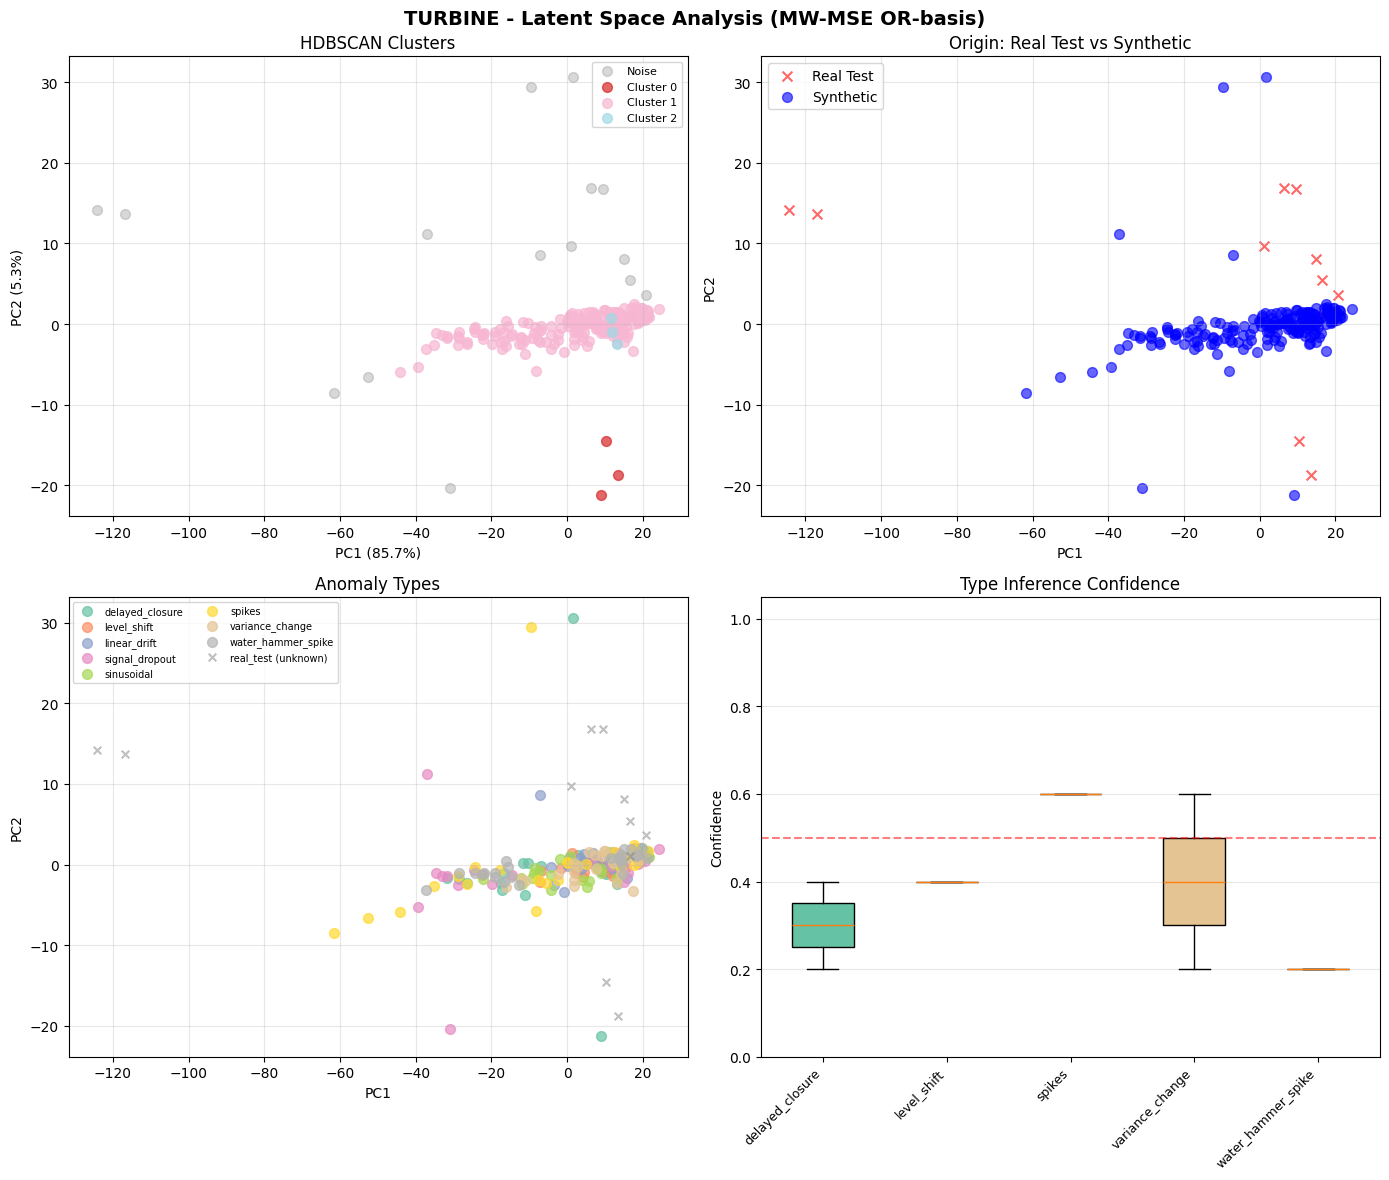

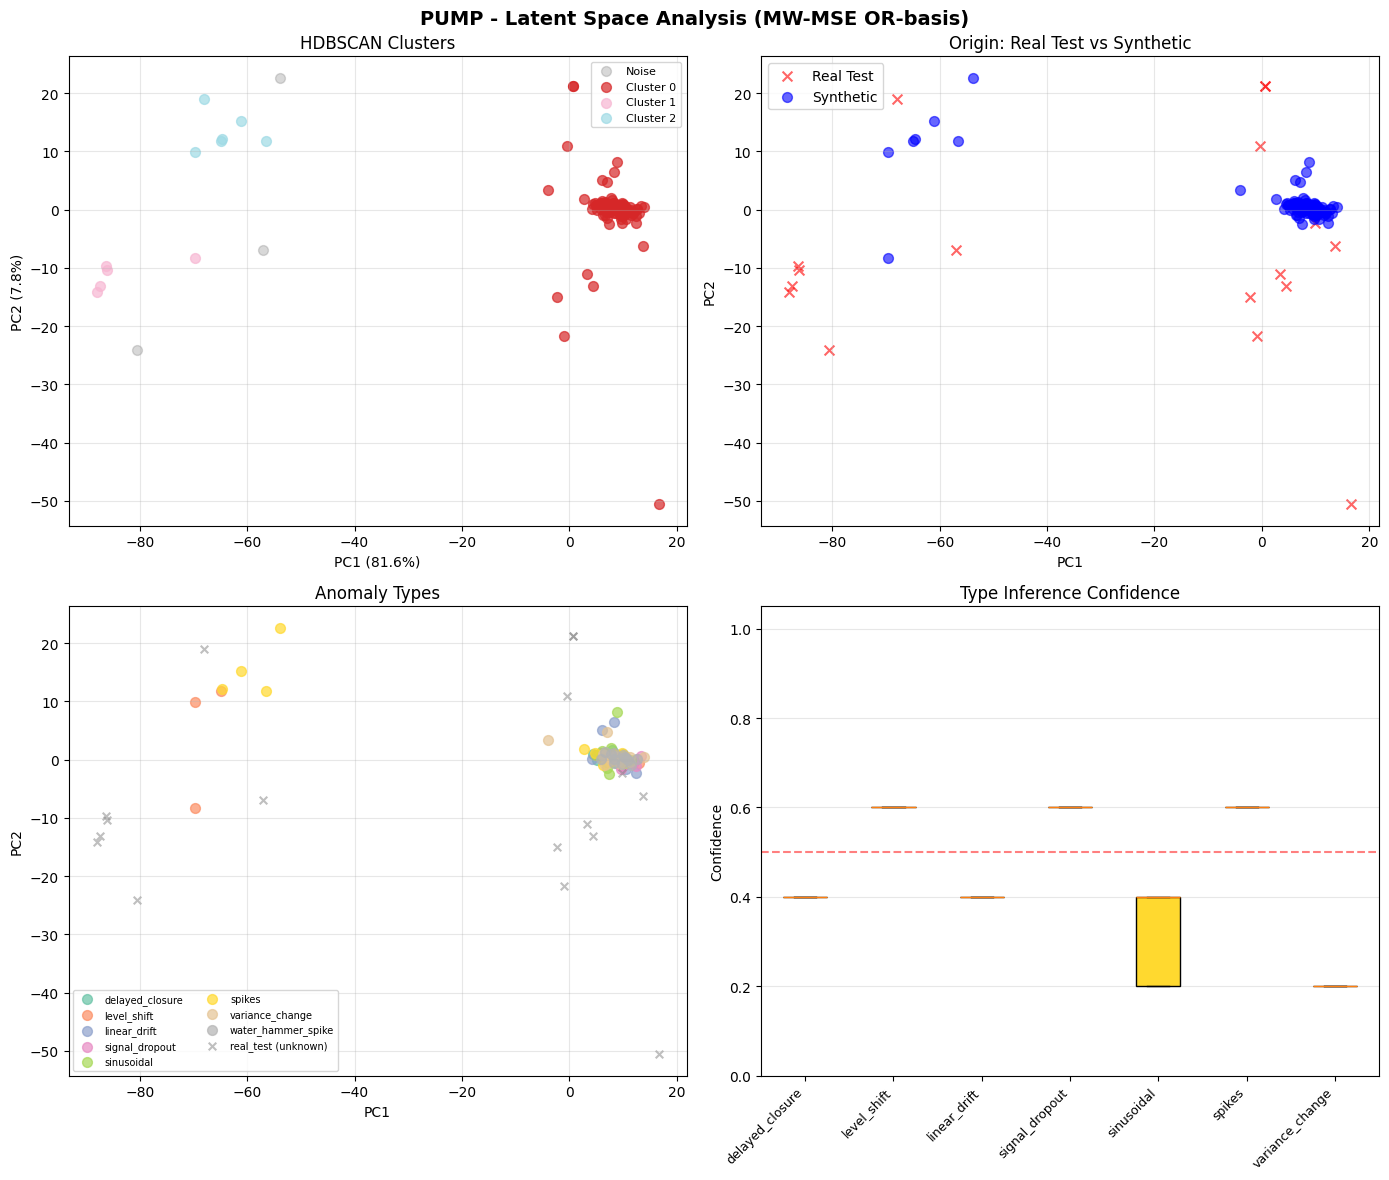


TYPE INFERENCE RESULTS

TURBINE - 11 real test anomalies:
--------------------------------------------------------------------------------
Test Idx   Cluster  Inferred Type        Conf     Agg MSE     
--------------------------------------------------------------------------------
11         -1       variance_change      0.20     96.738238   
27         -1       delayed_closure      0.40     5.777032    
35         -1       variance_change      0.40     19.255095   
36         -1       variance_change      0.60     18.464770   
42         0        delayed_closure      0.20     7.210335    
67         -1       water_hammer_spike   0.20     5.861420    
84         0        level_shift          0.40     6.460845    
124        -1       water_hammer_spike   0.20     85.953919   
165        -1       level_shift          0.40     16.541153   
196        -1       spikes               0.60     11.982718   
197        -1       spikes               0.60     11.684896   

PUMP - 17 real test an

In [ ]:
# ==============================================================================
# ANOMALY DETECTION + LATENT SPACE CLUSTERING + TYPE INFERENCE
# ==============================================================================
# Uses Moving Window MSE per signal (OR-based) - consistent with test cell
# ==============================================================================

# ==============================================================================
# CONFIG
# ==============================================================================
OUTPUT_DIR = 'anomalies_added'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Moving Window MSE parameters (must match training/testing)
WINDOW_SIZE = 30
N_SIGNALS = 6
N_TIMESTEPS = 360

# Anomaly detection threshold percentile
ANOMALY_THRESHOLD_PERCENTILE = 97.5

# HDBSCAN tight tolerances
HDBSCAN_MIN_CLUSTER_SIZE = 3
HDBSCAN_MIN_SAMPLES = 2

# k-NN for type inference
K_NEIGHBORS = 5

SIGNALS = ['active_power', 'ball_valve_closed', 'ball_valve_open',
           'guide_vane_position', 'water_pressure_downstream', 'water_pressure_upstream']

# ==============================================================================
# 1. LOAD SYNTHETIC ANOMALIES
# ==============================================================================
print("="*70)
print("LOADING DATA")
print("="*70)

synthetic_data = {}
for regime in ['turbine', 'pump']:
    path = os.path.join(OUTPUT_DIR, f'anomalous_{regime}_windows.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            synthetic_data[regime] = pickle.load(f)
        n_anom = sum(synthetic_data[regime]['is_anomalous'])
        print(f"  {regime.upper()}: {len(synthetic_data[regime]['X_anomalous'])} windows, {n_anom} anomalous")

# ==============================================================================
# 2. HELPER FUNCTIONS (consistent with test cell)
# ==============================================================================
def compute_moving_window_mse_per_signal(X_orig, X_recon, n_signals=6, n_timesteps=360, window_size=30):
    """Compute Moving Window MSE per signal."""
    N = len(X_orig)
    orig_3d = X_orig.reshape(N, n_timesteps, n_signals)
    recon_3d = X_recon.reshape(N, n_timesteps, n_signals)
    
    mse_per_signal = np.zeros((N, n_signals))
    
    for sig_idx in range(n_signals):
        for i in range(N):
            orig_sig = orig_3d[i, :, sig_idx]
            recon_sig = recon_3d[i, :, sig_idx]
            
            window_losses = []
            for w in range(n_timesteps - window_size + 1):
                window_mse = np.mean((orig_sig[w:w+window_size] - recon_sig[w:w+window_size]) ** 2)
                window_losses.append(window_mse)
            
            mse_per_signal[i, sig_idx] = np.mean(window_losses)
    
    return mse_per_signal


def get_reconstruction_and_latent(model, scaler, X, device=DEVICE):
    """Get reconstructed signals and latent vectors."""
    model.eval()
    X_scaled = scaler.transform(X)
    
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        X_recon_scaled, latent = model(X_tensor)
        X_recon_scaled = X_recon_scaled.cpu().numpy()
        latent = latent.cpu().numpy()
    
    X_recon = scaler.inverse_transform(X_recon_scaled)
    return X_recon, latent


def compute_thresholds_from_train(model, scaler, X_train, percentile=97.5):
    """Compute per-signal MW-MSE thresholds from training data."""
    X_recon, _ = get_reconstruction_and_latent(model, scaler, X_train)
    mw_mse = compute_moving_window_mse_per_signal(X_train, X_recon, N_SIGNALS, N_TIMESTEPS, WINDOW_SIZE)
    thresholds = np.percentile(mw_mse, percentile, axis=0)
    return thresholds


def flag_anomalies_or_basis(mw_mse, thresholds):
    """Flag as anomaly if ANY signal exceeds its threshold (OR logic)."""
    exceeds = mw_mse > thresholds
    is_flagged = exceeds.any(axis=1)
    return is_flagged, exceeds


# ==============================================================================
# 3. PROCESS EACH REGIME
# ==============================================================================
results_clustering = {}

for regime in ['turbine', 'pump']:
    print(f"\n{'='*70}")
    print(f"REGIME: {regime.upper()}")
    print(f"{'='*70}")
    
    # Get model, scaler, and data
    if regime == 'turbine':
        if 'turbine' not in results_regime:
            print(f"  No trained model for {regime}. Skipping.")
            continue
        model = results_regime['turbine']['model']
        scaler = results_regime['turbine']['scaler']
        X_test_real = X_test_turbine
        X_train = X_train_turbine
    else:
        if 'pump' not in results_regime:
            print(f"  No trained model for {regime}. Skipping.")
            continue
        model = results_regime['pump']['model']
        scaler = results_regime['pump']['scaler']
        X_test_real = X_test_pump
        X_train = X_train_pump
    
    model.to(DEVICE)
    
    if len(X_test_real) == 0:
        print(f"  No test data for {regime}. Skipping.")
        continue
    
    syn_data = synthetic_data.get(regime)
    if syn_data is None:
        print(f"  No synthetic data for {regime}. Skipping.")
        continue
    
    # -------------------------------------------------------------------------
    # 3.1 Compute thresholds from training data
    # -------------------------------------------------------------------------
    print(f"\n  Computing thresholds from training data...")
    thresholds = compute_thresholds_from_train(model, scaler, X_train, ANOMALY_THRESHOLD_PERCENTILE)
    
    print(f"  Thresholds ({ANOMALY_THRESHOLD_PERCENTILE}th percentile per signal):")
    for i, sig in enumerate(SIGNALS):
        print(f"    {sig:<30}: {thresholds[i]:.6f}")
    
    # -------------------------------------------------------------------------
    # 3.2 Prepare datasets
    # -------------------------------------------------------------------------
    # Get indices of anomalous windows in synthetic data
    is_anomalous_mask = syn_data['is_anomalous']
    anomalous_indices = np.where(is_anomalous_mask)[0]
    
    # X_syn_anomalous: only the windows that have injected anomalies
    X_syn_anomalous = syn_data['X_anomalous'][is_anomalous_mask]
    
    # syn_meta: metadata list (already contains only anomalous entries)
    # The metadata list length should match the number of True values in is_anomalous
    syn_meta = syn_data['anomaly_metadata']
    
    n_test = len(X_test_real)
    n_syn = len(X_syn_anomalous)
    
    print(f"\n  Dataset sizes:")
    print(f"    Real test windows: {n_test}")
    print(f"    Synthetic anomalies: {n_syn}")
    print(f"    Metadata entries: {len(syn_meta)}")
    
    # Verify metadata matches
    if len(syn_meta) != n_syn:
        print(f"  ⚠️ Metadata mismatch: {len(syn_meta)} != {n_syn}. Adjusting...")
        # Use the minimum to avoid index errors
        n_syn = min(len(syn_meta), n_syn)
        X_syn_anomalous = X_syn_anomalous[:n_syn]
    
    # -------------------------------------------------------------------------
    # 3.3 Process REAL TEST windows
    # -------------------------------------------------------------------------
    print(f"\n  Processing real test windows...")
    X_recon_test, latent_test = get_reconstruction_and_latent(model, scaler, X_test_real)
    mw_mse_test = compute_moving_window_mse_per_signal(X_test_real, X_recon_test, N_SIGNALS, N_TIMESTEPS, WINDOW_SIZE)
    is_flagged_test, exceeds_test = flag_anomalies_or_basis(mw_mse_test, thresholds)
    
    n_flagged_test = is_flagged_test.sum()
    print(f"    Flagged as anomalous: {n_flagged_test} / {n_test} ({100*n_flagged_test/n_test:.1f}%)")
    
    # -------------------------------------------------------------------------
    # 3.4 Process SYNTHETIC windows
    # -------------------------------------------------------------------------
    print(f"\n  Processing synthetic anomalies...")
    X_recon_syn, latent_syn = get_reconstruction_and_latent(model, scaler, X_syn_anomalous)
    mw_mse_syn = compute_moving_window_mse_per_signal(X_syn_anomalous, X_recon_syn, N_SIGNALS, N_TIMESTEPS, WINDOW_SIZE)
    is_flagged_syn, exceeds_syn = flag_anomalies_or_basis(mw_mse_syn, thresholds)
    
    n_flagged_syn = is_flagged_syn.sum()
    print(f"    Flagged as anomalous: {n_flagged_syn} / {n_syn} ({100*n_flagged_syn/n_syn:.1f}%)")
    
    # -------------------------------------------------------------------------
    # 3.5 Combine ONLY FLAGGED samples for clustering
    # -------------------------------------------------------------------------
    idx_test_flagged = np.where(is_flagged_test)[0]
    idx_syn_flagged = np.where(is_flagged_syn)[0]
    
    n_test_flagged = len(idx_test_flagged)
    n_syn_flagged = len(idx_syn_flagged)
    n_total_flagged = n_test_flagged + n_syn_flagged
    
    print(f"\n  Combining flagged samples for clustering:")
    print(f"    Real test flagged: {n_test_flagged}")
    print(f"    Synthetic flagged: {n_syn_flagged}")
    print(f"    Total flagged: {n_total_flagged}")
    
    if n_total_flagged < 5:
        print(f"\n  ⚠️ Too few flagged samples ({n_total_flagged}) for clustering. Skipping.")
        continue
    
    # Combine latent vectors of flagged samples
    latent_flagged = np.vstack([
        latent_test[idx_test_flagged],
        latent_syn[idx_syn_flagged]
    ])
    
    # Labels for flagged samples
    origin_flagged = np.array(['real_test'] * n_test_flagged + ['synthetic'] * n_syn_flagged)
    
    # Anomaly types for FLAGGED synthetic samples (use idx_syn_flagged to index syn_meta)
    types_flagged = np.array(
        ['unknown'] * n_test_flagged + 
        [syn_meta[i]['anomaly_type'] for i in idx_syn_flagged]
    )
    signals_flagged = np.array(
        ['unknown'] * n_test_flagged + 
        [syn_meta[i]['signal'] for i in idx_syn_flagged]
    )
    
    # Errors for flagged samples
    mw_mse_flagged = np.vstack([
        mw_mse_test[idx_test_flagged],
        mw_mse_syn[idx_syn_flagged]
    ])
    errors_aggregate = mw_mse_flagged.mean(axis=1)
    
    # -------------------------------------------------------------------------
    # 3.6 HDBSCAN clustering on flagged anomalies' latent space
    # -------------------------------------------------------------------------
    print(f"\n  HDBSCAN clustering (min_cluster_size={HDBSCAN_MIN_CLUSTER_SIZE}, min_samples={HDBSCAN_MIN_SAMPLES})...")
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
        min_samples=HDBSCAN_MIN_SAMPLES,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    cluster_labels = clusterer.fit_predict(latent_flagged)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = (cluster_labels == -1).sum()
    
    print(f"    Clusters found: {n_clusters}")
    print(f"    Noise points: {n_noise} ({100*n_noise/n_total_flagged:.1f}%)")
    
    # -------------------------------------------------------------------------
    # 3.7 k-NN type inference for real test anomalies
    # -------------------------------------------------------------------------
    print(f"\n  k-NN type inference (k={K_NEIGHBORS})...")
    
    idx_real_in_flagged = np.arange(n_test_flagged)
    idx_syn_in_flagged = np.arange(n_test_flagged, n_total_flagged)
    
    type_inference_results = []
    
    if n_test_flagged > 0 and n_syn_flagged > 0:
        latent_syn_flagged = latent_flagged[idx_syn_in_flagged]
        types_syn_flagged = types_flagged[idx_syn_in_flagged]
        
        k = min(K_NEIGHBORS, n_syn_flagged)
        knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
        knn.fit(latent_syn_flagged)
        
        latent_real_flagged = latent_flagged[idx_real_in_flagged]
        
        for i in range(n_test_flagged):
            distances, neighbor_indices = knn.kneighbors(latent_real_flagged[i:i+1])
            neighbor_types = types_syn_flagged[neighbor_indices[0]]
            
            type_counts = Counter(neighbor_types)
            total = sum(type_counts.values())
            type_probs = {t: c/total for t, c in type_counts.items()}
            
            most_likely_type = type_counts.most_common(1)[0][0]
            confidence = type_probs[most_likely_type]
            cluster = cluster_labels[i]
            orig_test_idx = idx_test_flagged[i]
            
            type_inference_results.append({
                'original_test_idx': orig_test_idx,
                'flagged_idx': i,
                'cluster': cluster,
                'most_likely_type': most_likely_type,
                'confidence': confidence,
                'type_probabilities': type_probs,
                'aggregate_mse': errors_aggregate[i],
                'neighbor_distances': distances[0].tolist(),
            })
        
        print(f"\n  Type inference summary:")
        inferred_types = [r['most_likely_type'] for r in type_inference_results]
        type_dist = Counter(inferred_types)
        for t, c in type_dist.most_common():
            avg_conf = np.mean([r['confidence'] for r in type_inference_results if r['most_likely_type'] == t])
            print(f"    {t}: {c} samples (avg confidence: {avg_conf:.2f})")
    else:
        print(f"    No real test anomalies or no synthetic anomalies flagged.")
    
    # -------------------------------------------------------------------------
    # 3.8 Store results
    # -------------------------------------------------------------------------
    results_clustering[regime] = {
        'thresholds': thresholds,
        'n_test': n_test,
        'n_syn': n_syn,
        'n_test_flagged': n_test_flagged,
        'n_syn_flagged': n_syn_flagged,
        'latent_flagged': latent_flagged,
        'origin_flagged': origin_flagged,
        'types_flagged': types_flagged,
        'signals_flagged': signals_flagged,
        'mw_mse_flagged': mw_mse_flagged,
        'cluster_labels': cluster_labels,
        'type_inference': type_inference_results,
        'idx_test_flagged': idx_test_flagged,
        'idx_syn_flagged': idx_syn_flagged,
    }

# ==============================================================================
# 4. VISUALIZATION
# ==============================================================================
print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

for regime in results_clustering.keys():
    r = results_clustering[regime]
    
    if len(r['latent_flagged']) < 3:
        print(f"  {regime.upper()}: Not enough flagged samples")
        continue
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{regime.upper()} - Latent Space Analysis (MW-MSE OR-basis)', fontsize=14, fontweight='bold')
    
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(r['latent_flagged'])
    
    # 4.1 Clusters
    ax = axes[0, 0]
    unique_clusters = np.unique(r['cluster_labels'])
    colors = plt.cm.tab20(np.linspace(0, 1, max(len(unique_clusters), 1)))
    for i, cluster in enumerate(unique_clusters):
        mask = r['cluster_labels'] == cluster
        label = f'Cluster {cluster}' if cluster >= 0 else 'Noise'
        color = 'gray' if cluster == -1 else colors[i]
        alpha = 0.3 if cluster == -1 else 0.7
        ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=[color], label=label, alpha=alpha, s=50)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title('HDBSCAN Clusters')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 4.2 Origin
    ax = axes[0, 1]
    for origin_type, color, marker in [('real_test', 'red', 'x'), ('synthetic', 'blue', 'o')]:
        mask = r['origin_flagged'] == origin_type
        if mask.any():
            ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=color, marker=marker, 
                       label=origin_type.replace('_', ' ').title(), alpha=0.6, s=50)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Origin: Real Test vs Synthetic')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # 4.3 Anomaly Types
    ax = axes[1, 0]
    types_unique = [t for t in np.unique(r['types_flagged']) if t != 'unknown']
    colors_types = plt.cm.Set2(np.linspace(0, 1, max(len(types_unique), 1)))
    for i, atype in enumerate(types_unique):
        mask = r['types_flagged'] == atype
        ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=[colors_types[i]], label=atype, alpha=0.7, s=50)
    mask_real = r['origin_flagged'] == 'real_test'
    if mask_real.any():
        ax.scatter(latent_2d[mask_real, 0], latent_2d[mask_real, 1], c='gray', marker='x', 
                   label='real_test (unknown)', alpha=0.5, s=30)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Anomaly Types')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # 4.4 Confidence
    ax = axes[1, 1]
    if r['type_inference']:
        inferred_types = [res['most_likely_type'] for res in r['type_inference']]
        confidences = [res['confidence'] for res in r['type_inference']]
        type_conf = {}
        for t, c in zip(inferred_types, confidences):
            type_conf.setdefault(t, []).append(c)
        types_sorted = sorted(type_conf.keys())
        if types_sorted:
            bp = ax.boxplot([type_conf[t] for t in types_sorted], patch_artist=True)
            for patch, color in zip(bp['boxes'], plt.cm.Set2(np.linspace(0, 1, len(types_sorted)))):
                patch.set_facecolor(color)
            ax.set_xticklabels(types_sorted, rotation=45, ha='right', fontsize=9)
            ax.set_ylabel('Confidence')
            ax.set_ylim(0, 1.05)
            ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
            ax.grid(True, alpha=0.3, axis='y')
    ax.set_title('Type Inference Confidence')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'latent_clustering_mw_{regime}.png'), dpi=150, bbox_inches='tight')
    plt.show()

# ==============================================================================
# 5. RESULTS TABLE
# ==============================================================================
print("\n" + "="*70)
print("TYPE INFERENCE RESULTS")
print("="*70)

for regime in results_clustering.keys():
    r = results_clustering[regime]
    if not r['type_inference']:
        print(f"\n{regime.upper()}: No real test anomalies flagged")
        continue
    
    print(f"\n{regime.upper()} - {len(r['type_inference'])} real test anomalies:")
    print("-"*80)
    print(f"{'Test Idx':<10} {'Cluster':<8} {'Inferred Type':<20} {'Conf':<8} {'Agg MSE':<12}")
    print("-"*80)
    for res in r['type_inference'][:15]:
        print(f"{res['original_test_idx']:<10} {res['cluster']:<8} {res['most_likely_type']:<20} "
              f"{res['confidence']:<8.2f} {res['aggregate_mse']:<12.6f}")
    if len(r['type_inference']) > 15:
        print(f"  ... and {len(r['type_inference']) - 15} more")

print("\n" + "="*70)
print("✅ COMPLETE - Results in 'results_clustering'")
print("="*70)

### Dividing into subclusters

SUB-CLUSTER DECOMPOSITION

REGIME: TURBINE

  Main clusters found: 3
    Cluster 0: 3 points
    Cluster 1: 179 points
    Cluster 2: 3 points

  --- Main Cluster 0 (3 points) ---
      Too few points for sub-clustering. Skipping.

  --- Main Cluster 1 (179 points) ---
      Sub-clusters found: 4
      Noise points: 38

      Sub-cluster composition:
        Noise: 38 points (real=0, syn=38)
          Syn types: spikes:8, signal_dropout:8, sinusoidal:6
        Sub-0: 9 points (real=0, syn=9)
          Syn types: water_hammer_spike:3, delayed_closure:2, signal_dropout:1
        Sub-1: 113 points (real=0, syn=113)
          Syn types: level_shift:20, linear_drift:19, variance_change:19
        Sub-2: 6 points (real=0, syn=6)
          Syn types: level_shift:2, sinusoidal:2, spikes:1
        Sub-3: 13 points (real=0, syn=13)
          Syn types: water_hammer_spike:5, delayed_closure:3, sinusoidal:2

  --- Main Cluster 2 (3 points) ---
      Too few points for sub-clustering. Skipping.

RE

c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\Desktop\MLPM2025\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

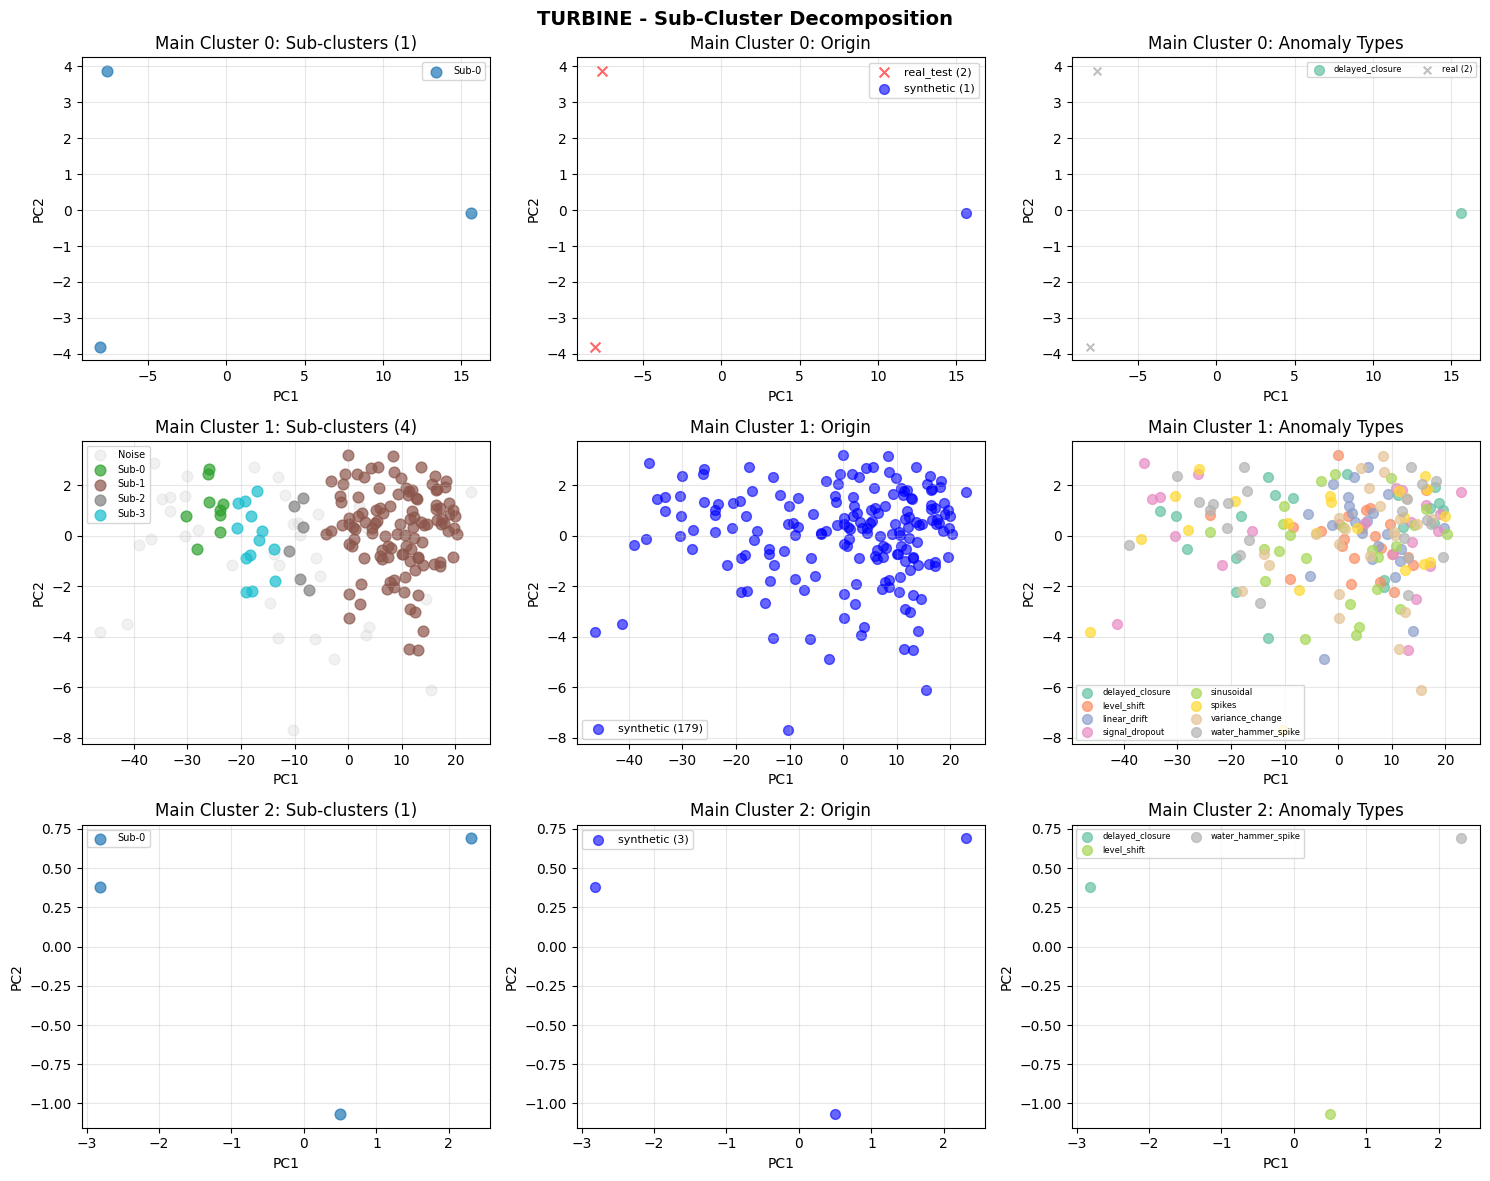

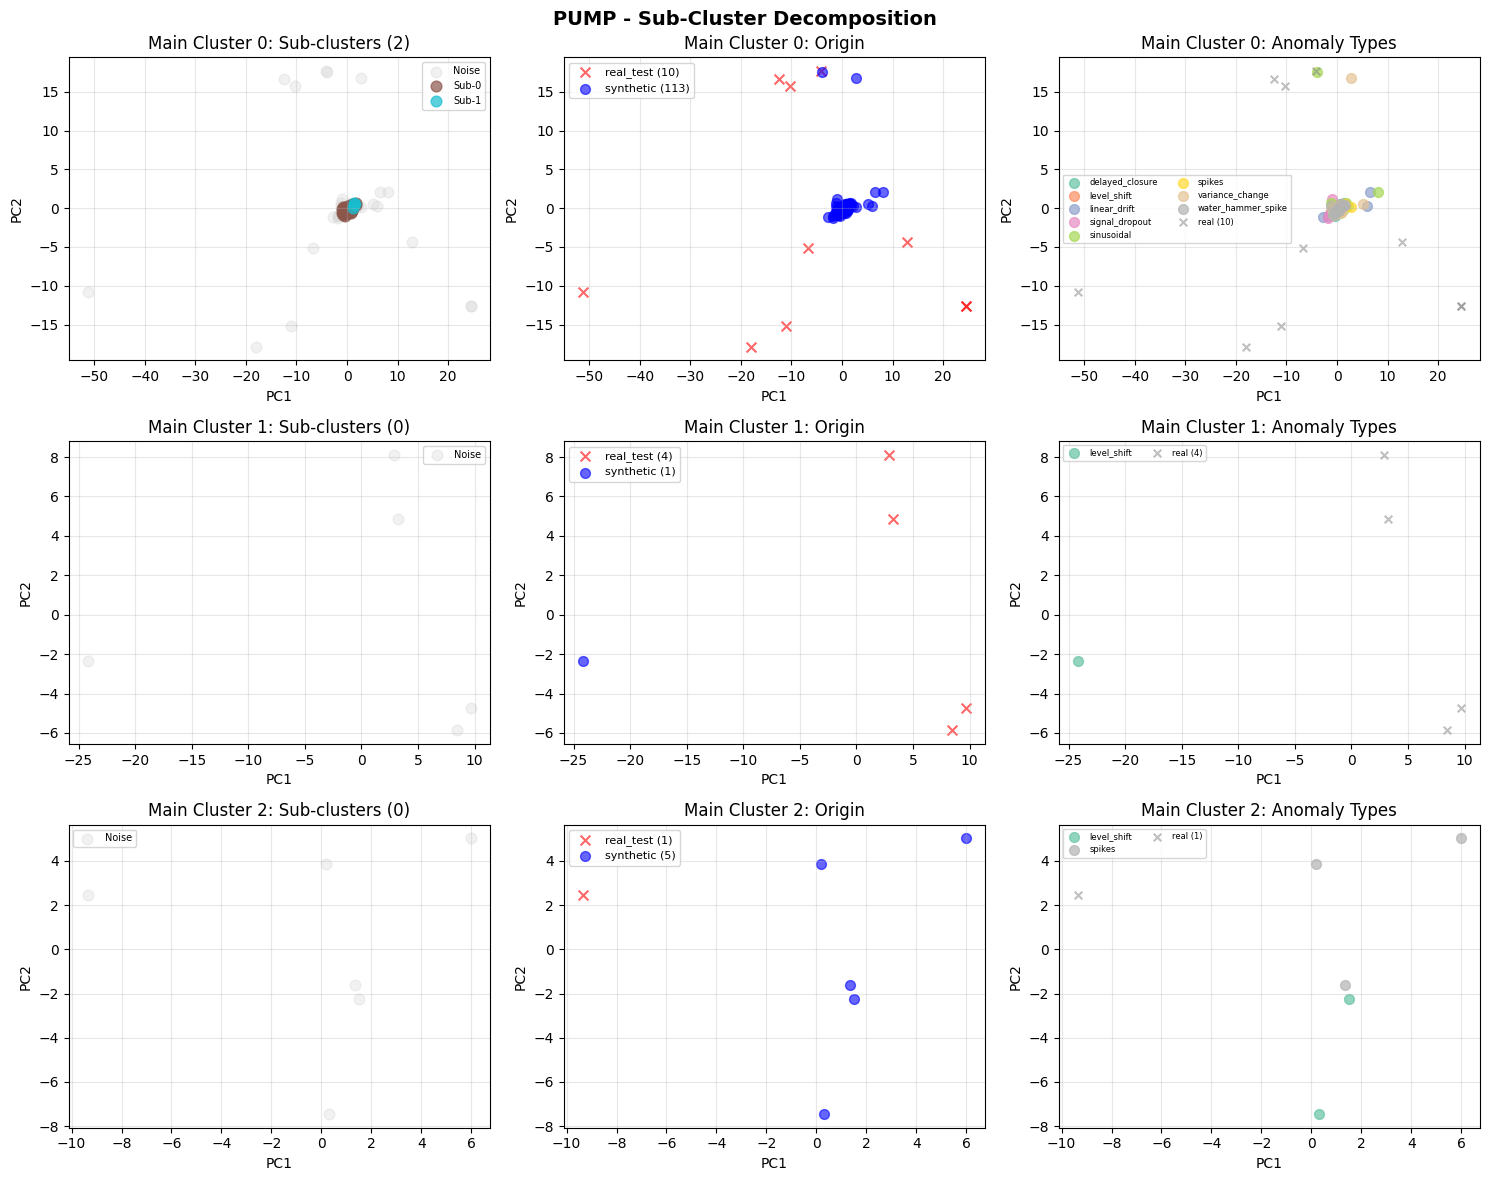


HEATMAP: SUB-CLUSTER COMPOSITION BY ANOMALY TYPE


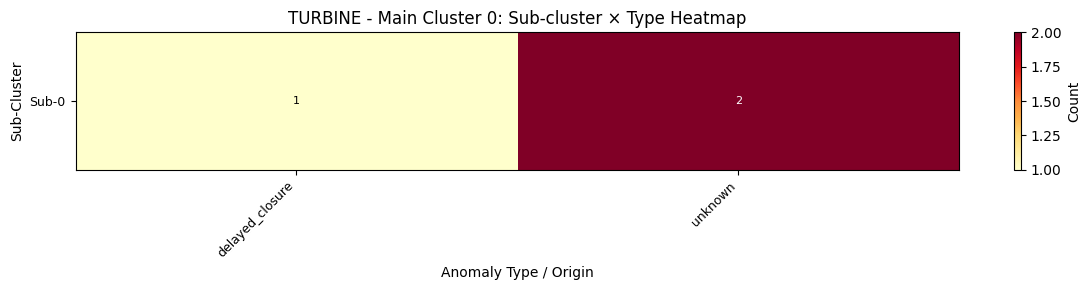

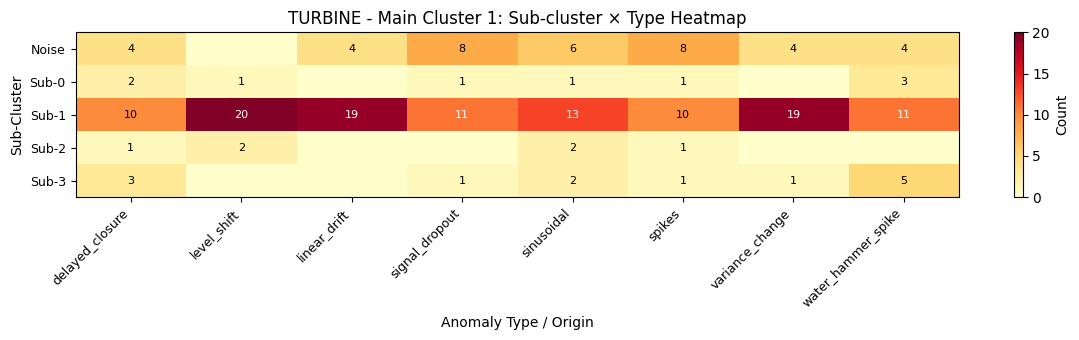

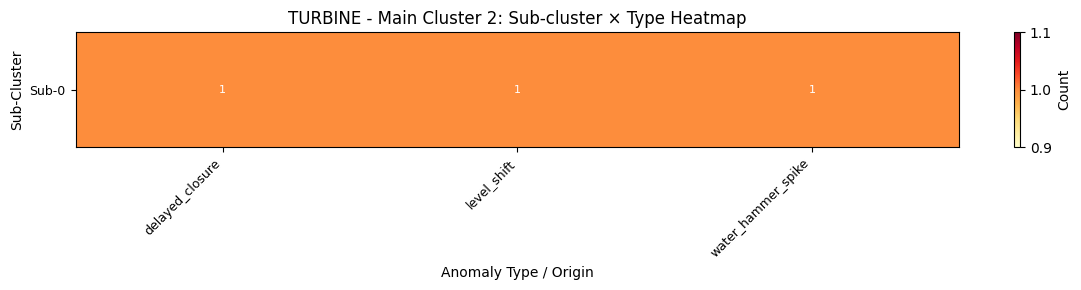

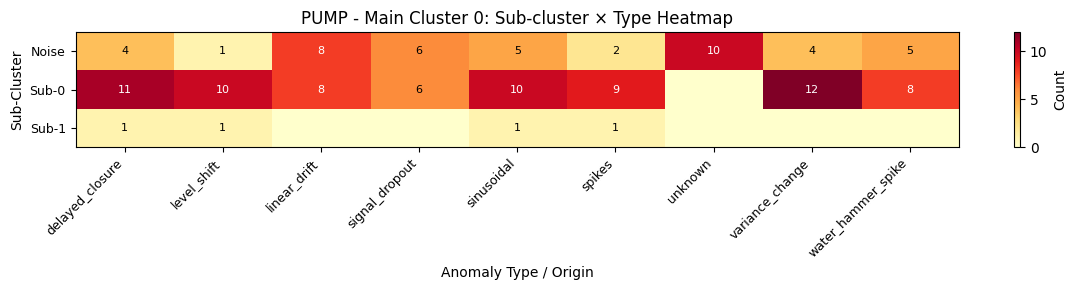

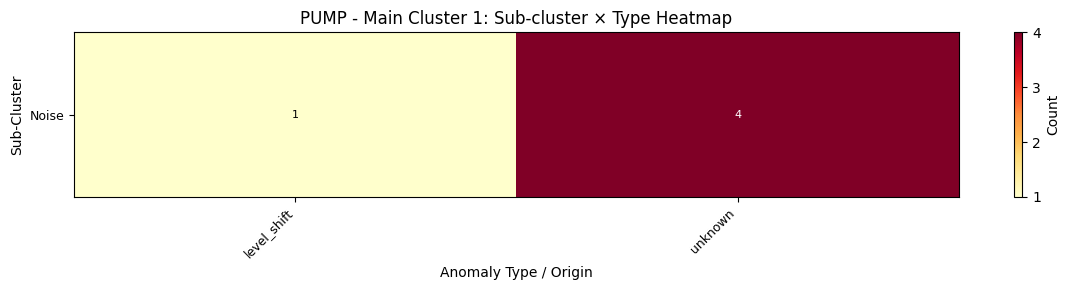

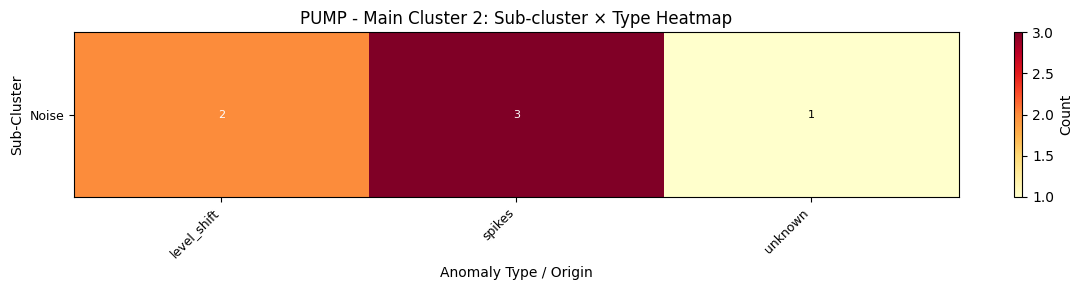


SUB-CLUSTER SUMMARY

TURBINE:
----------------------------------------------------------------------
Main     Sub      Total    Real     Syn      Top Types
----------------------------------------------------------------------
0        Sub-0    3        2        1        delayed_cl:1
1        Noise    38       0        38       spikes:8, signal_dro:8
1        Sub-0    9        0        9        water_hamm:3, delayed_cl:2
1        Sub-1    113      0        113      level_shif:20, linear_dri:19
1        Sub-2    6        0        6        level_shif:2, sinusoidal:2
1        Sub-3    13       0        13       water_hamm:5, delayed_cl:3
2        Sub-0    3        0        3        delayed_cl:1, water_hamm:1

PUMP:
----------------------------------------------------------------------
Main     Sub      Total    Real     Syn      Top Types
----------------------------------------------------------------------
0        Noise    45       10       35       linear_dri:8, signal_dro:6
0       

In [ ]:
# ==============================================================================
# SUB-CLUSTER DECOMPOSITION WITHIN MAIN CLUSTERS
# ==============================================================================
# For each main HDBSCAN cluster, perform secondary clustering to identify
# finer-grained patterns within the cluster
# ==============================================================================

# ==============================================================================
# CONFIG
# ==============================================================================
# Sub-clustering parameters (even tighter tolerances)
SUBCLUSTER_MIN_CLUSTER_SIZE = 3
SUBCLUSTER_MIN_SAMPLES = 3

# Minimum cluster size to perform sub-clustering
MIN_POINTS_FOR_SUBCLUSTER = 5

# ==============================================================================
# PERFORM SUB-CLUSTERING FOR EACH REGIME
# ==============================================================================
print("="*70)
print("SUB-CLUSTER DECOMPOSITION")
print("="*70)

subcluster_results = {}

for regime in results_clustering.keys():
    r = results_clustering[regime]
    
    print(f"\n{'='*70}")
    print(f"REGIME: {regime.upper()}")
    print(f"{'='*70}")
    
    cluster_labels = r['cluster_labels']
    latent_flagged = r['latent_flagged']
    types_flagged = r['types_flagged']
    origin_flagged = r['origin_flagged']
    signals_flagged = r['signals_flagged']
    
    # Get unique main clusters (excluding noise = -1)
    main_clusters = sorted([c for c in np.unique(cluster_labels) if c >= 0])
    
    print(f"\n  Main clusters found: {len(main_clusters)}")
    for mc in main_clusters:
        n_points = (cluster_labels == mc).sum()
        print(f"    Cluster {mc}: {n_points} points")
    
    subcluster_results[regime] = {
        'main_clusters': main_clusters,
        'subclusters': {}
    }
    
    # -------------------------------------------------------------------------
    # Sub-cluster each main cluster
    # -------------------------------------------------------------------------
    for main_cluster in main_clusters:
        mask = cluster_labels == main_cluster
        n_points = mask.sum()
        
        print(f"\n  --- Main Cluster {main_cluster} ({n_points} points) ---")
        
        if n_points < MIN_POINTS_FOR_SUBCLUSTER:
            print(f"      Too few points for sub-clustering. Skipping.")
            subcluster_results[regime]['subclusters'][main_cluster] = {
                'n_points': n_points,
                'subcluster_labels': np.zeros(n_points, dtype=int),  # All in subcluster 0
                'n_subclusters': 1,
                'latent': latent_flagged[mask],
                'types': types_flagged[mask],
                'origin': origin_flagged[mask],
                'signals': signals_flagged[mask],
            }
            continue
        
        # Extract latent vectors for this cluster
        latent_cluster = latent_flagged[mask]
        types_cluster = types_flagged[mask]
        origin_cluster = origin_flagged[mask]
        signals_cluster = signals_flagged[mask]
        
        # Run HDBSCAN on this cluster
        sub_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=SUBCLUSTER_MIN_CLUSTER_SIZE,
            min_samples=SUBCLUSTER_MIN_SAMPLES,
            metric='euclidean',
            cluster_selection_method='eom'
        )
        sub_labels = sub_clusterer.fit_predict(latent_cluster)
        
        n_subclusters = len(set(sub_labels)) - (1 if -1 in sub_labels else 0)
        n_sub_noise = (sub_labels == -1).sum()
        
        print(f"      Sub-clusters found: {n_subclusters}")
        print(f"      Noise points: {n_sub_noise}")
        
        # Store results
        subcluster_results[regime]['subclusters'][main_cluster] = {
            'n_points': n_points,
            'subcluster_labels': sub_labels,
            'n_subclusters': n_subclusters,
            'n_noise': n_sub_noise,
            'latent': latent_cluster,
            'types': types_cluster,
            'origin': origin_cluster,
            'signals': signals_cluster,
            'indices_in_flagged': np.where(mask)[0],  # Map back to flagged array
        }
        
        # Analyze composition of each sub-cluster
        print(f"\n      Sub-cluster composition:")
        for sc in sorted(set(sub_labels)):
            sc_mask = sub_labels == sc
            sc_types = types_cluster[sc_mask]
            sc_origin = origin_cluster[sc_mask]
            
            n_real = (sc_origin == 'real_test').sum()
            n_syn = (sc_origin == 'synthetic').sum()
            
            label = f"Sub-{sc}" if sc >= 0 else "Noise"
            print(f"        {label}: {sc_mask.sum()} points (real={n_real}, syn={n_syn})")
            
            # Type breakdown for synthetic
            if n_syn > 0:
                syn_types = sc_types[sc_origin == 'synthetic']
                type_counts = Counter(syn_types)
                types_str = ", ".join([f"{t}:{c}" for t, c in type_counts.most_common(3)])
                print(f"          Syn types: {types_str}")

# ==============================================================================
# VISUALIZATION: SUB-CLUSTERS
# ==============================================================================
print("\n" + "="*70)
print("VISUALIZATION: SUB-CLUSTER DECOMPOSITION")
print("="*70)

for regime in subcluster_results.keys():
    r_main = results_clustering[regime]
    r_sub = subcluster_results[regime]
    main_clusters = r_sub['main_clusters']
    
    if len(main_clusters) == 0:
        print(f"\n{regime.upper()}: No main clusters to decompose")
        continue
    
    # Create figure with one row per main cluster
    n_main = len(main_clusters)
    fig, axes = plt.subplots(n_main, 3, figsize=(15, 4*n_main))
    if n_main == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{regime.upper()} - Sub-Cluster Decomposition', fontsize=14, fontweight='bold')
    
    for row, main_cluster in enumerate(main_clusters):
        sc_data = r_sub['subclusters'][main_cluster]
        latent_cluster = sc_data['latent']
        sub_labels = sc_data['subcluster_labels']
        types_cluster = sc_data['types']
        origin_cluster = sc_data['origin']
        
        # PCA for this cluster
        if len(latent_cluster) >= 2:
            pca = PCA(n_components=2)
            latent_2d = pca.fit_transform(latent_cluster)
        else:
            latent_2d = latent_cluster[:, :2] if latent_cluster.shape[1] >= 2 else np.zeros((len(latent_cluster), 2))
        
        # ---------------------------------------------------------------------
        # Col 0: Sub-clusters
        # ---------------------------------------------------------------------
        ax = axes[row, 0]
        unique_subs = np.unique(sub_labels)
        colors = plt.cm.tab10(np.linspace(0, 1, max(len(unique_subs), 1)))
        
        for i, sc in enumerate(unique_subs):
            mask = sub_labels == sc
            label = f'Sub-{sc}' if sc >= 0 else 'Noise'
            color = 'lightgray' if sc == -1 else colors[i]
            alpha = 0.3 if sc == -1 else 0.7
            ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=[color], label=label, alpha=alpha, s=60)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(f'Main Cluster {main_cluster}: Sub-clusters ({sc_data["n_subclusters"]})')
        ax.legend(loc='best', fontsize=7)
        ax.grid(True, alpha=0.3)
        
        # ---------------------------------------------------------------------
        # Col 1: Origin (Real vs Synthetic)
        # ---------------------------------------------------------------------
        ax = axes[row, 1]
        for origin_type, color, marker in [('real_test', 'red', 'x'), ('synthetic', 'blue', 'o')]:
            mask = origin_cluster == origin_type
            if mask.any():
                ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=color, marker=marker, 
                           label=f'{origin_type} ({mask.sum()})', alpha=0.6, s=50)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(f'Main Cluster {main_cluster}: Origin')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # ---------------------------------------------------------------------
        # Col 2: Anomaly Types
        # ---------------------------------------------------------------------
        ax = axes[row, 2]
        types_unique = [t for t in np.unique(types_cluster) if t != 'unknown']
        colors_types = plt.cm.Set2(np.linspace(0, 1, max(len(types_unique), 1)))
        
        for i, atype in enumerate(types_unique):
            mask = types_cluster == atype
            ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=[colors_types[i]], label=atype, alpha=0.7, s=50)
        
        # Real test as gray X
        mask_real = origin_cluster == 'real_test'
        if mask_real.any():
            ax.scatter(latent_2d[mask_real, 0], latent_2d[mask_real, 1], c='gray', marker='x', 
                       label=f'real ({mask_real.sum()})', alpha=0.5, s=30)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(f'Main Cluster {main_cluster}: Anomaly Types')
        ax.legend(loc='best', fontsize=6, ncol=2)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'subcluster_decomposition_{regime}.png'), dpi=150, bbox_inches='tight')
    plt.show()

# ==============================================================================
# HEATMAP: SUB-CLUSTER × ANOMALY TYPE
# ==============================================================================
print("\n" + "="*70)
print("HEATMAP: SUB-CLUSTER COMPOSITION BY ANOMALY TYPE")
print("="*70)

for regime in subcluster_results.keys():
    r_sub = subcluster_results[regime]
    main_clusters = r_sub['main_clusters']
    
    if len(main_clusters) == 0:
        continue
    
    # Create heatmap for each main cluster
    for main_cluster in main_clusters:
        sc_data = r_sub['subclusters'][main_cluster]
        sub_labels = sc_data['subcluster_labels']
        types_cluster = sc_data['types']
        origin_cluster = sc_data['origin']
        
        # Get unique sub-clusters and types
        unique_subs = sorted([s for s in np.unique(sub_labels)])
        all_types = sorted([t for t in np.unique(types_cluster)])
        
        # Build count matrix
        count_matrix = np.zeros((len(unique_subs), len(all_types)))
        
        for i, sc in enumerate(unique_subs):
            sc_mask = sub_labels == sc
            for j, atype in enumerate(all_types):
                count_matrix[i, j] = ((types_cluster == atype) & sc_mask).sum()
        
        # Plot heatmap
        fig, ax = plt.subplots(figsize=(12, max(3, len(unique_subs) * 0.5 + 1)))
        
        im = ax.imshow(count_matrix, cmap='YlOrRd', aspect='auto')
        
        ax.set_xticks(np.arange(len(all_types)))
        ax.set_yticks(np.arange(len(unique_subs)))
        ax.set_xticklabels(all_types, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels([f'Sub-{s}' if s >= 0 else 'Noise' for s in unique_subs], fontsize=9)
        
        # Add count annotations
        for i in range(len(unique_subs)):
            for j in range(len(all_types)):
                val = int(count_matrix[i, j])
                if val > 0:
                    text_color = 'white' if val > count_matrix.max() / 2 else 'black'
                    ax.text(j, i, str(val), ha='center', va='center', color=text_color, fontsize=8)
        
        ax.set_xlabel('Anomaly Type / Origin')
        ax.set_ylabel('Sub-Cluster')
        ax.set_title(f'{regime.upper()} - Main Cluster {main_cluster}: Sub-cluster × Type Heatmap')
        
        plt.colorbar(im, ax=ax, label='Count')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'subcluster_heatmap_{regime}_cluster{main_cluster}.png'), 
                    dpi=150, bbox_inches='tight')
        plt.show()

# ==============================================================================
# SUMMARY TABLE
# ==============================================================================
print("\n" + "="*70)
print("SUB-CLUSTER SUMMARY")
print("="*70)

for regime in subcluster_results.keys():
    r_sub = subcluster_results[regime]
    main_clusters = r_sub['main_clusters']
    
    print(f"\n{regime.upper()}:")
    print("-"*70)
    print(f"{'Main':<8} {'Sub':<8} {'Total':<8} {'Real':<8} {'Syn':<8} {'Top Types'}")
    print("-"*70)
    
    for main_cluster in main_clusters:
        sc_data = r_sub['subclusters'][main_cluster]
        sub_labels = sc_data['subcluster_labels']
        types_cluster = sc_data['types']
        origin_cluster = sc_data['origin']
        
        for sc in sorted(set(sub_labels)):
            sc_mask = sub_labels == sc
            n_total = sc_mask.sum()
            n_real = ((origin_cluster == 'real_test') & sc_mask).sum()
            n_syn = ((origin_cluster == 'synthetic') & sc_mask).sum()
            
            # Top types
            syn_types = types_cluster[(origin_cluster == 'synthetic') & sc_mask]
            if len(syn_types) > 0:
                type_counts = Counter(syn_types)
                top_types = ", ".join([f"{t[:10]}:{c}" for t, c in type_counts.most_common(2)])
            else:
                top_types = "-"
            
            sc_label = f"Sub-{sc}" if sc >= 0 else "Noise"
            print(f"{main_cluster:<8} {sc_label:<8} {n_total:<8} {n_real:<8} {n_syn:<8} {top_types}")

print("\n" + "="*70)
print("✅ SUB-CLUSTERING COMPLETE")
print("="*70)
print("\nResults stored in 'subcluster_results'")
print("  subcluster_results['turbine']['subclusters'][cluster_id]")
print("  subcluster_results['pump']['subclusters'][cluster_id]")